# Plan

- 'maximum_speed_limit' 이 랜덤포레스트에서 높은 중요도를 가짐 : 주형 EDA
- test 에 속도 40 제한 구역이 없다.
- 제한속도별로 랜덤포레스트를 돌린후 다시합치는 계획

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

<AxesSubplot:>

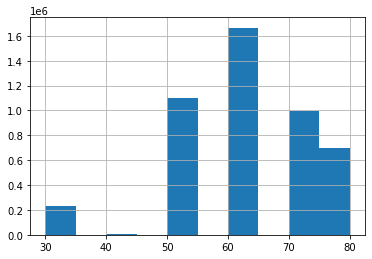

In [11]:
train['maximum_speed_limit'].hist()

In [12]:
train["maximum_speed_limit"].value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

<AxesSubplot:>

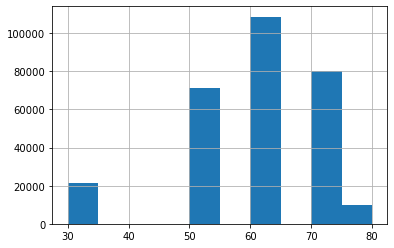

In [13]:
test['maximum_speed_limit'].hist()

In [14]:
test["maximum_speed_limit"].value_counts()

60.0    108606
70.0     80356
50.0     71315
30.0     21350
80.0      9614
Name: maximum_speed_limit, dtype: int64

- 제한속도별로 랜덤포레스트를 돌린후 다시합치는 계획 : 예시로 속도 80제한 데이터만 추출하여 랜덤포레스트 돌려본다.
- "maximum_speed_limit" 분리되면 사용되지 않으므로 레이블인코딩 제외

In [4]:
from sklearn.preprocessing import LabelEncoder
str_col = ["base_date","base_hour","day_of_week","lane_count","road_rating","multi_linked","connect_code"
           ,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
          "end_turn_restricted","road_name","start_node_name","end_node_name",'end_latitude','end_longitude'] # "maximum_speed_limit"
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [42]:
train = train[train["maximum_speed_limit"]==80]
y_train = train['target'] 
X_train = train.drop(['id', 'target'], axis=1)

test = test[test["maximum_speed_limit"]==80]
test_id = test['id']
test = test.drop(['id'], axis=1)

print(X_train.shape)
print(y_train.shape)
print(test.shape)

(700334, 19)
(700334,)
(9614, 19)


In [43]:
prediction_table = pd.DataFrame(test_id)

In [44]:
X_train,X_test,y_train,y_test = train_test_split(
    X_train,y_train,test_size=0.1,random_state=10
)

In [45]:
from sklearn.ensemble import RandomForestRegressor
tp = RandomForestRegressor(random_state=56)
tp.fit(X_train,y_train)
pred = tp.predict(X_test)
mae = mean_absolute_error(pred,y_test)
print(mae)

2.458636233829283


In [46]:
prediction_table['target'] = tp.predict(test)

In [47]:
prediction_table.to_csv('./target80.csv')

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor


r1 = RandomForestRegressor(random_state=10,criterion='absolute_error')
r2 = CatBoostRegressor(random_state=10)
r3 = ExtraTreesRegressor(random_state=10,criterion='absolute_error')
vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])
vote.fit(X_train,y_train)

In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)

from haversine import haversine, Unit, haversine_vector
start = [(i-90,j) for i,j in zip(train['start_longitude'],train['start_latitude'])]
end = [(i-90,j) for i,j in zip(train['end_longitude'],train['end_latitude'])]
distance = [haversine(i, j, unit=Unit.KILOMETERS) for i,j in zip(start,end)]

# train = train.drop(['start_longitude','end_longitude','start_latitude','end_latitude'],axis=1)
train['distance'] = distance

from haversine import haversine, Unit, haversine_vector
start = [(i-90,j) for i,j in zip(test['start_longitude'],test['start_latitude'])]
end = [(i-90,j) for i,j in zip(test['end_longitude'],test['end_latitude'])]
distance = [haversine(i, j, unit=Unit.KILOMETERS) for i,j in zip(start,end)]

# train = train.drop(['start_longitude','end_longitude','start_latitude','end_latitude'],axis=1)
test['distance'] = distance
#train = train[train['connect_code'] == 0]
#train = train[train['multi_linked'] == 0]
train = train[train['maximum_speed_limit'] != 40]

In [12]:
from sklearn.preprocessing import LabelEncoder

str_col = ["base_date","base_hour","day_of_week","lane_count","multi_linked","connect_code"
,"weight_restricted","road_type","start_latitude","start_longitude","start_turn_restricted",
"end_turn_restricted","road_name","start_node_name","end_node_name",'end_latitude','end_longitude'] # "maximum_speed_limit"

for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])

    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def rf_speed(speed,train,test):
#     train = pd.read_parquet('./train.parquet')
#     test = pd.read_parquet('./test.parquet')
#     train = train.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
#     test = test.drop(['road_in_use','vehicle_restricted','height_restricted'],axis=1)
    
    train = train.drop(train[(train['distance'] > 0.5) & (train['target'] < 4)].index)

    train = train[train["maximum_speed_limit"]==speed]
    y_train = train['target'] 
    X_train = train.drop(['id', 'target'], axis=1)

    test = test[test["maximum_speed_limit"]==speed]
    test_id = test['id']
    test = test.drop(['id'], axis=1)

    prediction_table = pd.DataFrame(test_id)

    X_train,X_test,y_train,y_test = train_test_split(
        X_train,y_train,test_size=0.08,random_state=10
    )

    r1 = RandomForestRegressor(random_state=10,bootstrap=200,oob_score=True)
    r2 = CatBoostRegressor(random_state=10,iterations=5000)
    r3 = ExtraTreesRegressor(random_state=10)
    vote = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3)])

    parms = {'verbose':[False]}
    grid_cv = GridSearchCV(vote,param_grid=parms,cv=5,n_jobs=-1,scoring='neg_mean_absolute_error')# ,param_grid=parms
    grid_cv.fit(X_train,y_train)

    pred = grid_cv.predict(X_test)
    mae = mean_absolute_error(pred,y_test)
    print(mae)

    prediction_table['target'] = grid_cv.predict(test)
    prediction_table.to_csv(f'./target{speed}.csv')
    print(f'save {speed}')


In [21]:
for i in [30,50,60,70,80]:
    rf_speed(i,train,test)

Learning rate set to 0.02578
0:	learn: 9.4661094	total: 32.4ms	remaining: 2m 41s
1:	learn: 9.3061332	total: 49.5ms	remaining: 2m 3s
2:	learn: 9.1464906	total: 64ms	remaining: 1m 46s
3:	learn: 8.9896444	total: 81.1ms	remaining: 1m 41s
4:	learn: 8.8392027	total: 100ms	remaining: 1m 40s
5:	learn: 8.6930400	total: 120ms	remaining: 1m 39s
6:	learn: 8.5574481	total: 138ms	remaining: 1m 38s
7:	learn: 8.4157919	total: 154ms	remaining: 1m 36s
8:	learn: 8.2847529	total: 170ms	remaining: 1m 34s
9:	learn: 8.1622397	total: 199ms	remaining: 1m 39s
10:	learn: 8.0444535	total: 220ms	remaining: 1m 39s
11:	learn: 7.9175896	total: 237ms	remaining: 1m 38s
12:	learn: 7.8033724	total: 251ms	remaining: 1m 36s
13:	learn: 7.6889846	total: 264ms	remaining: 1m 34s
14:	learn: 7.5792504	total: 278ms	remaining: 1m 32s
15:	learn: 7.4837965	total: 290ms	remaining: 1m 30s
16:	learn: 7.3812322	total: 301ms	remaining: 1m 28s
17:	learn: 7.2808934	total: 313ms	remaining: 1m 26s
18:	learn: 7.1834226	total: 324ms	remaining:

165:	learn: 4.3787336	total: 2.09s	remaining: 1m
166:	learn: 4.3767130	total: 2.1s	remaining: 1m
167:	learn: 4.3750709	total: 2.12s	remaining: 1m
168:	learn: 4.3731779	total: 2.13s	remaining: 1m
169:	learn: 4.3717918	total: 2.14s	remaining: 1m
170:	learn: 4.3703016	total: 2.15s	remaining: 1m
171:	learn: 4.3682360	total: 2.16s	remaining: 1m
172:	learn: 4.3661047	total: 2.17s	remaining: 1m
173:	learn: 4.3644214	total: 2.19s	remaining: 1m
174:	learn: 4.3627025	total: 2.2s	remaining: 1m
175:	learn: 4.3604787	total: 2.21s	remaining: 1m
176:	learn: 4.3587966	total: 2.22s	remaining: 1m
177:	learn: 4.3569197	total: 2.24s	remaining: 1m
178:	learn: 4.3550429	total: 2.25s	remaining: 1m
179:	learn: 4.3539321	total: 2.26s	remaining: 1m
180:	learn: 4.3522529	total: 2.27s	remaining: 1m
181:	learn: 4.3506975	total: 2.28s	remaining: 1m
182:	learn: 4.3490517	total: 2.29s	remaining: 1m
183:	learn: 4.3474673	total: 2.31s	remaining: 1m
184:	learn: 4.3447569	total: 2.32s	remaining: 1m
185:	learn: 4.3433717	

338:	learn: 4.2088439	total: 4.21s	remaining: 57.9s
339:	learn: 4.2083949	total: 4.22s	remaining: 57.9s
340:	learn: 4.2076210	total: 4.24s	remaining: 57.9s
341:	learn: 4.2069139	total: 4.25s	remaining: 57.9s
342:	learn: 4.2065129	total: 4.26s	remaining: 57.9s
343:	learn: 4.2060134	total: 4.28s	remaining: 57.9s
344:	learn: 4.2054304	total: 4.29s	remaining: 57.9s
345:	learn: 4.2048714	total: 4.3s	remaining: 57.9s
346:	learn: 4.2045316	total: 4.32s	remaining: 57.9s
347:	learn: 4.2041105	total: 4.33s	remaining: 57.8s
348:	learn: 4.2040437	total: 4.33s	remaining: 57.8s
349:	learn: 4.2032828	total: 4.35s	remaining: 57.8s
350:	learn: 4.2026242	total: 4.36s	remaining: 57.8s
351:	learn: 4.2018316	total: 4.37s	remaining: 57.8s
352:	learn: 4.2014616	total: 4.39s	remaining: 57.7s
353:	learn: 4.2009718	total: 4.4s	remaining: 57.7s
354:	learn: 4.2005248	total: 4.41s	remaining: 57.7s
355:	learn: 4.2002180	total: 4.42s	remaining: 57.7s
356:	learn: 4.1995597	total: 4.44s	remaining: 57.7s
357:	learn: 4.

499:	learn: 4.1443537	total: 6.29s	remaining: 56.7s
500:	learn: 4.1439753	total: 6.31s	remaining: 56.7s
501:	learn: 4.1437526	total: 6.32s	remaining: 56.7s
502:	learn: 4.1434601	total: 6.33s	remaining: 56.6s
503:	learn: 4.1431187	total: 6.35s	remaining: 56.6s
504:	learn: 4.1428845	total: 6.36s	remaining: 56.6s
505:	learn: 4.1426385	total: 6.37s	remaining: 56.6s
506:	learn: 4.1423712	total: 6.38s	remaining: 56.6s
507:	learn: 4.1421727	total: 6.4s	remaining: 56.6s
508:	learn: 4.1419444	total: 6.41s	remaining: 56.5s
509:	learn: 4.1416194	total: 6.42s	remaining: 56.5s
510:	learn: 4.1413376	total: 6.43s	remaining: 56.5s
511:	learn: 4.1411703	total: 6.45s	remaining: 56.5s
512:	learn: 4.1407971	total: 6.46s	remaining: 56.5s
513:	learn: 4.1404190	total: 6.47s	remaining: 56.5s
514:	learn: 4.1399853	total: 6.49s	remaining: 56.5s
515:	learn: 4.1396772	total: 6.5s	remaining: 56.5s
516:	learn: 4.1394308	total: 6.51s	remaining: 56.5s
517:	learn: 4.1391798	total: 6.52s	remaining: 56.4s
518:	learn: 4.

664:	learn: 4.1008365	total: 8.46s	remaining: 55.1s
665:	learn: 4.1006491	total: 8.47s	remaining: 55.1s
666:	learn: 4.1004908	total: 8.48s	remaining: 55.1s
667:	learn: 4.1001241	total: 8.5s	remaining: 55.1s
668:	learn: 4.0999585	total: 8.51s	remaining: 55.1s
669:	learn: 4.0997140	total: 8.52s	remaining: 55.1s
670:	learn: 4.0993457	total: 8.53s	remaining: 55.1s
671:	learn: 4.0991923	total: 8.55s	remaining: 55s
672:	learn: 4.0989216	total: 8.56s	remaining: 55s
673:	learn: 4.0987069	total: 8.57s	remaining: 55s
674:	learn: 4.0984111	total: 8.59s	remaining: 55s
675:	learn: 4.0982014	total: 8.6s	remaining: 55s
676:	learn: 4.0980716	total: 8.61s	remaining: 55s
677:	learn: 4.0977271	total: 8.62s	remaining: 55s
678:	learn: 4.0975338	total: 8.64s	remaining: 55s
679:	learn: 4.0972701	total: 8.65s	remaining: 55s
680:	learn: 4.0971269	total: 8.66s	remaining: 54.9s
681:	learn: 4.0968027	total: 8.68s	remaining: 54.9s
682:	learn: 4.0965517	total: 8.69s	remaining: 54.9s
683:	learn: 4.0963968	total: 8.7

836:	learn: 4.0675360	total: 10.6s	remaining: 52.7s
837:	learn: 4.0673503	total: 10.6s	remaining: 52.7s
838:	learn: 4.0671497	total: 10.6s	remaining: 52.7s
839:	learn: 4.0669706	total: 10.6s	remaining: 52.6s
840:	learn: 4.0668383	total: 10.6s	remaining: 52.6s
841:	learn: 4.0666890	total: 10.7s	remaining: 52.6s
842:	learn: 4.0665502	total: 10.7s	remaining: 52.6s
843:	learn: 4.0664209	total: 10.7s	remaining: 52.6s
844:	learn: 4.0661883	total: 10.7s	remaining: 52.5s
845:	learn: 4.0659556	total: 10.7s	remaining: 52.5s
846:	learn: 4.0658527	total: 10.7s	remaining: 52.5s
847:	learn: 4.0657011	total: 10.7s	remaining: 52.5s
848:	learn: 4.0655568	total: 10.7s	remaining: 52.4s
849:	learn: 4.0654131	total: 10.7s	remaining: 52.4s
850:	learn: 4.0652695	total: 10.7s	remaining: 52.4s
851:	learn: 4.0651108	total: 10.8s	remaining: 52.4s
852:	learn: 4.0649608	total: 10.8s	remaining: 52.4s
853:	learn: 4.0648131	total: 10.8s	remaining: 52.4s
854:	learn: 4.0647003	total: 10.8s	remaining: 52.3s
855:	learn: 

1013:	learn: 4.0400132	total: 12.7s	remaining: 50s
1014:	learn: 4.0398557	total: 12.7s	remaining: 50s
1015:	learn: 4.0397103	total: 12.7s	remaining: 50s
1016:	learn: 4.0395379	total: 12.8s	remaining: 50s
1017:	learn: 4.0394247	total: 12.8s	remaining: 49.9s
1018:	learn: 4.0392087	total: 12.8s	remaining: 49.9s
1019:	learn: 4.0390839	total: 12.8s	remaining: 49.9s
1020:	learn: 4.0389939	total: 12.8s	remaining: 49.9s
1021:	learn: 4.0389041	total: 12.8s	remaining: 49.9s
1022:	learn: 4.0387945	total: 12.8s	remaining: 49.9s
1023:	learn: 4.0386388	total: 12.8s	remaining: 49.8s
1024:	learn: 4.0385562	total: 12.8s	remaining: 49.8s
1025:	learn: 4.0383681	total: 12.9s	remaining: 49.8s
1026:	learn: 4.0382774	total: 12.9s	remaining: 49.8s
1027:	learn: 4.0380481	total: 12.9s	remaining: 49.8s
1028:	learn: 4.0378629	total: 12.9s	remaining: 49.7s
1029:	learn: 4.0377208	total: 12.9s	remaining: 49.7s
1030:	learn: 4.0375969	total: 12.9s	remaining: 49.7s
1031:	learn: 4.0374858	total: 12.9s	remaining: 49.7s
1

1174:	learn: 4.0192224	total: 14.6s	remaining: 47.5s
1175:	learn: 4.0191408	total: 14.6s	remaining: 47.5s
1176:	learn: 4.0190588	total: 14.6s	remaining: 47.5s
1177:	learn: 4.0189253	total: 14.6s	remaining: 47.5s
1178:	learn: 4.0188179	total: 14.6s	remaining: 47.5s
1179:	learn: 4.0186374	total: 14.7s	remaining: 47.4s
1180:	learn: 4.0185367	total: 14.7s	remaining: 47.4s
1181:	learn: 4.0184042	total: 14.7s	remaining: 47.4s
1182:	learn: 4.0183355	total: 14.7s	remaining: 47.4s
1183:	learn: 4.0181392	total: 14.7s	remaining: 47.4s
1184:	learn: 4.0179828	total: 14.7s	remaining: 47.4s
1185:	learn: 4.0179045	total: 14.7s	remaining: 47.3s
1186:	learn: 4.0178066	total: 14.7s	remaining: 47.3s
1187:	learn: 4.0176720	total: 14.7s	remaining: 47.3s
1188:	learn: 4.0174882	total: 14.8s	remaining: 47.3s
1189:	learn: 4.0173209	total: 14.8s	remaining: 47.3s
1190:	learn: 4.0171982	total: 14.8s	remaining: 47.3s
1191:	learn: 4.0170976	total: 14.8s	remaining: 47.2s
1192:	learn: 4.0170127	total: 14.8s	remaining:

1336:	learn: 4.0028408	total: 16.5s	remaining: 45.2s
1337:	learn: 4.0027681	total: 16.5s	remaining: 45.2s
1338:	learn: 4.0027049	total: 16.5s	remaining: 45.2s
1339:	learn: 4.0025279	total: 16.5s	remaining: 45.2s
1340:	learn: 4.0024566	total: 16.6s	remaining: 45.2s
1341:	learn: 4.0023737	total: 16.6s	remaining: 45.2s
1342:	learn: 4.0023261	total: 16.6s	remaining: 45.2s
1343:	learn: 4.0022087	total: 16.6s	remaining: 45.2s
1344:	learn: 4.0021530	total: 16.6s	remaining: 45.2s
1345:	learn: 4.0020485	total: 16.6s	remaining: 45.2s
1346:	learn: 4.0019181	total: 16.7s	remaining: 45.2s
1347:	learn: 4.0018749	total: 16.7s	remaining: 45.1s
1348:	learn: 4.0017802	total: 16.7s	remaining: 45.1s
1349:	learn: 4.0017042	total: 16.7s	remaining: 45.1s
1350:	learn: 4.0016111	total: 16.7s	remaining: 45.1s
1351:	learn: 4.0015666	total: 16.7s	remaining: 45.1s
1352:	learn: 4.0014695	total: 16.7s	remaining: 45.1s
1353:	learn: 4.0013440	total: 16.7s	remaining: 45.1s
1354:	learn: 4.0011978	total: 16.7s	remaining:

1499:	learn: 3.9881465	total: 18.4s	remaining: 43s
1500:	learn: 3.9879777	total: 18.4s	remaining: 43s
1501:	learn: 3.9878756	total: 18.5s	remaining: 43s
1502:	learn: 3.9877457	total: 18.5s	remaining: 43s
1503:	learn: 3.9875962	total: 18.5s	remaining: 42.9s
1504:	learn: 3.9875119	total: 18.5s	remaining: 42.9s
1505:	learn: 3.9874490	total: 18.5s	remaining: 42.9s
1506:	learn: 3.9873018	total: 18.5s	remaining: 42.9s
1507:	learn: 3.9872361	total: 18.5s	remaining: 42.9s
1508:	learn: 3.9871898	total: 18.5s	remaining: 42.9s
1509:	learn: 3.9870900	total: 18.5s	remaining: 42.9s
1510:	learn: 3.9870265	total: 18.6s	remaining: 42.8s
1511:	learn: 3.9869510	total: 18.6s	remaining: 42.8s
1512:	learn: 3.9868926	total: 18.6s	remaining: 42.8s
1513:	learn: 3.9868013	total: 18.6s	remaining: 42.8s
1514:	learn: 3.9867313	total: 18.6s	remaining: 42.8s
1515:	learn: 3.9866664	total: 18.6s	remaining: 42.8s
1516:	learn: 3.9866187	total: 18.6s	remaining: 42.8s
1517:	learn: 3.9865551	total: 18.6s	remaining: 42.7s
1

1661:	learn: 3.9749338	total: 20.4s	remaining: 40.9s
1662:	learn: 3.9748663	total: 20.4s	remaining: 40.9s
1663:	learn: 3.9747964	total: 20.4s	remaining: 40.8s
1664:	learn: 3.9746753	total: 20.4s	remaining: 40.8s
1665:	learn: 3.9745459	total: 20.4s	remaining: 40.8s
1666:	learn: 3.9744494	total: 20.4s	remaining: 40.8s
1667:	learn: 3.9743910	total: 20.4s	remaining: 40.8s
1668:	learn: 3.9743242	total: 20.4s	remaining: 40.8s
1669:	learn: 3.9742583	total: 20.4s	remaining: 40.8s
1670:	learn: 3.9742122	total: 20.5s	remaining: 40.7s
1671:	learn: 3.9741464	total: 20.5s	remaining: 40.7s
1672:	learn: 3.9740747	total: 20.5s	remaining: 40.7s
1673:	learn: 3.9740243	total: 20.5s	remaining: 40.7s
1674:	learn: 3.9739704	total: 20.5s	remaining: 40.7s
1675:	learn: 3.9739170	total: 20.5s	remaining: 40.7s
1676:	learn: 3.9738336	total: 20.5s	remaining: 40.7s
1677:	learn: 3.9737645	total: 20.5s	remaining: 40.6s
1678:	learn: 3.9737085	total: 20.5s	remaining: 40.6s
1679:	learn: 3.9736303	total: 20.6s	remaining:

1825:	learn: 3.9635673	total: 22.3s	remaining: 38.7s
1826:	learn: 3.9634660	total: 22.3s	remaining: 38.7s
1827:	learn: 3.9633916	total: 22.3s	remaining: 38.7s
1828:	learn: 3.9633503	total: 22.3s	remaining: 38.7s
1829:	learn: 3.9632727	total: 22.3s	remaining: 38.7s
1830:	learn: 3.9632267	total: 22.3s	remaining: 38.6s
1831:	learn: 3.9632032	total: 22.3s	remaining: 38.6s
1832:	learn: 3.9631301	total: 22.3s	remaining: 38.6s
1833:	learn: 3.9630514	total: 22.4s	remaining: 38.6s
1834:	learn: 3.9629813	total: 22.4s	remaining: 38.6s
1835:	learn: 3.9629188	total: 22.4s	remaining: 38.6s
1836:	learn: 3.9628858	total: 22.4s	remaining: 38.6s
1837:	learn: 3.9628265	total: 22.4s	remaining: 38.5s
1838:	learn: 3.9627588	total: 22.4s	remaining: 38.5s
1839:	learn: 3.9626755	total: 22.4s	remaining: 38.5s
1840:	learn: 3.9626302	total: 22.4s	remaining: 38.5s
1841:	learn: 3.9625736	total: 22.4s	remaining: 38.5s
1842:	learn: 3.9625346	total: 22.5s	remaining: 38.5s
1843:	learn: 3.9625028	total: 22.5s	remaining:

1986:	learn: 3.9527696	total: 24.2s	remaining: 36.6s
1987:	learn: 3.9527107	total: 24.2s	remaining: 36.6s
1988:	learn: 3.9526326	total: 24.2s	remaining: 36.6s
1989:	learn: 3.9525679	total: 24.2s	remaining: 36.6s
1990:	learn: 3.9524886	total: 24.2s	remaining: 36.6s
1991:	learn: 3.9524528	total: 24.2s	remaining: 36.6s
1992:	learn: 3.9523810	total: 24.2s	remaining: 36.5s
1993:	learn: 3.9523120	total: 24.2s	remaining: 36.5s
1994:	learn: 3.9522200	total: 24.2s	remaining: 36.5s
1995:	learn: 3.9521210	total: 24.3s	remaining: 36.5s
1996:	learn: 3.9520849	total: 24.3s	remaining: 36.5s
1997:	learn: 3.9520025	total: 24.3s	remaining: 36.5s
1998:	learn: 3.9519642	total: 24.3s	remaining: 36.5s
1999:	learn: 3.9518632	total: 24.3s	remaining: 36.5s
2000:	learn: 3.9518170	total: 24.3s	remaining: 36.4s
2001:	learn: 3.9517033	total: 24.3s	remaining: 36.4s
2002:	learn: 3.9516639	total: 24.3s	remaining: 36.4s
2003:	learn: 3.9516417	total: 24.3s	remaining: 36.4s
2004:	learn: 3.9515788	total: 24.4s	remaining:

2145:	learn: 3.9427256	total: 26.1s	remaining: 34.7s
2146:	learn: 3.9425728	total: 26.1s	remaining: 34.7s
2147:	learn: 3.9424816	total: 26.2s	remaining: 34.7s
2148:	learn: 3.9423978	total: 26.2s	remaining: 34.7s
2149:	learn: 3.9423572	total: 26.2s	remaining: 34.7s
2150:	learn: 3.9422942	total: 26.2s	remaining: 34.7s
2151:	learn: 3.9422020	total: 26.3s	remaining: 34.7s
2152:	learn: 3.9421240	total: 26.3s	remaining: 34.7s
2153:	learn: 3.9420576	total: 26.3s	remaining: 34.7s
2154:	learn: 3.9420284	total: 26.3s	remaining: 34.7s
2155:	learn: 3.9419073	total: 26.3s	remaining: 34.7s
2156:	learn: 3.9417985	total: 26.3s	remaining: 34.7s
2157:	learn: 3.9417514	total: 26.3s	remaining: 34.7s
2158:	learn: 3.9417183	total: 26.3s	remaining: 34.7s
2159:	learn: 3.9416663	total: 26.4s	remaining: 34.7s
2160:	learn: 3.9416106	total: 26.4s	remaining: 34.6s
2161:	learn: 3.9415666	total: 26.4s	remaining: 34.6s
2162:	learn: 3.9414165	total: 26.4s	remaining: 34.6s
2163:	learn: 3.9413664	total: 26.4s	remaining:

2301:	learn: 3.9330939	total: 28s	remaining: 32.9s
2302:	learn: 3.9330524	total: 28.1s	remaining: 32.8s
2303:	learn: 3.9330021	total: 28.1s	remaining: 32.8s
2304:	learn: 3.9329071	total: 28.1s	remaining: 32.8s
2305:	learn: 3.9328482	total: 28.1s	remaining: 32.8s
2306:	learn: 3.9328055	total: 28.1s	remaining: 32.8s
2307:	learn: 3.9327608	total: 28.1s	remaining: 32.8s
2308:	learn: 3.9327270	total: 28.1s	remaining: 32.8s
2309:	learn: 3.9326692	total: 28.1s	remaining: 32.8s
2310:	learn: 3.9326333	total: 28.1s	remaining: 32.7s
2311:	learn: 3.9325413	total: 28.1s	remaining: 32.7s
2312:	learn: 3.9324708	total: 28.2s	remaining: 32.7s
2313:	learn: 3.9324315	total: 28.2s	remaining: 32.7s
2314:	learn: 3.9323702	total: 28.2s	remaining: 32.7s
2315:	learn: 3.9323030	total: 28.2s	remaining: 32.7s
2316:	learn: 3.9322325	total: 28.2s	remaining: 32.7s
2317:	learn: 3.9322014	total: 28.2s	remaining: 32.6s
2318:	learn: 3.9321602	total: 28.2s	remaining: 32.6s
2319:	learn: 3.9320995	total: 28.2s	remaining: 3

2465:	learn: 3.9241687	total: 30s	remaining: 30.8s
2466:	learn: 3.9241395	total: 30s	remaining: 30.8s
2467:	learn: 3.9240953	total: 30s	remaining: 30.8s
2468:	learn: 3.9240516	total: 30s	remaining: 30.7s
2469:	learn: 3.9239732	total: 30s	remaining: 30.7s
2470:	learn: 3.9239199	total: 30s	remaining: 30.7s
2471:	learn: 3.9238124	total: 30s	remaining: 30.7s
2472:	learn: 3.9237539	total: 30s	remaining: 30.7s
2473:	learn: 3.9237054	total: 30.1s	remaining: 30.7s
2474:	learn: 3.9236067	total: 30.1s	remaining: 30.7s
2475:	learn: 3.9235724	total: 30.1s	remaining: 30.7s
2476:	learn: 3.9235476	total: 30.1s	remaining: 30.6s
2477:	learn: 3.9234364	total: 30.1s	remaining: 30.6s
2478:	learn: 3.9233968	total: 30.1s	remaining: 30.6s
2479:	learn: 3.9233044	total: 30.1s	remaining: 30.6s
2480:	learn: 3.9232498	total: 30.1s	remaining: 30.6s
2481:	learn: 3.9231968	total: 30.1s	remaining: 30.6s
2482:	learn: 3.9231198	total: 30.1s	remaining: 30.6s
2483:	learn: 3.9230849	total: 30.2s	remaining: 30.5s
2484:	lea

2632:	learn: 3.9151548	total: 31.9s	remaining: 28.7s
2633:	learn: 3.9151201	total: 31.9s	remaining: 28.7s
2634:	learn: 3.9150626	total: 31.9s	remaining: 28.7s
2635:	learn: 3.9149941	total: 32s	remaining: 28.7s
2636:	learn: 3.9149630	total: 32s	remaining: 28.6s
2637:	learn: 3.9149188	total: 32s	remaining: 28.6s
2638:	learn: 3.9148802	total: 32s	remaining: 28.6s
2639:	learn: 3.9148647	total: 32s	remaining: 28.6s
2640:	learn: 3.9148243	total: 32s	remaining: 28.6s
2641:	learn: 3.9147840	total: 32s	remaining: 28.6s
2642:	learn: 3.9147475	total: 32s	remaining: 28.6s
2643:	learn: 3.9147137	total: 32s	remaining: 28.6s
2644:	learn: 3.9146622	total: 32.1s	remaining: 28.5s
2645:	learn: 3.9146310	total: 32.1s	remaining: 28.5s
2646:	learn: 3.9145627	total: 32.1s	remaining: 28.5s
2647:	learn: 3.9145284	total: 32.1s	remaining: 28.5s
2648:	learn: 3.9144778	total: 32.1s	remaining: 28.5s
2649:	learn: 3.9144146	total: 32.1s	remaining: 28.5s
2650:	learn: 3.9143596	total: 32.1s	remaining: 28.5s
2651:	learn

2789:	learn: 3.9072049	total: 33.8s	remaining: 26.8s
2790:	learn: 3.9071327	total: 33.8s	remaining: 26.8s
2791:	learn: 3.9070900	total: 33.8s	remaining: 26.7s
2792:	learn: 3.9070499	total: 33.8s	remaining: 26.7s
2793:	learn: 3.9070138	total: 33.8s	remaining: 26.7s
2794:	learn: 3.9069478	total: 33.8s	remaining: 26.7s
2795:	learn: 3.9069013	total: 33.9s	remaining: 26.7s
2796:	learn: 3.9068524	total: 33.9s	remaining: 26.7s
2797:	learn: 3.9068020	total: 33.9s	remaining: 26.7s
2798:	learn: 3.9067544	total: 33.9s	remaining: 26.7s
2799:	learn: 3.9067258	total: 33.9s	remaining: 26.6s
2800:	learn: 3.9066764	total: 33.9s	remaining: 26.6s
2801:	learn: 3.9066533	total: 33.9s	remaining: 26.6s
2802:	learn: 3.9066136	total: 33.9s	remaining: 26.6s
2803:	learn: 3.9065535	total: 33.9s	remaining: 26.6s
2804:	learn: 3.9065108	total: 34s	remaining: 26.6s
2805:	learn: 3.9064967	total: 34s	remaining: 26.6s
2806:	learn: 3.9064402	total: 34s	remaining: 26.5s
2807:	learn: 3.9064006	total: 34s	remaining: 26.5s
2

2952:	learn: 3.8989925	total: 35.7s	remaining: 24.7s
2953:	learn: 3.8989660	total: 35.7s	remaining: 24.7s
2954:	learn: 3.8989188	total: 35.7s	remaining: 24.7s
2955:	learn: 3.8989008	total: 35.7s	remaining: 24.7s
2956:	learn: 3.8988657	total: 35.7s	remaining: 24.7s
2957:	learn: 3.8987758	total: 35.7s	remaining: 24.7s
2958:	learn: 3.8987365	total: 35.7s	remaining: 24.7s
2959:	learn: 3.8986847	total: 35.8s	remaining: 24.6s
2960:	learn: 3.8986470	total: 35.8s	remaining: 24.6s
2961:	learn: 3.8986042	total: 35.8s	remaining: 24.6s
2962:	learn: 3.8985784	total: 35.8s	remaining: 24.6s
2963:	learn: 3.8985325	total: 35.8s	remaining: 24.6s
2964:	learn: 3.8984741	total: 35.8s	remaining: 24.6s
2965:	learn: 3.8984127	total: 35.8s	remaining: 24.6s
2966:	learn: 3.8983462	total: 35.8s	remaining: 24.6s
2967:	learn: 3.8982675	total: 35.9s	remaining: 24.5s
2968:	learn: 3.8982295	total: 35.9s	remaining: 24.5s
2969:	learn: 3.8982011	total: 35.9s	remaining: 24.5s
2970:	learn: 3.8981586	total: 35.9s	remaining:

3113:	learn: 3.8915556	total: 37.6s	remaining: 22.8s
3114:	learn: 3.8915018	total: 37.6s	remaining: 22.7s
3115:	learn: 3.8913951	total: 37.6s	remaining: 22.7s
3116:	learn: 3.8913498	total: 37.6s	remaining: 22.7s
3117:	learn: 3.8913130	total: 37.6s	remaining: 22.7s
3118:	learn: 3.8912772	total: 37.6s	remaining: 22.7s
3119:	learn: 3.8912086	total: 37.6s	remaining: 22.7s
3120:	learn: 3.8911656	total: 37.7s	remaining: 22.7s
3121:	learn: 3.8911095	total: 37.7s	remaining: 22.7s
3122:	learn: 3.8910781	total: 37.7s	remaining: 22.6s
3123:	learn: 3.8910342	total: 37.7s	remaining: 22.6s
3124:	learn: 3.8910123	total: 37.7s	remaining: 22.6s
3125:	learn: 3.8909895	total: 37.7s	remaining: 22.6s
3126:	learn: 3.8909611	total: 37.7s	remaining: 22.6s
3127:	learn: 3.8909402	total: 37.7s	remaining: 22.6s
3128:	learn: 3.8908752	total: 37.7s	remaining: 22.6s
3129:	learn: 3.8908354	total: 37.8s	remaining: 22.6s
3130:	learn: 3.8908108	total: 37.8s	remaining: 22.5s
3131:	learn: 3.8907569	total: 37.8s	remaining:

3280:	learn: 3.8840845	total: 39.5s	remaining: 20.7s
3281:	learn: 3.8840589	total: 39.5s	remaining: 20.7s
3282:	learn: 3.8840259	total: 39.5s	remaining: 20.7s
3283:	learn: 3.8839944	total: 39.5s	remaining: 20.7s
3284:	learn: 3.8839704	total: 39.5s	remaining: 20.6s
3285:	learn: 3.8839406	total: 39.6s	remaining: 20.6s
3286:	learn: 3.8839084	total: 39.6s	remaining: 20.6s
3287:	learn: 3.8838909	total: 39.6s	remaining: 20.6s
3288:	learn: 3.8837971	total: 39.6s	remaining: 20.6s
3289:	learn: 3.8837521	total: 39.6s	remaining: 20.6s
3290:	learn: 3.8836942	total: 39.6s	remaining: 20.6s
3291:	learn: 3.8836504	total: 39.6s	remaining: 20.6s
3292:	learn: 3.8836092	total: 39.6s	remaining: 20.5s
3293:	learn: 3.8835262	total: 39.7s	remaining: 20.5s
3294:	learn: 3.8834855	total: 39.7s	remaining: 20.5s
3295:	learn: 3.8834526	total: 39.7s	remaining: 20.5s
3296:	learn: 3.8834194	total: 39.7s	remaining: 20.5s
3297:	learn: 3.8833980	total: 39.7s	remaining: 20.5s
3298:	learn: 3.8833421	total: 39.7s	remaining:

3447:	learn: 3.8776032	total: 41.5s	remaining: 18.7s
3448:	learn: 3.8775608	total: 41.5s	remaining: 18.6s
3449:	learn: 3.8775077	total: 41.5s	remaining: 18.6s
3450:	learn: 3.8774797	total: 41.5s	remaining: 18.6s
3451:	learn: 3.8774405	total: 41.5s	remaining: 18.6s
3452:	learn: 3.8774100	total: 41.5s	remaining: 18.6s
3453:	learn: 3.8773915	total: 41.5s	remaining: 18.6s
3454:	learn: 3.8773356	total: 41.5s	remaining: 18.6s
3455:	learn: 3.8772859	total: 41.6s	remaining: 18.6s
3456:	learn: 3.8772649	total: 41.6s	remaining: 18.6s
3457:	learn: 3.8772496	total: 41.6s	remaining: 18.5s
3458:	learn: 3.8771590	total: 41.6s	remaining: 18.5s
3459:	learn: 3.8770896	total: 41.6s	remaining: 18.5s
3460:	learn: 3.8770538	total: 41.6s	remaining: 18.5s
3461:	learn: 3.8770186	total: 41.6s	remaining: 18.5s
3462:	learn: 3.8769795	total: 41.6s	remaining: 18.5s
3463:	learn: 3.8769500	total: 41.6s	remaining: 18.5s
3464:	learn: 3.8769002	total: 41.6s	remaining: 18.5s
3465:	learn: 3.8768721	total: 41.7s	remaining:

3605:	learn: 3.8714257	total: 43.3s	remaining: 16.8s
3606:	learn: 3.8714005	total: 43.3s	remaining: 16.7s
3607:	learn: 3.8713823	total: 43.4s	remaining: 16.7s
3608:	learn: 3.8713063	total: 43.4s	remaining: 16.7s
3609:	learn: 3.8712777	total: 43.4s	remaining: 16.7s
3610:	learn: 3.8712320	total: 43.4s	remaining: 16.7s
3611:	learn: 3.8711758	total: 43.4s	remaining: 16.7s
3612:	learn: 3.8711514	total: 43.4s	remaining: 16.7s
3613:	learn: 3.8711254	total: 43.4s	remaining: 16.7s
3614:	learn: 3.8710744	total: 43.4s	remaining: 16.6s
3615:	learn: 3.8710304	total: 43.5s	remaining: 16.6s
3616:	learn: 3.8709828	total: 43.5s	remaining: 16.6s
3617:	learn: 3.8709388	total: 43.5s	remaining: 16.6s
3618:	learn: 3.8708932	total: 43.5s	remaining: 16.6s
3619:	learn: 3.8708595	total: 43.5s	remaining: 16.6s
3620:	learn: 3.8708235	total: 43.5s	remaining: 16.6s
3621:	learn: 3.8708056	total: 43.6s	remaining: 16.6s
3622:	learn: 3.8707680	total: 43.6s	remaining: 16.6s
3623:	learn: 3.8707270	total: 43.6s	remaining:

3765:	learn: 3.8652553	total: 45.2s	remaining: 14.8s
3766:	learn: 3.8652267	total: 45.2s	remaining: 14.8s
3767:	learn: 3.8651623	total: 45.2s	remaining: 14.8s
3768:	learn: 3.8651158	total: 45.3s	remaining: 14.8s
3769:	learn: 3.8650399	total: 45.3s	remaining: 14.8s
3770:	learn: 3.8650161	total: 45.3s	remaining: 14.8s
3771:	learn: 3.8649884	total: 45.3s	remaining: 14.7s
3772:	learn: 3.8649466	total: 45.3s	remaining: 14.7s
3773:	learn: 3.8649226	total: 45.3s	remaining: 14.7s
3774:	learn: 3.8649053	total: 45.3s	remaining: 14.7s
3775:	learn: 3.8648668	total: 45.3s	remaining: 14.7s
3776:	learn: 3.8648242	total: 45.4s	remaining: 14.7s
3777:	learn: 3.8647724	total: 45.4s	remaining: 14.7s
3778:	learn: 3.8647428	total: 45.4s	remaining: 14.7s
3779:	learn: 3.8647086	total: 45.4s	remaining: 14.6s
3780:	learn: 3.8646553	total: 45.4s	remaining: 14.6s
3781:	learn: 3.8646413	total: 45.4s	remaining: 14.6s
3782:	learn: 3.8645930	total: 45.4s	remaining: 14.6s
3783:	learn: 3.8645129	total: 45.4s	remaining:

3932:	learn: 3.8590916	total: 47.2s	remaining: 12.8s
3933:	learn: 3.8590704	total: 47.2s	remaining: 12.8s
3934:	learn: 3.8590263	total: 47.2s	remaining: 12.8s
3935:	learn: 3.8590056	total: 47.2s	remaining: 12.8s
3936:	learn: 3.8589853	total: 47.2s	remaining: 12.7s
3937:	learn: 3.8589479	total: 47.2s	remaining: 12.7s
3938:	learn: 3.8589092	total: 47.2s	remaining: 12.7s
3939:	learn: 3.8588885	total: 47.2s	remaining: 12.7s
3940:	learn: 3.8588396	total: 47.2s	remaining: 12.7s
3941:	learn: 3.8587996	total: 47.3s	remaining: 12.7s
3942:	learn: 3.8587272	total: 47.3s	remaining: 12.7s
3943:	learn: 3.8587071	total: 47.3s	remaining: 12.7s
3944:	learn: 3.8586741	total: 47.3s	remaining: 12.6s
3945:	learn: 3.8586489	total: 47.3s	remaining: 12.6s
3946:	learn: 3.8586002	total: 47.3s	remaining: 12.6s
3947:	learn: 3.8585785	total: 47.3s	remaining: 12.6s
3948:	learn: 3.8585488	total: 47.3s	remaining: 12.6s
3949:	learn: 3.8584101	total: 47.4s	remaining: 12.6s
3950:	learn: 3.8583616	total: 47.4s	remaining:

4097:	learn: 3.8527634	total: 49.1s	remaining: 10.8s
4098:	learn: 3.8527239	total: 49.1s	remaining: 10.8s
4099:	learn: 3.8527031	total: 49.1s	remaining: 10.8s
4100:	learn: 3.8526622	total: 49.1s	remaining: 10.8s
4101:	learn: 3.8526236	total: 49.1s	remaining: 10.8s
4102:	learn: 3.8525977	total: 49.1s	remaining: 10.7s
4103:	learn: 3.8525603	total: 49.2s	remaining: 10.7s
4104:	learn: 3.8525326	total: 49.2s	remaining: 10.7s
4105:	learn: 3.8524953	total: 49.2s	remaining: 10.7s
4106:	learn: 3.8524539	total: 49.2s	remaining: 10.7s
4107:	learn: 3.8523726	total: 49.2s	remaining: 10.7s
4108:	learn: 3.8523522	total: 49.2s	remaining: 10.7s
4109:	learn: 3.8523071	total: 49.2s	remaining: 10.7s
4110:	learn: 3.8522683	total: 49.2s	remaining: 10.6s
4111:	learn: 3.8522020	total: 49.3s	remaining: 10.6s
4112:	learn: 3.8521616	total: 49.3s	remaining: 10.6s
4113:	learn: 3.8521393	total: 49.3s	remaining: 10.6s
4114:	learn: 3.8521060	total: 49.3s	remaining: 10.6s
4115:	learn: 3.8520812	total: 49.3s	remaining:

4262:	learn: 3.8470888	total: 51s	remaining: 8.82s
4263:	learn: 3.8470203	total: 51s	remaining: 8.81s
4264:	learn: 3.8469997	total: 51s	remaining: 8.79s
4265:	learn: 3.8469508	total: 51s	remaining: 8.78s
4266:	learn: 3.8469091	total: 51.1s	remaining: 8.77s
4267:	learn: 3.8468792	total: 51.1s	remaining: 8.76s
4268:	learn: 3.8468475	total: 51.1s	remaining: 8.75s
4269:	learn: 3.8468118	total: 51.1s	remaining: 8.73s
4270:	learn: 3.8467551	total: 51.1s	remaining: 8.72s
4271:	learn: 3.8467264	total: 51.1s	remaining: 8.71s
4272:	learn: 3.8466997	total: 51.1s	remaining: 8.7s
4273:	learn: 3.8466702	total: 51.1s	remaining: 8.69s
4274:	learn: 3.8466321	total: 51.2s	remaining: 8.68s
4275:	learn: 3.8466019	total: 51.2s	remaining: 8.66s
4276:	learn: 3.8465859	total: 51.2s	remaining: 8.65s
4277:	learn: 3.8465341	total: 51.2s	remaining: 8.64s
4278:	learn: 3.8465015	total: 51.2s	remaining: 8.63s
4279:	learn: 3.8464777	total: 51.2s	remaining: 8.62s
4280:	learn: 3.8464588	total: 51.2s	remaining: 8.6s
428

4424:	learn: 3.8415232	total: 52.9s	remaining: 6.88s
4425:	learn: 3.8415006	total: 52.9s	remaining: 6.86s
4426:	learn: 3.8414608	total: 52.9s	remaining: 6.85s
4427:	learn: 3.8414319	total: 52.9s	remaining: 6.84s
4428:	learn: 3.8414174	total: 53s	remaining: 6.83s
4429:	learn: 3.8413709	total: 53s	remaining: 6.81s
4430:	learn: 3.8413225	total: 53s	remaining: 6.8s
4431:	learn: 3.8412800	total: 53s	remaining: 6.79s
4432:	learn: 3.8412429	total: 53s	remaining: 6.78s
4433:	learn: 3.8412193	total: 53s	remaining: 6.77s
4434:	learn: 3.8411954	total: 53s	remaining: 6.75s
4435:	learn: 3.8411741	total: 53s	remaining: 6.74s
4436:	learn: 3.8411421	total: 53s	remaining: 6.73s
4437:	learn: 3.8411091	total: 53.1s	remaining: 6.72s
4438:	learn: 3.8410706	total: 53.1s	remaining: 6.71s
4439:	learn: 3.8410331	total: 53.1s	remaining: 6.7s
4440:	learn: 3.8409897	total: 53.1s	remaining: 6.68s
4441:	learn: 3.8409661	total: 53.1s	remaining: 6.67s
4442:	learn: 3.8409403	total: 53.1s	remaining: 6.66s
4443:	learn: 

4588:	learn: 3.8357495	total: 54.8s	remaining: 4.91s
4589:	learn: 3.8357220	total: 54.8s	remaining: 4.9s
4590:	learn: 3.8356826	total: 54.8s	remaining: 4.88s
4591:	learn: 3.8356578	total: 54.8s	remaining: 4.87s
4592:	learn: 3.8356313	total: 54.9s	remaining: 4.86s
4593:	learn: 3.8355804	total: 54.9s	remaining: 4.85s
4594:	learn: 3.8355217	total: 54.9s	remaining: 4.84s
4595:	learn: 3.8354926	total: 54.9s	remaining: 4.82s
4596:	learn: 3.8354629	total: 54.9s	remaining: 4.81s
4597:	learn: 3.8353899	total: 54.9s	remaining: 4.8s
4598:	learn: 3.8353548	total: 54.9s	remaining: 4.79s
4599:	learn: 3.8353198	total: 54.9s	remaining: 4.78s
4600:	learn: 3.8352914	total: 54.9s	remaining: 4.76s
4601:	learn: 3.8352500	total: 55s	remaining: 4.75s
4602:	learn: 3.8351943	total: 55s	remaining: 4.74s
4603:	learn: 3.8351701	total: 55s	remaining: 4.73s
4604:	learn: 3.8351443	total: 55s	remaining: 4.72s
4605:	learn: 3.8350978	total: 55s	remaining: 4.71s
4606:	learn: 3.8350457	total: 55s	remaining: 4.69s
4607:	l

4753:	learn: 3.8302028	total: 56.7s	remaining: 2.94s
4754:	learn: 3.8301596	total: 56.8s	remaining: 2.92s
4755:	learn: 3.8301298	total: 56.8s	remaining: 2.91s
4756:	learn: 3.8301056	total: 56.8s	remaining: 2.9s
4757:	learn: 3.8300545	total: 56.8s	remaining: 2.89s
4758:	learn: 3.8300164	total: 56.8s	remaining: 2.88s
4759:	learn: 3.8299949	total: 56.8s	remaining: 2.86s
4760:	learn: 3.8299639	total: 56.8s	remaining: 2.85s
4761:	learn: 3.8299401	total: 56.8s	remaining: 2.84s
4762:	learn: 3.8298870	total: 56.9s	remaining: 2.83s
4763:	learn: 3.8298675	total: 56.9s	remaining: 2.82s
4764:	learn: 3.8298259	total: 56.9s	remaining: 2.81s
4765:	learn: 3.8297977	total: 56.9s	remaining: 2.79s
4766:	learn: 3.8297617	total: 56.9s	remaining: 2.78s
4767:	learn: 3.8297351	total: 56.9s	remaining: 2.77s
4768:	learn: 3.8297059	total: 56.9s	remaining: 2.76s
4769:	learn: 3.8296801	total: 56.9s	remaining: 2.75s
4770:	learn: 3.8296460	total: 56.9s	remaining: 2.73s
4771:	learn: 3.8296249	total: 57s	remaining: 2.

4914:	learn: 3.8250533	total: 58.6s	remaining: 1.01s
4915:	learn: 3.8250094	total: 58.6s	remaining: 1s
4916:	learn: 3.8249819	total: 58.6s	remaining: 990ms
4917:	learn: 3.8249764	total: 58.7s	remaining: 978ms
4918:	learn: 3.8249326	total: 58.7s	remaining: 966ms
4919:	learn: 3.8249149	total: 58.7s	remaining: 954ms
4920:	learn: 3.8248857	total: 58.7s	remaining: 942ms
4921:	learn: 3.8248482	total: 58.7s	remaining: 930ms
4922:	learn: 3.8248094	total: 58.7s	remaining: 918ms
4923:	learn: 3.8247810	total: 58.7s	remaining: 906ms
4924:	learn: 3.8247541	total: 58.7s	remaining: 894ms
4925:	learn: 3.8247347	total: 58.7s	remaining: 883ms
4926:	learn: 3.8247063	total: 58.8s	remaining: 871ms
4927:	learn: 3.8246901	total: 58.8s	remaining: 859ms
4928:	learn: 3.8246603	total: 58.8s	remaining: 847ms
4929:	learn: 3.8246345	total: 58.8s	remaining: 835ms
4930:	learn: 3.8246104	total: 58.8s	remaining: 823ms
4931:	learn: 3.8245851	total: 58.8s	remaining: 811ms
4932:	learn: 3.8245484	total: 58.8s	remaining: 79

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 601, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 83, in fit
    self.estimators_ =

Learning rate set to 0.033034
0:	learn: 12.5925550	total: 125ms	remaining: 10m 24s
1:	learn: 12.3796038	total: 192ms	remaining: 7m 59s
2:	learn: 12.1770203	total: 248ms	remaining: 6m 53s
3:	learn: 12.0080052	total: 301ms	remaining: 6m 16s
4:	learn: 11.8216025	total: 353ms	remaining: 5m 52s
5:	learn: 11.6430288	total: 403ms	remaining: 5m 35s
6:	learn: 11.4945786	total: 453ms	remaining: 5m 22s
7:	learn: 11.3235622	total: 501ms	remaining: 5m 12s
8:	learn: 11.1879227	total: 551ms	remaining: 5m 5s
9:	learn: 11.0292753	total: 601ms	remaining: 4m 59s
10:	learn: 10.9032240	total: 649ms	remaining: 4m 54s
11:	learn: 10.7685168	total: 704ms	remaining: 4m 52s
12:	learn: 10.6523661	total: 756ms	remaining: 4m 50s
13:	learn: 10.5400059	total: 806ms	remaining: 4m 46s
14:	learn: 10.4347629	total: 854ms	remaining: 4m 43s
15:	learn: 10.3092650	total: 905ms	remaining: 4m 41s
16:	learn: 10.2094318	total: 953ms	remaining: 4m 39s
17:	learn: 10.1120989	total: 1s	remaining: 4m 37s
18:	learn: 10.0091535	total: 

161:	learn: 6.3461264	total: 8.67s	remaining: 4m 18s
162:	learn: 6.3379604	total: 8.73s	remaining: 4m 18s
163:	learn: 6.3298774	total: 8.78s	remaining: 4m 18s
164:	learn: 6.3237026	total: 8.83s	remaining: 4m 18s
165:	learn: 6.3140658	total: 8.88s	remaining: 4m 18s
166:	learn: 6.3054379	total: 8.93s	remaining: 4m 18s
167:	learn: 6.2966311	total: 8.98s	remaining: 4m 18s
168:	learn: 6.2880333	total: 9.03s	remaining: 4m 18s
169:	learn: 6.2783152	total: 9.09s	remaining: 4m 18s
170:	learn: 6.2738299	total: 9.14s	remaining: 4m 18s
171:	learn: 6.2675412	total: 9.2s	remaining: 4m 18s
172:	learn: 6.2630642	total: 9.26s	remaining: 4m 18s
173:	learn: 6.2576139	total: 9.31s	remaining: 4m 18s
174:	learn: 6.2495481	total: 9.36s	remaining: 4m 18s
175:	learn: 6.2452541	total: 9.41s	remaining: 4m 17s
176:	learn: 6.2412361	total: 9.46s	remaining: 4m 17s
177:	learn: 6.2350125	total: 9.52s	remaining: 4m 17s
178:	learn: 6.2254924	total: 9.57s	remaining: 4m 17s
179:	learn: 6.2140087	total: 9.63s	remaining: 4

317:	learn: 5.6080358	total: 16.7s	remaining: 4m 5s
318:	learn: 5.6051257	total: 16.7s	remaining: 4m 5s
319:	learn: 5.6018746	total: 16.8s	remaining: 4m 5s
320:	learn: 5.5989827	total: 16.8s	remaining: 4m 4s
321:	learn: 5.5958925	total: 16.8s	remaining: 4m 4s
322:	learn: 5.5930945	total: 16.9s	remaining: 4m 4s
323:	learn: 5.5919211	total: 16.9s	remaining: 4m 4s
324:	learn: 5.5885319	total: 17s	remaining: 4m 4s
325:	learn: 5.5862060	total: 17s	remaining: 4m 4s
326:	learn: 5.5846660	total: 17.1s	remaining: 4m 4s
327:	learn: 5.5828742	total: 17.1s	remaining: 4m 3s
328:	learn: 5.5800902	total: 17.2s	remaining: 4m 3s
329:	learn: 5.5775544	total: 17.2s	remaining: 4m 3s
330:	learn: 5.5752735	total: 17.3s	remaining: 4m 3s
331:	learn: 5.5727482	total: 17.3s	remaining: 4m 3s
332:	learn: 5.5718480	total: 17.4s	remaining: 4m 3s
333:	learn: 5.5686097	total: 17.4s	remaining: 4m 3s
334:	learn: 5.5649992	total: 17.5s	remaining: 4m 3s
335:	learn: 5.5633624	total: 17.5s	remaining: 4m 3s
336:	learn: 5.56

478:	learn: 5.2893191	total: 24.6s	remaining: 3m 52s
479:	learn: 5.2878535	total: 24.7s	remaining: 3m 52s
480:	learn: 5.2866674	total: 24.7s	remaining: 3m 52s
481:	learn: 5.2857366	total: 24.8s	remaining: 3m 52s
482:	learn: 5.2844568	total: 24.8s	remaining: 3m 51s
483:	learn: 5.2832894	total: 24.8s	remaining: 3m 51s
484:	learn: 5.2820813	total: 24.9s	remaining: 3m 51s
485:	learn: 5.2796730	total: 24.9s	remaining: 3m 51s
486:	learn: 5.2787559	total: 25s	remaining: 3m 51s
487:	learn: 5.2778281	total: 25s	remaining: 3m 51s
488:	learn: 5.2760095	total: 25.1s	remaining: 3m 51s
489:	learn: 5.2750741	total: 25.1s	remaining: 3m 51s
490:	learn: 5.2731095	total: 25.2s	remaining: 3m 51s
491:	learn: 5.2717431	total: 25.2s	remaining: 3m 51s
492:	learn: 5.2712074	total: 25.3s	remaining: 3m 51s
493:	learn: 5.2699836	total: 25.3s	remaining: 3m 51s
494:	learn: 5.2687084	total: 25.4s	remaining: 3m 51s
495:	learn: 5.2676839	total: 25.4s	remaining: 3m 50s
496:	learn: 5.2665897	total: 25.5s	remaining: 3m 5

636:	learn: 5.1159380	total: 32.4s	remaining: 3m 41s
637:	learn: 5.1153577	total: 32.4s	remaining: 3m 41s
638:	learn: 5.1143029	total: 32.5s	remaining: 3m 41s
639:	learn: 5.1138695	total: 32.5s	remaining: 3m 41s
640:	learn: 5.1132043	total: 32.6s	remaining: 3m 41s
641:	learn: 5.1126286	total: 32.6s	remaining: 3m 41s
642:	learn: 5.1117534	total: 32.7s	remaining: 3m 41s
643:	learn: 5.1110062	total: 32.7s	remaining: 3m 41s
644:	learn: 5.1101429	total: 32.7s	remaining: 3m 41s
645:	learn: 5.1096918	total: 32.8s	remaining: 3m 41s
646:	learn: 5.1081383	total: 32.8s	remaining: 3m 40s
647:	learn: 5.1071556	total: 32.9s	remaining: 3m 40s
648:	learn: 5.1064244	total: 32.9s	remaining: 3m 40s
649:	learn: 5.1057823	total: 33s	remaining: 3m 40s
650:	learn: 5.1041107	total: 33s	remaining: 3m 40s
651:	learn: 5.1034277	total: 33.1s	remaining: 3m 40s
652:	learn: 5.1029258	total: 33.1s	remaining: 3m 40s
653:	learn: 5.1019909	total: 33.2s	remaining: 3m 40s
654:	learn: 5.1011046	total: 33.2s	remaining: 3m 4

795:	learn: 4.9989132	total: 40.4s	remaining: 3m 33s
796:	learn: 4.9982298	total: 40.4s	remaining: 3m 33s
797:	learn: 4.9977372	total: 40.5s	remaining: 3m 33s
798:	learn: 4.9970599	total: 40.5s	remaining: 3m 32s
799:	learn: 4.9966892	total: 40.5s	remaining: 3m 32s
800:	learn: 4.9962299	total: 40.6s	remaining: 3m 32s
801:	learn: 4.9958411	total: 40.6s	remaining: 3m 32s
802:	learn: 4.9950296	total: 40.7s	remaining: 3m 32s
803:	learn: 4.9945891	total: 40.7s	remaining: 3m 32s
804:	learn: 4.9937124	total: 40.8s	remaining: 3m 32s
805:	learn: 4.9931134	total: 40.8s	remaining: 3m 32s
806:	learn: 4.9927650	total: 40.9s	remaining: 3m 32s
807:	learn: 4.9922483	total: 40.9s	remaining: 3m 32s
808:	learn: 4.9917576	total: 41s	remaining: 3m 32s
809:	learn: 4.9910355	total: 41s	remaining: 3m 32s
810:	learn: 4.9904500	total: 41.1s	remaining: 3m 32s
811:	learn: 4.9895405	total: 41.1s	remaining: 3m 32s
812:	learn: 4.9889260	total: 41.2s	remaining: 3m 31s
813:	learn: 4.9882028	total: 41.2s	remaining: 3m 3

952:	learn: 4.9197264	total: 48.2s	remaining: 3m 24s
953:	learn: 4.9191448	total: 48.3s	remaining: 3m 24s
954:	learn: 4.9187415	total: 48.3s	remaining: 3m 24s
955:	learn: 4.9180626	total: 48.4s	remaining: 3m 24s
956:	learn: 4.9177071	total: 48.4s	remaining: 3m 24s
957:	learn: 4.9173678	total: 48.5s	remaining: 3m 24s
958:	learn: 4.9169358	total: 48.5s	remaining: 3m 24s
959:	learn: 4.9166261	total: 48.6s	remaining: 3m 24s
960:	learn: 4.9160659	total: 48.6s	remaining: 3m 24s
961:	learn: 4.9156246	total: 48.6s	remaining: 3m 24s
962:	learn: 4.9153419	total: 48.7s	remaining: 3m 24s
963:	learn: 4.9146634	total: 48.7s	remaining: 3m 24s
964:	learn: 4.9143493	total: 48.8s	remaining: 3m 23s
965:	learn: 4.9140048	total: 48.8s	remaining: 3m 23s
966:	learn: 4.9134597	total: 48.9s	remaining: 3m 23s
967:	learn: 4.9131987	total: 48.9s	remaining: 3m 23s
968:	learn: 4.9129543	total: 49s	remaining: 3m 23s
969:	learn: 4.9124926	total: 49s	remaining: 3m 23s
970:	learn: 4.9119535	total: 49.1s	remaining: 3m 2

1109:	learn: 4.8581971	total: 55.9s	remaining: 3m 16s
1110:	learn: 4.8577231	total: 56s	remaining: 3m 16s
1111:	learn: 4.8574663	total: 56s	remaining: 3m 15s
1112:	learn: 4.8571382	total: 56.1s	remaining: 3m 15s
1113:	learn: 4.8567249	total: 56.1s	remaining: 3m 15s
1114:	learn: 4.8565594	total: 56.2s	remaining: 3m 15s
1115:	learn: 4.8561302	total: 56.2s	remaining: 3m 15s
1116:	learn: 4.8555460	total: 56.3s	remaining: 3m 15s
1117:	learn: 4.8552307	total: 56.3s	remaining: 3m 15s
1118:	learn: 4.8548841	total: 56.4s	remaining: 3m 15s
1119:	learn: 4.8543109	total: 56.4s	remaining: 3m 15s
1120:	learn: 4.8539039	total: 56.5s	remaining: 3m 15s
1121:	learn: 4.8537001	total: 56.5s	remaining: 3m 15s
1122:	learn: 4.8534415	total: 56.6s	remaining: 3m 15s
1123:	learn: 4.8530925	total: 56.6s	remaining: 3m 15s
1124:	learn: 4.8528827	total: 56.7s	remaining: 3m 15s
1125:	learn: 4.8523922	total: 56.7s	remaining: 3m 15s
1126:	learn: 4.8521630	total: 56.8s	remaining: 3m 15s
1127:	learn: 4.8519663	total: 56

1266:	learn: 4.8067438	total: 1m 3s	remaining: 3m 7s
1267:	learn: 4.8065472	total: 1m 3s	remaining: 3m 7s
1268:	learn: 4.8064128	total: 1m 3s	remaining: 3m 7s
1269:	learn: 4.8061660	total: 1m 3s	remaining: 3m 7s
1270:	learn: 4.8058811	total: 1m 3s	remaining: 3m 7s
1271:	learn: 4.8055444	total: 1m 3s	remaining: 3m 7s
1272:	learn: 4.8054134	total: 1m 4s	remaining: 3m 7s
1273:	learn: 4.8048683	total: 1m 4s	remaining: 3m 7s
1274:	learn: 4.8046121	total: 1m 4s	remaining: 3m 7s
1275:	learn: 4.8044246	total: 1m 4s	remaining: 3m 7s
1276:	learn: 4.8040963	total: 1m 4s	remaining: 3m 7s
1277:	learn: 4.8038500	total: 1m 4s	remaining: 3m 7s
1278:	learn: 4.8035621	total: 1m 4s	remaining: 3m 7s
1279:	learn: 4.8032616	total: 1m 4s	remaining: 3m 7s
1280:	learn: 4.8030577	total: 1m 4s	remaining: 3m 6s
1281:	learn: 4.8029518	total: 1m 4s	remaining: 3m 6s
1282:	learn: 4.8026627	total: 1m 4s	remaining: 3m 6s
1283:	learn: 4.8023850	total: 1m 4s	remaining: 3m 6s
1284:	learn: 4.8021242	total: 1m 4s	remaining:

1422:	learn: 4.7663937	total: 1m 11s	remaining: 3m
1423:	learn: 4.7661615	total: 1m 12s	remaining: 3m
1424:	learn: 4.7659157	total: 1m 12s	remaining: 3m
1425:	learn: 4.7656968	total: 1m 12s	remaining: 3m
1426:	learn: 4.7655040	total: 1m 12s	remaining: 3m
1427:	learn: 4.7652504	total: 1m 12s	remaining: 3m
1428:	learn: 4.7650517	total: 1m 12s	remaining: 3m
1429:	learn: 4.7648240	total: 1m 12s	remaining: 3m
1430:	learn: 4.7646186	total: 1m 12s	remaining: 3m
1431:	learn: 4.7643984	total: 1m 12s	remaining: 3m
1432:	learn: 4.7641664	total: 1m 12s	remaining: 3m
1433:	learn: 4.7640266	total: 1m 12s	remaining: 3m
1434:	learn: 4.7637708	total: 1m 12s	remaining: 3m
1435:	learn: 4.7635851	total: 1m 12s	remaining: 3m
1436:	learn: 4.7634122	total: 1m 12s	remaining: 3m
1437:	learn: 4.7632230	total: 1m 12s	remaining: 3m
1438:	learn: 4.7629563	total: 1m 12s	remaining: 3m
1439:	learn: 4.7625657	total: 1m 12s	remaining: 3m
1440:	learn: 4.7623170	total: 1m 12s	remaining: 3m
1441:	learn: 4.7621307	total: 1

1575:	learn: 4.7327552	total: 1m 20s	remaining: 2m 54s
1576:	learn: 4.7326160	total: 1m 20s	remaining: 2m 54s
1577:	learn: 4.7324358	total: 1m 20s	remaining: 2m 54s
1578:	learn: 4.7322668	total: 1m 20s	remaining: 2m 54s
1579:	learn: 4.7320348	total: 1m 20s	remaining: 2m 54s
1580:	learn: 4.7317725	total: 1m 20s	remaining: 2m 54s
1581:	learn: 4.7316106	total: 1m 20s	remaining: 2m 54s
1582:	learn: 4.7315008	total: 1m 20s	remaining: 2m 54s
1583:	learn: 4.7313106	total: 1m 20s	remaining: 2m 54s
1584:	learn: 4.7310065	total: 1m 20s	remaining: 2m 54s
1585:	learn: 4.7308160	total: 1m 20s	remaining: 2m 54s
1586:	learn: 4.7304703	total: 1m 20s	remaining: 2m 54s
1587:	learn: 4.7303141	total: 1m 20s	remaining: 2m 53s
1588:	learn: 4.7301929	total: 1m 21s	remaining: 2m 53s
1589:	learn: 4.7299870	total: 1m 21s	remaining: 2m 53s
1590:	learn: 4.7298059	total: 1m 21s	remaining: 2m 53s
1591:	learn: 4.7296236	total: 1m 21s	remaining: 2m 53s
1592:	learn: 4.7294278	total: 1m 21s	remaining: 2m 53s
1593:	lear

1725:	learn: 4.7058140	total: 1m 28s	remaining: 2m 47s
1726:	learn: 4.7056935	total: 1m 28s	remaining: 2m 47s
1727:	learn: 4.7055717	total: 1m 28s	remaining: 2m 47s
1728:	learn: 4.7053430	total: 1m 28s	remaining: 2m 47s
1729:	learn: 4.7051837	total: 1m 28s	remaining: 2m 47s
1730:	learn: 4.7049023	total: 1m 28s	remaining: 2m 47s
1731:	learn: 4.7047972	total: 1m 28s	remaining: 2m 47s
1732:	learn: 4.7045087	total: 1m 28s	remaining: 2m 47s
1733:	learn: 4.7043054	total: 1m 28s	remaining: 2m 47s
1734:	learn: 4.7041170	total: 1m 28s	remaining: 2m 47s
1735:	learn: 4.7039037	total: 1m 28s	remaining: 2m 46s
1736:	learn: 4.7037629	total: 1m 28s	remaining: 2m 46s
1737:	learn: 4.7032566	total: 1m 28s	remaining: 2m 46s
1738:	learn: 4.7031075	total: 1m 28s	remaining: 2m 46s
1739:	learn: 4.7030254	total: 1m 28s	remaining: 2m 46s
1740:	learn: 4.7028155	total: 1m 29s	remaining: 2m 46s
1741:	learn: 4.7026066	total: 1m 29s	remaining: 2m 46s
1742:	learn: 4.7024978	total: 1m 29s	remaining: 2m 46s
1743:	lear

1876:	learn: 4.6826027	total: 1m 36s	remaining: 2m 40s
1877:	learn: 4.6823776	total: 1m 36s	remaining: 2m 39s
1878:	learn: 4.6822404	total: 1m 36s	remaining: 2m 39s
1879:	learn: 4.6820367	total: 1m 36s	remaining: 2m 39s
1880:	learn: 4.6819207	total: 1m 36s	remaining: 2m 39s
1881:	learn: 4.6817129	total: 1m 36s	remaining: 2m 39s
1882:	learn: 4.6815865	total: 1m 36s	remaining: 2m 39s
1883:	learn: 4.6813794	total: 1m 36s	remaining: 2m 39s
1884:	learn: 4.6812196	total: 1m 36s	remaining: 2m 39s
1885:	learn: 4.6811043	total: 1m 36s	remaining: 2m 39s
1886:	learn: 4.6809774	total: 1m 36s	remaining: 2m 39s
1887:	learn: 4.6808919	total: 1m 36s	remaining: 2m 39s
1888:	learn: 4.6806104	total: 1m 36s	remaining: 2m 39s
1889:	learn: 4.6804983	total: 1m 36s	remaining: 2m 39s
1890:	learn: 4.6802977	total: 1m 36s	remaining: 2m 39s
1891:	learn: 4.6800121	total: 1m 36s	remaining: 2m 39s
1892:	learn: 4.6797492	total: 1m 36s	remaining: 2m 39s
1893:	learn: 4.6796184	total: 1m 37s	remaining: 2m 39s
1894:	lear

2029:	learn: 4.6614610	total: 1m 44s	remaining: 2m 32s
2030:	learn: 4.6613523	total: 1m 44s	remaining: 2m 32s
2031:	learn: 4.6612527	total: 1m 44s	remaining: 2m 32s
2032:	learn: 4.6611359	total: 1m 44s	remaining: 2m 32s
2033:	learn: 4.6609899	total: 1m 44s	remaining: 2m 32s
2034:	learn: 4.6608905	total: 1m 44s	remaining: 2m 31s
2035:	learn: 4.6607356	total: 1m 44s	remaining: 2m 31s
2036:	learn: 4.6606115	total: 1m 44s	remaining: 2m 31s
2037:	learn: 4.6605178	total: 1m 44s	remaining: 2m 31s
2038:	learn: 4.6604186	total: 1m 44s	remaining: 2m 31s
2039:	learn: 4.6603423	total: 1m 44s	remaining: 2m 31s
2040:	learn: 4.6602712	total: 1m 44s	remaining: 2m 31s
2041:	learn: 4.6601853	total: 1m 44s	remaining: 2m 31s
2042:	learn: 4.6601068	total: 1m 44s	remaining: 2m 31s
2043:	learn: 4.6600194	total: 1m 44s	remaining: 2m 31s
2044:	learn: 4.6598708	total: 1m 44s	remaining: 2m 31s
2045:	learn: 4.6597238	total: 1m 44s	remaining: 2m 31s
2046:	learn: 4.6595581	total: 1m 44s	remaining: 2m 31s
2047:	lear

2180:	learn: 4.6435021	total: 1m 51s	remaining: 2m 24s
2181:	learn: 4.6434017	total: 1m 51s	remaining: 2m 24s
2182:	learn: 4.6433204	total: 1m 52s	remaining: 2m 24s
2183:	learn: 4.6432511	total: 1m 52s	remaining: 2m 24s
2184:	learn: 4.6431465	total: 1m 52s	remaining: 2m 24s
2185:	learn: 4.6429211	total: 1m 52s	remaining: 2m 24s
2186:	learn: 4.6428064	total: 1m 52s	remaining: 2m 24s
2187:	learn: 4.6427048	total: 1m 52s	remaining: 2m 24s
2188:	learn: 4.6425409	total: 1m 52s	remaining: 2m 24s
2189:	learn: 4.6424778	total: 1m 52s	remaining: 2m 24s
2190:	learn: 4.6423858	total: 1m 52s	remaining: 2m 24s
2191:	learn: 4.6422835	total: 1m 52s	remaining: 2m 24s
2192:	learn: 4.6421785	total: 1m 52s	remaining: 2m 24s
2193:	learn: 4.6421195	total: 1m 52s	remaining: 2m 23s
2194:	learn: 4.6420556	total: 1m 52s	remaining: 2m 23s
2195:	learn: 4.6419264	total: 1m 52s	remaining: 2m 23s
2196:	learn: 4.6417863	total: 1m 52s	remaining: 2m 23s
2197:	learn: 4.6416597	total: 1m 52s	remaining: 2m 23s
2198:	lear

2331:	learn: 4.6271941	total: 1m 59s	remaining: 2m 17s
2332:	learn: 4.6271091	total: 1m 59s	remaining: 2m 17s
2333:	learn: 4.6270475	total: 1m 59s	remaining: 2m 17s
2334:	learn: 4.6269868	total: 2m	remaining: 2m 16s
2335:	learn: 4.6268660	total: 2m	remaining: 2m 16s
2336:	learn: 4.6267718	total: 2m	remaining: 2m 16s
2337:	learn: 4.6267130	total: 2m	remaining: 2m 16s
2338:	learn: 4.6266172	total: 2m	remaining: 2m 16s
2339:	learn: 4.6265678	total: 2m	remaining: 2m 16s
2340:	learn: 4.6264731	total: 2m	remaining: 2m 16s
2341:	learn: 4.6263316	total: 2m	remaining: 2m 16s
2342:	learn: 4.6261713	total: 2m	remaining: 2m 16s
2343:	learn: 4.6260626	total: 2m	remaining: 2m 16s
2344:	learn: 4.6259627	total: 2m	remaining: 2m 16s
2345:	learn: 4.6258837	total: 2m	remaining: 2m 16s
2346:	learn: 4.6258296	total: 2m	remaining: 2m 16s
2347:	learn: 4.6257301	total: 2m	remaining: 2m 16s
2348:	learn: 4.6256020	total: 2m	remaining: 2m 16s
2349:	learn: 4.6255265	total: 2m	remaining: 2m 16s
2350:	learn: 4.6254

2487:	learn: 4.6123294	total: 2m 8s	remaining: 2m 9s
2488:	learn: 4.6122613	total: 2m 8s	remaining: 2m 9s
2489:	learn: 4.6121706	total: 2m 8s	remaining: 2m 9s
2490:	learn: 4.6121155	total: 2m 8s	remaining: 2m 9s
2491:	learn: 4.6119821	total: 2m 8s	remaining: 2m 9s
2492:	learn: 4.6119317	total: 2m 8s	remaining: 2m 9s
2493:	learn: 4.6118483	total: 2m 8s	remaining: 2m 9s
2494:	learn: 4.6117046	total: 2m 8s	remaining: 2m 8s
2495:	learn: 4.6115902	total: 2m 8s	remaining: 2m 8s
2496:	learn: 4.6115521	total: 2m 8s	remaining: 2m 8s
2497:	learn: 4.6114531	total: 2m 8s	remaining: 2m 8s
2498:	learn: 4.6113793	total: 2m 8s	remaining: 2m 8s
2499:	learn: 4.6113019	total: 2m 8s	remaining: 2m 8s
2500:	learn: 4.6111634	total: 2m 8s	remaining: 2m 8s
2501:	learn: 4.6110840	total: 2m 8s	remaining: 2m 8s
2502:	learn: 4.6109533	total: 2m 8s	remaining: 2m 8s
2503:	learn: 4.6108842	total: 2m 8s	remaining: 2m 8s
2504:	learn: 4.6107802	total: 2m 8s	remaining: 2m 8s
2505:	learn: 4.6107122	total: 2m 9s	remaining:

2640:	learn: 4.5997655	total: 2m 16s	remaining: 2m 1s
2641:	learn: 4.5997024	total: 2m 16s	remaining: 2m 1s
2642:	learn: 4.5996296	total: 2m 16s	remaining: 2m 1s
2643:	learn: 4.5995556	total: 2m 16s	remaining: 2m 1s
2644:	learn: 4.5994909	total: 2m 16s	remaining: 2m 1s
2645:	learn: 4.5994258	total: 2m 16s	remaining: 2m 1s
2646:	learn: 4.5993715	total: 2m 16s	remaining: 2m 1s
2647:	learn: 4.5992718	total: 2m 16s	remaining: 2m 1s
2648:	learn: 4.5991494	total: 2m 16s	remaining: 2m 1s
2649:	learn: 4.5990467	total: 2m 16s	remaining: 2m 1s
2650:	learn: 4.5989646	total: 2m 16s	remaining: 2m 1s
2651:	learn: 4.5988591	total: 2m 16s	remaining: 2m 1s
2652:	learn: 4.5987637	total: 2m 16s	remaining: 2m
2653:	learn: 4.5986853	total: 2m 16s	remaining: 2m
2654:	learn: 4.5986123	total: 2m 16s	remaining: 2m
2655:	learn: 4.5985341	total: 2m 16s	remaining: 2m
2656:	learn: 4.5984553	total: 2m 16s	remaining: 2m
2657:	learn: 4.5984022	total: 2m 17s	remaining: 2m
2658:	learn: 4.5982935	total: 2m 17s	remaining

2792:	learn: 4.5880198	total: 2m 24s	remaining: 1m 53s
2793:	learn: 4.5879827	total: 2m 24s	remaining: 1m 53s
2794:	learn: 4.5879253	total: 2m 24s	remaining: 1m 53s
2795:	learn: 4.5878543	total: 2m 24s	remaining: 1m 53s
2796:	learn: 4.5878000	total: 2m 24s	remaining: 1m 53s
2797:	learn: 4.5877290	total: 2m 24s	remaining: 1m 53s
2798:	learn: 4.5876691	total: 2m 24s	remaining: 1m 53s
2799:	learn: 4.5876222	total: 2m 24s	remaining: 1m 53s
2800:	learn: 4.5875721	total: 2m 24s	remaining: 1m 53s
2801:	learn: 4.5875147	total: 2m 24s	remaining: 1m 53s
2802:	learn: 4.5874588	total: 2m 24s	remaining: 1m 53s
2803:	learn: 4.5874097	total: 2m 24s	remaining: 1m 53s
2804:	learn: 4.5873781	total: 2m 24s	remaining: 1m 53s
2805:	learn: 4.5873192	total: 2m 24s	remaining: 1m 53s
2806:	learn: 4.5872650	total: 2m 24s	remaining: 1m 53s
2807:	learn: 4.5872115	total: 2m 24s	remaining: 1m 53s
2808:	learn: 4.5871602	total: 2m 25s	remaining: 1m 53s
2809:	learn: 4.5871012	total: 2m 25s	remaining: 1m 53s
2810:	lear

2945:	learn: 4.5774894	total: 2m 32s	remaining: 1m 46s
2946:	learn: 4.5774385	total: 2m 32s	remaining: 1m 46s
2947:	learn: 4.5773708	total: 2m 32s	remaining: 1m 46s
2948:	learn: 4.5773227	total: 2m 32s	remaining: 1m 45s
2949:	learn: 4.5772609	total: 2m 32s	remaining: 1m 45s
2950:	learn: 4.5772214	total: 2m 32s	remaining: 1m 45s
2951:	learn: 4.5771903	total: 2m 32s	remaining: 1m 45s
2952:	learn: 4.5771132	total: 2m 32s	remaining: 1m 45s
2953:	learn: 4.5769851	total: 2m 32s	remaining: 1m 45s
2954:	learn: 4.5769205	total: 2m 32s	remaining: 1m 45s
2955:	learn: 4.5768776	total: 2m 32s	remaining: 1m 45s
2956:	learn: 4.5768256	total: 2m 32s	remaining: 1m 45s
2957:	learn: 4.5767651	total: 2m 32s	remaining: 1m 45s
2958:	learn: 4.5767263	total: 2m 32s	remaining: 1m 45s
2959:	learn: 4.5766787	total: 2m 32s	remaining: 1m 45s
2960:	learn: 4.5766354	total: 2m 33s	remaining: 1m 45s
2961:	learn: 4.5766070	total: 2m 33s	remaining: 1m 45s
2962:	learn: 4.5765317	total: 2m 33s	remaining: 1m 45s
2963:	lear

3097:	learn: 4.5685201	total: 2m 40s	remaining: 1m 38s
3098:	learn: 4.5684707	total: 2m 40s	remaining: 1m 38s
3099:	learn: 4.5684253	total: 2m 40s	remaining: 1m 38s
3100:	learn: 4.5683586	total: 2m 40s	remaining: 1m 38s
3101:	learn: 4.5683325	total: 2m 40s	remaining: 1m 38s
3102:	learn: 4.5682943	total: 2m 40s	remaining: 1m 38s
3103:	learn: 4.5682309	total: 2m 40s	remaining: 1m 38s
3104:	learn: 4.5681973	total: 2m 40s	remaining: 1m 37s
3105:	learn: 4.5681488	total: 2m 40s	remaining: 1m 37s
3106:	learn: 4.5680991	total: 2m 40s	remaining: 1m 37s
3107:	learn: 4.5680445	total: 2m 40s	remaining: 1m 37s
3108:	learn: 4.5679444	total: 2m 40s	remaining: 1m 37s
3109:	learn: 4.5678998	total: 2m 40s	remaining: 1m 37s
3110:	learn: 4.5678283	total: 2m 40s	remaining: 1m 37s
3111:	learn: 4.5677648	total: 2m 40s	remaining: 1m 37s
3112:	learn: 4.5677324	total: 2m 40s	remaining: 1m 37s
3113:	learn: 4.5676847	total: 2m 41s	remaining: 1m 37s
3114:	learn: 4.5676164	total: 2m 41s	remaining: 1m 37s
3115:	lear

3247:	learn: 4.5597825	total: 2m 48s	remaining: 1m 30s
3248:	learn: 4.5597374	total: 2m 48s	remaining: 1m 30s
3249:	learn: 4.5596936	total: 2m 48s	remaining: 1m 30s
3250:	learn: 4.5596508	total: 2m 48s	remaining: 1m 30s
3251:	learn: 4.5596265	total: 2m 48s	remaining: 1m 30s
3252:	learn: 4.5595722	total: 2m 48s	remaining: 1m 30s
3253:	learn: 4.5595340	total: 2m 48s	remaining: 1m 30s
3254:	learn: 4.5594734	total: 2m 48s	remaining: 1m 30s
3255:	learn: 4.5594205	total: 2m 48s	remaining: 1m 30s
3256:	learn: 4.5593764	total: 2m 48s	remaining: 1m 30s
3257:	learn: 4.5593231	total: 2m 48s	remaining: 1m 30s
3258:	learn: 4.5592287	total: 2m 48s	remaining: 1m 30s
3259:	learn: 4.5591640	total: 2m 48s	remaining: 1m 30s
3260:	learn: 4.5591050	total: 2m 48s	remaining: 1m 30s
3261:	learn: 4.5590627	total: 2m 48s	remaining: 1m 29s
3262:	learn: 4.5589623	total: 2m 48s	remaining: 1m 29s
3263:	learn: 4.5589128	total: 2m 48s	remaining: 1m 29s
3264:	learn: 4.5588056	total: 2m 49s	remaining: 1m 29s
3265:	lear

3396:	learn: 4.5518822	total: 2m 55s	remaining: 1m 23s
3397:	learn: 4.5518396	total: 2m 55s	remaining: 1m 22s
3398:	learn: 4.5517788	total: 2m 56s	remaining: 1m 22s
3399:	learn: 4.5517353	total: 2m 56s	remaining: 1m 22s
3400:	learn: 4.5516541	total: 2m 56s	remaining: 1m 22s
3401:	learn: 4.5516290	total: 2m 56s	remaining: 1m 22s
3402:	learn: 4.5515756	total: 2m 56s	remaining: 1m 22s
3403:	learn: 4.5515178	total: 2m 56s	remaining: 1m 22s
3404:	learn: 4.5514893	total: 2m 56s	remaining: 1m 22s
3405:	learn: 4.5514300	total: 2m 56s	remaining: 1m 22s
3406:	learn: 4.5513892	total: 2m 56s	remaining: 1m 22s
3407:	learn: 4.5513197	total: 2m 56s	remaining: 1m 22s
3408:	learn: 4.5512656	total: 2m 56s	remaining: 1m 22s
3409:	learn: 4.5512305	total: 2m 56s	remaining: 1m 22s
3410:	learn: 4.5511861	total: 2m 56s	remaining: 1m 22s
3411:	learn: 4.5511416	total: 2m 56s	remaining: 1m 22s
3412:	learn: 4.5510320	total: 2m 56s	remaining: 1m 22s
3413:	learn: 4.5509926	total: 2m 56s	remaining: 1m 22s
3414:	lear

3548:	learn: 4.5441462	total: 3m 3s	remaining: 1m 15s
3549:	learn: 4.5441069	total: 3m 3s	remaining: 1m 15s
3550:	learn: 4.5440813	total: 3m 4s	remaining: 1m 15s
3551:	learn: 4.5440441	total: 3m 4s	remaining: 1m 15s
3552:	learn: 4.5439996	total: 3m 4s	remaining: 1m 14s
3553:	learn: 4.5439313	total: 3m 4s	remaining: 1m 14s
3554:	learn: 4.5438705	total: 3m 4s	remaining: 1m 14s
3555:	learn: 4.5438433	total: 3m 4s	remaining: 1m 14s
3556:	learn: 4.5438103	total: 3m 4s	remaining: 1m 14s
3557:	learn: 4.5437511	total: 3m 4s	remaining: 1m 14s
3558:	learn: 4.5437158	total: 3m 4s	remaining: 1m 14s
3559:	learn: 4.5436942	total: 3m 4s	remaining: 1m 14s
3560:	learn: 4.5436571	total: 3m 4s	remaining: 1m 14s
3561:	learn: 4.5436309	total: 3m 4s	remaining: 1m 14s
3562:	learn: 4.5436030	total: 3m 4s	remaining: 1m 14s
3563:	learn: 4.5435687	total: 3m 4s	remaining: 1m 14s
3564:	learn: 4.5435393	total: 3m 4s	remaining: 1m 14s
3565:	learn: 4.5434658	total: 3m 4s	remaining: 1m 14s
3566:	learn: 4.5434319	total

3700:	learn: 4.5373849	total: 3m 13s	remaining: 1m 7s
3701:	learn: 4.5373554	total: 3m 13s	remaining: 1m 7s
3702:	learn: 4.5373118	total: 3m 13s	remaining: 1m 7s
3703:	learn: 4.5372847	total: 3m 13s	remaining: 1m 7s
3704:	learn: 4.5372483	total: 3m 13s	remaining: 1m 7s
3705:	learn: 4.5372298	total: 3m 13s	remaining: 1m 7s
3706:	learn: 4.5371941	total: 3m 13s	remaining: 1m 7s
3707:	learn: 4.5371419	total: 3m 13s	remaining: 1m 7s
3708:	learn: 4.5371116	total: 3m 13s	remaining: 1m 7s
3709:	learn: 4.5370479	total: 3m 13s	remaining: 1m 7s
3710:	learn: 4.5369968	total: 3m 13s	remaining: 1m 7s
3711:	learn: 4.5369719	total: 3m 14s	remaining: 1m 7s
3712:	learn: 4.5368960	total: 3m 14s	remaining: 1m 7s
3713:	learn: 4.5368472	total: 3m 14s	remaining: 1m 7s
3714:	learn: 4.5367964	total: 3m 14s	remaining: 1m 7s
3715:	learn: 4.5367356	total: 3m 14s	remaining: 1m 7s
3716:	learn: 4.5367063	total: 3m 14s	remaining: 1m 7s
3717:	learn: 4.5366560	total: 3m 14s	remaining: 1m 7s
3718:	learn: 4.5365740	total

3855:	learn: 4.5301783	total: 3m 21s	remaining: 59.9s
3856:	learn: 4.5301141	total: 3m 21s	remaining: 59.8s
3857:	learn: 4.5300745	total: 3m 21s	remaining: 59.8s
3858:	learn: 4.5300395	total: 3m 22s	remaining: 59.7s
3859:	learn: 4.5299800	total: 3m 22s	remaining: 59.7s
3860:	learn: 4.5299293	total: 3m 22s	remaining: 59.6s
3861:	learn: 4.5298962	total: 3m 22s	remaining: 59.6s
3862:	learn: 4.5298281	total: 3m 22s	remaining: 59.5s
3863:	learn: 4.5297609	total: 3m 22s	remaining: 59.5s
3864:	learn: 4.5297379	total: 3m 22s	remaining: 59.4s
3865:	learn: 4.5297097	total: 3m 22s	remaining: 59.4s
3866:	learn: 4.5296726	total: 3m 22s	remaining: 59.3s
3867:	learn: 4.5296155	total: 3m 22s	remaining: 59.3s
3868:	learn: 4.5295563	total: 3m 22s	remaining: 59.2s
3869:	learn: 4.5295297	total: 3m 22s	remaining: 59.2s
3870:	learn: 4.5295078	total: 3m 22s	remaining: 59.1s
3871:	learn: 4.5294596	total: 3m 22s	remaining: 59s
3872:	learn: 4.5293976	total: 3m 22s	remaining: 59s
3873:	learn: 4.5293392	total: 3m

4011:	learn: 4.5232847	total: 3m 30s	remaining: 51.8s
4012:	learn: 4.5232580	total: 3m 30s	remaining: 51.7s
4013:	learn: 4.5232216	total: 3m 30s	remaining: 51.6s
4014:	learn: 4.5231984	total: 3m 30s	remaining: 51.6s
4015:	learn: 4.5231598	total: 3m 30s	remaining: 51.5s
4016:	learn: 4.5230943	total: 3m 30s	remaining: 51.5s
4017:	learn: 4.5230702	total: 3m 30s	remaining: 51.4s
4018:	learn: 4.5230315	total: 3m 30s	remaining: 51.4s
4019:	learn: 4.5229979	total: 3m 30s	remaining: 51.3s
4020:	learn: 4.5229580	total: 3m 30s	remaining: 51.3s
4021:	learn: 4.5229322	total: 3m 30s	remaining: 51.2s
4022:	learn: 4.5229019	total: 3m 30s	remaining: 51.2s
4023:	learn: 4.5228635	total: 3m 30s	remaining: 51.1s
4024:	learn: 4.5228258	total: 3m 30s	remaining: 51.1s
4025:	learn: 4.5227372	total: 3m 30s	remaining: 51s
4026:	learn: 4.5226991	total: 3m 30s	remaining: 51s
4027:	learn: 4.5226732	total: 3m 31s	remaining: 50.9s
4028:	learn: 4.5226537	total: 3m 31s	remaining: 50.9s
4029:	learn: 4.5225971	total: 3m

4164:	learn: 4.5167913	total: 3m 38s	remaining: 43.8s
4165:	learn: 4.5167670	total: 3m 38s	remaining: 43.7s
4166:	learn: 4.5167291	total: 3m 38s	remaining: 43.7s
4167:	learn: 4.5166741	total: 3m 38s	remaining: 43.6s
4168:	learn: 4.5166365	total: 3m 38s	remaining: 43.6s
4169:	learn: 4.5165886	total: 3m 38s	remaining: 43.5s
4170:	learn: 4.5165572	total: 3m 38s	remaining: 43.5s
4171:	learn: 4.5165165	total: 3m 38s	remaining: 43.4s
4172:	learn: 4.5164495	total: 3m 38s	remaining: 43.4s
4173:	learn: 4.5164164	total: 3m 38s	remaining: 43.3s
4174:	learn: 4.5163463	total: 3m 38s	remaining: 43.3s
4175:	learn: 4.5163065	total: 3m 38s	remaining: 43.2s
4176:	learn: 4.5162819	total: 3m 39s	remaining: 43.2s
4177:	learn: 4.5162400	total: 3m 39s	remaining: 43.1s
4178:	learn: 4.5161917	total: 3m 39s	remaining: 43.1s
4179:	learn: 4.5161470	total: 3m 39s	remaining: 43s
4180:	learn: 4.5161185	total: 3m 39s	remaining: 43s
4181:	learn: 4.5160907	total: 3m 39s	remaining: 42.9s
4182:	learn: 4.5160624	total: 3m

4318:	learn: 4.5108723	total: 3m 46s	remaining: 35.7s
4319:	learn: 4.5108305	total: 3m 46s	remaining: 35.7s
4320:	learn: 4.5108006	total: 3m 46s	remaining: 35.6s
4321:	learn: 4.5107627	total: 3m 46s	remaining: 35.6s
4322:	learn: 4.5107249	total: 3m 46s	remaining: 35.5s
4323:	learn: 4.5106741	total: 3m 46s	remaining: 35.5s
4324:	learn: 4.5106611	total: 3m 47s	remaining: 35.4s
4325:	learn: 4.5106103	total: 3m 47s	remaining: 35.4s
4326:	learn: 4.5105733	total: 3m 47s	remaining: 35.3s
4327:	learn: 4.5105239	total: 3m 47s	remaining: 35.3s
4328:	learn: 4.5105017	total: 3m 47s	remaining: 35.2s
4329:	learn: 4.5104116	total: 3m 47s	remaining: 35.2s
4330:	learn: 4.5103733	total: 3m 47s	remaining: 35.1s
4331:	learn: 4.5103306	total: 3m 47s	remaining: 35.1s
4332:	learn: 4.5102943	total: 3m 47s	remaining: 35s
4333:	learn: 4.5102748	total: 3m 47s	remaining: 35s
4334:	learn: 4.5102498	total: 3m 47s	remaining: 34.9s
4335:	learn: 4.5102124	total: 3m 47s	remaining: 34.9s
4336:	learn: 4.5101516	total: 3m

4472:	learn: 4.5049069	total: 3m 54s	remaining: 27.7s
4473:	learn: 4.5048859	total: 3m 54s	remaining: 27.6s
4474:	learn: 4.5048705	total: 3m 55s	remaining: 27.6s
4475:	learn: 4.5048308	total: 3m 55s	remaining: 27.5s
4476:	learn: 4.5047909	total: 3m 55s	remaining: 27.5s
4477:	learn: 4.5047613	total: 3m 55s	remaining: 27.4s
4478:	learn: 4.5047031	total: 3m 55s	remaining: 27.4s
4479:	learn: 4.5046577	total: 3m 55s	remaining: 27.3s
4480:	learn: 4.5046229	total: 3m 55s	remaining: 27.3s
4481:	learn: 4.5045982	total: 3m 55s	remaining: 27.2s
4482:	learn: 4.5045654	total: 3m 55s	remaining: 27.2s
4483:	learn: 4.5045366	total: 3m 55s	remaining: 27.1s
4484:	learn: 4.5044803	total: 3m 55s	remaining: 27.1s
4485:	learn: 4.5044487	total: 3m 55s	remaining: 27s
4486:	learn: 4.5043898	total: 3m 55s	remaining: 26.9s
4487:	learn: 4.5043567	total: 3m 55s	remaining: 26.9s
4488:	learn: 4.5043191	total: 3m 55s	remaining: 26.8s
4489:	learn: 4.5042955	total: 3m 55s	remaining: 26.8s
4490:	learn: 4.5042705	total: 

4629:	learn: 4.4991356	total: 4m 3s	remaining: 19.4s
4630:	learn: 4.4991074	total: 4m 3s	remaining: 19.4s
4631:	learn: 4.4990870	total: 4m 3s	remaining: 19.3s
4632:	learn: 4.4990593	total: 4m 3s	remaining: 19.3s
4633:	learn: 4.4990051	total: 4m 3s	remaining: 19.2s
4634:	learn: 4.4989866	total: 4m 3s	remaining: 19.2s
4635:	learn: 4.4989559	total: 4m 3s	remaining: 19.1s
4636:	learn: 4.4989197	total: 4m 3s	remaining: 19.1s
4637:	learn: 4.4988737	total: 4m 3s	remaining: 19s
4638:	learn: 4.4988401	total: 4m 3s	remaining: 19s
4639:	learn: 4.4987976	total: 4m 3s	remaining: 18.9s
4640:	learn: 4.4987280	total: 4m 3s	remaining: 18.9s
4641:	learn: 4.4987083	total: 4m 4s	remaining: 18.8s
4642:	learn: 4.4986756	total: 4m 4s	remaining: 18.8s
4643:	learn: 4.4986491	total: 4m 4s	remaining: 18.7s
4644:	learn: 4.4986104	total: 4m 4s	remaining: 18.7s
4645:	learn: 4.4985770	total: 4m 4s	remaining: 18.6s
4646:	learn: 4.4984787	total: 4m 4s	remaining: 18.6s
4647:	learn: 4.4984559	total: 4m 4s	remaining: 18.

4785:	learn: 4.4935917	total: 4m 11s	remaining: 11.3s
4786:	learn: 4.4935422	total: 4m 11s	remaining: 11.2s
4787:	learn: 4.4935029	total: 4m 11s	remaining: 11.2s
4788:	learn: 4.4934791	total: 4m 11s	remaining: 11.1s
4789:	learn: 4.4934109	total: 4m 12s	remaining: 11s
4790:	learn: 4.4933710	total: 4m 12s	remaining: 11s
4791:	learn: 4.4933363	total: 4m 12s	remaining: 10.9s
4792:	learn: 4.4933235	total: 4m 12s	remaining: 10.9s
4793:	learn: 4.4932811	total: 4m 12s	remaining: 10.8s
4794:	learn: 4.4932403	total: 4m 12s	remaining: 10.8s
4795:	learn: 4.4931915	total: 4m 12s	remaining: 10.7s
4796:	learn: 4.4931701	total: 4m 12s	remaining: 10.7s
4797:	learn: 4.4931111	total: 4m 12s	remaining: 10.6s
4798:	learn: 4.4930955	total: 4m 12s	remaining: 10.6s
4799:	learn: 4.4930637	total: 4m 12s	remaining: 10.5s
4800:	learn: 4.4930480	total: 4m 12s	remaining: 10.5s
4801:	learn: 4.4930024	total: 4m 12s	remaining: 10.4s
4802:	learn: 4.4929483	total: 4m 12s	remaining: 10.4s
4803:	learn: 4.4929154	total: 4m

4939:	learn: 4.4884233	total: 4m 20s	remaining: 3.16s
4940:	learn: 4.4883944	total: 4m 20s	remaining: 3.11s
4941:	learn: 4.4883637	total: 4m 20s	remaining: 3.05s
4942:	learn: 4.4883482	total: 4m 20s	remaining: 3s
4943:	learn: 4.4883093	total: 4m 20s	remaining: 2.95s
4944:	learn: 4.4882813	total: 4m 20s	remaining: 2.9s
4945:	learn: 4.4882489	total: 4m 20s	remaining: 2.84s
4946:	learn: 4.4882291	total: 4m 20s	remaining: 2.79s
4947:	learn: 4.4881871	total: 4m 20s	remaining: 2.74s
4948:	learn: 4.4881599	total: 4m 20s	remaining: 2.69s
4949:	learn: 4.4880937	total: 4m 20s	remaining: 2.63s
4950:	learn: 4.4880711	total: 4m 20s	remaining: 2.58s
4951:	learn: 4.4880344	total: 4m 20s	remaining: 2.53s
4952:	learn: 4.4880035	total: 4m 20s	remaining: 2.47s
4953:	learn: 4.4879676	total: 4m 20s	remaining: 2.42s
4954:	learn: 4.4879488	total: 4m 20s	remaining: 2.37s
4955:	learn: 4.4879121	total: 4m 20s	remaining: 2.32s
4956:	learn: 4.4878603	total: 4m 20s	remaining: 2.26s
4957:	learn: 4.4878217	total: 4m

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 601, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 83, in fit
    self.estimators_ =

Learning rate set to 0.035253
0:	learn: 13.7874911	total: 134ms	remaining: 11m 9s
1:	learn: 13.5150554	total: 226ms	remaining: 9m 24s
2:	learn: 13.2550568	total: 304ms	remaining: 8m 26s
3:	learn: 13.0091730	total: 383ms	remaining: 7m 58s
4:	learn: 12.7690018	total: 462ms	remaining: 7m 41s
5:	learn: 12.5417768	total: 542ms	remaining: 7m 31s
6:	learn: 12.3263113	total: 620ms	remaining: 7m 21s
7:	learn: 12.1140835	total: 699ms	remaining: 7m 16s
8:	learn: 11.9182971	total: 775ms	remaining: 7m 10s
9:	learn: 11.7318682	total: 849ms	remaining: 7m 3s
10:	learn: 11.5636244	total: 923ms	remaining: 6m 58s
11:	learn: 11.3948029	total: 996ms	remaining: 6m 53s
12:	learn: 11.2264449	total: 1.08s	remaining: 6m 52s
13:	learn: 11.0757994	total: 1.15s	remaining: 6m 50s
14:	learn: 10.9330077	total: 1.23s	remaining: 6m 49s
15:	learn: 10.7958360	total: 1.31s	remaining: 6m 47s
16:	learn: 10.6642226	total: 1.38s	remaining: 6m 43s
17:	learn: 10.5352406	total: 1.45s	remaining: 6m 40s
18:	learn: 10.4144068	total

157:	learn: 6.5750008	total: 11.9s	remaining: 6m 3s
158:	learn: 6.5679899	total: 11.9s	remaining: 6m 3s
159:	learn: 6.5641371	total: 12s	remaining: 6m 3s
160:	learn: 6.5550129	total: 12.1s	remaining: 6m 3s
161:	learn: 6.5486268	total: 12.1s	remaining: 6m 2s
162:	learn: 6.5428299	total: 12.2s	remaining: 6m 2s
163:	learn: 6.5371818	total: 12.3s	remaining: 6m 2s
164:	learn: 6.5308335	total: 12.4s	remaining: 6m 2s
165:	learn: 6.5210557	total: 12.4s	remaining: 6m 1s
166:	learn: 6.5118073	total: 12.5s	remaining: 6m 1s
167:	learn: 6.5054128	total: 12.6s	remaining: 6m 1s
168:	learn: 6.4990353	total: 12.6s	remaining: 6m 1s
169:	learn: 6.4931726	total: 12.7s	remaining: 6m
170:	learn: 6.4877445	total: 12.8s	remaining: 6m
171:	learn: 6.4802393	total: 12.8s	remaining: 6m
172:	learn: 6.4751084	total: 12.9s	remaining: 6m
173:	learn: 6.4701520	total: 13s	remaining: 6m
174:	learn: 6.4633600	total: 13.1s	remaining: 5m 59s
175:	learn: 6.4589039	total: 13.1s	remaining: 5m 59s
176:	learn: 6.4531591	total: 

313:	learn: 5.8735544	total: 23.4s	remaining: 5m 49s
314:	learn: 5.8704877	total: 23.5s	remaining: 5m 49s
315:	learn: 5.8676844	total: 23.5s	remaining: 5m 48s
316:	learn: 5.8650357	total: 23.6s	remaining: 5m 48s
317:	learn: 5.8618240	total: 23.7s	remaining: 5m 48s
318:	learn: 5.8590226	total: 23.8s	remaining: 5m 48s
319:	learn: 5.8556325	total: 23.8s	remaining: 5m 48s
320:	learn: 5.8510084	total: 23.9s	remaining: 5m 48s
321:	learn: 5.8485643	total: 24s	remaining: 5m 48s
322:	learn: 5.8468247	total: 24s	remaining: 5m 48s
323:	learn: 5.8445106	total: 24.1s	remaining: 5m 48s
324:	learn: 5.8421049	total: 24.2s	remaining: 5m 47s
325:	learn: 5.8391204	total: 24.2s	remaining: 5m 47s
326:	learn: 5.8365843	total: 24.3s	remaining: 5m 47s
327:	learn: 5.8337009	total: 24.4s	remaining: 5m 47s
328:	learn: 5.8308765	total: 24.5s	remaining: 5m 47s
329:	learn: 5.8275720	total: 24.5s	remaining: 5m 47s
330:	learn: 5.8254512	total: 24.6s	remaining: 5m 47s
331:	learn: 5.8216286	total: 24.7s	remaining: 5m 4

471:	learn: 5.5275096	total: 34.7s	remaining: 5m 33s
472:	learn: 5.5256896	total: 34.8s	remaining: 5m 33s
473:	learn: 5.5241456	total: 34.9s	remaining: 5m 33s
474:	learn: 5.5211381	total: 35s	remaining: 5m 33s
475:	learn: 5.5197796	total: 35s	remaining: 5m 32s
476:	learn: 5.5177446	total: 35.1s	remaining: 5m 32s
477:	learn: 5.5149552	total: 35.2s	remaining: 5m 32s
478:	learn: 5.5136747	total: 35.3s	remaining: 5m 32s
479:	learn: 5.5124099	total: 35.3s	remaining: 5m 32s
480:	learn: 5.5104134	total: 35.4s	remaining: 5m 32s
481:	learn: 5.5081598	total: 35.5s	remaining: 5m 32s
482:	learn: 5.5064629	total: 35.5s	remaining: 5m 32s
483:	learn: 5.5058060	total: 35.6s	remaining: 5m 32s
484:	learn: 5.5046169	total: 35.7s	remaining: 5m 32s
485:	learn: 5.5037012	total: 35.7s	remaining: 5m 31s
486:	learn: 5.5020602	total: 35.8s	remaining: 5m 31s
487:	learn: 5.4993276	total: 35.9s	remaining: 5m 31s
488:	learn: 5.4973280	total: 36s	remaining: 5m 31s
489:	learn: 5.4952406	total: 36s	remaining: 5m 31s
4

629:	learn: 5.3200138	total: 46.2s	remaining: 5m 20s
630:	learn: 5.3196383	total: 46.3s	remaining: 5m 20s
631:	learn: 5.3184561	total: 46.4s	remaining: 5m 20s
632:	learn: 5.3171708	total: 46.4s	remaining: 5m 20s
633:	learn: 5.3154744	total: 46.5s	remaining: 5m 20s
634:	learn: 5.3141312	total: 46.6s	remaining: 5m 20s
635:	learn: 5.3132539	total: 46.7s	remaining: 5m 20s
636:	learn: 5.3120637	total: 46.7s	remaining: 5m 20s
637:	learn: 5.3103774	total: 46.8s	remaining: 5m 20s
638:	learn: 5.3091245	total: 46.9s	remaining: 5m 20s
639:	learn: 5.3084562	total: 47s	remaining: 5m 19s
640:	learn: 5.3079070	total: 47s	remaining: 5m 19s
641:	learn: 5.3073970	total: 47.1s	remaining: 5m 19s
642:	learn: 5.3056646	total: 47.2s	remaining: 5m 19s
643:	learn: 5.3042494	total: 47.3s	remaining: 5m 19s
644:	learn: 5.3032438	total: 47.3s	remaining: 5m 19s
645:	learn: 5.3020905	total: 47.4s	remaining: 5m 19s
646:	learn: 5.3007559	total: 47.5s	remaining: 5m 19s
647:	learn: 5.2999345	total: 47.6s	remaining: 5m 1

788:	learn: 5.1710386	total: 57.8s	remaining: 5m 8s
789:	learn: 5.1702855	total: 57.8s	remaining: 5m 8s
790:	learn: 5.1696842	total: 57.9s	remaining: 5m 8s
791:	learn: 5.1689989	total: 58s	remaining: 5m 7s
792:	learn: 5.1684314	total: 58s	remaining: 5m 7s
793:	learn: 5.1679135	total: 58.1s	remaining: 5m 7s
794:	learn: 5.1671077	total: 58.2s	remaining: 5m 7s
795:	learn: 5.1665477	total: 58.2s	remaining: 5m 7s
796:	learn: 5.1657076	total: 58.3s	remaining: 5m 7s
797:	learn: 5.1650502	total: 58.4s	remaining: 5m 7s
798:	learn: 5.1641715	total: 58.4s	remaining: 5m 7s
799:	learn: 5.1634522	total: 58.5s	remaining: 5m 7s
800:	learn: 5.1626424	total: 58.6s	remaining: 5m 7s
801:	learn: 5.1623078	total: 58.7s	remaining: 5m 7s
802:	learn: 5.1616377	total: 58.7s	remaining: 5m 7s
803:	learn: 5.1609575	total: 58.8s	remaining: 5m 6s
804:	learn: 5.1603170	total: 58.9s	remaining: 5m 6s
805:	learn: 5.1591401	total: 59s	remaining: 5m 6s
806:	learn: 5.1585933	total: 59s	remaining: 5m 6s
807:	learn: 5.157631

948:	learn: 5.0690167	total: 1m 9s	remaining: 4m 55s
949:	learn: 5.0686306	total: 1m 9s	remaining: 4m 55s
950:	learn: 5.0682648	total: 1m 9s	remaining: 4m 55s
951:	learn: 5.0678266	total: 1m 9s	remaining: 4m 55s
952:	learn: 5.0673299	total: 1m 9s	remaining: 4m 55s
953:	learn: 5.0668645	total: 1m 9s	remaining: 4m 54s
954:	learn: 5.0664138	total: 1m 9s	remaining: 4m 54s
955:	learn: 5.0659503	total: 1m 9s	remaining: 4m 54s
956:	learn: 5.0655429	total: 1m 9s	remaining: 4m 54s
957:	learn: 5.0651106	total: 1m 9s	remaining: 4m 54s
958:	learn: 5.0643463	total: 1m 9s	remaining: 4m 54s
959:	learn: 5.0639364	total: 1m 10s	remaining: 4m 54s
960:	learn: 5.0635599	total: 1m 10s	remaining: 4m 54s
961:	learn: 5.0628546	total: 1m 10s	remaining: 4m 54s
962:	learn: 5.0624013	total: 1m 10s	remaining: 4m 54s
963:	learn: 5.0620506	total: 1m 10s	remaining: 4m 54s
964:	learn: 5.0616885	total: 1m 10s	remaining: 4m 54s
965:	learn: 5.0609471	total: 1m 10s	remaining: 4m 54s
966:	learn: 5.0600716	total: 1m 10s	rem

1100:	learn: 4.9984363	total: 1m 20s	remaining: 4m 43s
1101:	learn: 4.9980167	total: 1m 20s	remaining: 4m 43s
1102:	learn: 4.9976829	total: 1m 20s	remaining: 4m 43s
1103:	learn: 4.9972517	total: 1m 20s	remaining: 4m 43s
1104:	learn: 4.9966786	total: 1m 20s	remaining: 4m 43s
1105:	learn: 4.9964638	total: 1m 20s	remaining: 4m 43s
1106:	learn: 4.9960292	total: 1m 20s	remaining: 4m 43s
1107:	learn: 4.9954780	total: 1m 20s	remaining: 4m 43s
1108:	learn: 4.9949190	total: 1m 20s	remaining: 4m 43s
1109:	learn: 4.9945210	total: 1m 20s	remaining: 4m 43s
1110:	learn: 4.9942398	total: 1m 20s	remaining: 4m 43s
1111:	learn: 4.9938380	total: 1m 20s	remaining: 4m 42s
1112:	learn: 4.9933348	total: 1m 20s	remaining: 4m 42s
1113:	learn: 4.9931620	total: 1m 21s	remaining: 4m 42s
1114:	learn: 4.9926583	total: 1m 21s	remaining: 4m 42s
1115:	learn: 4.9924158	total: 1m 21s	remaining: 4m 42s
1116:	learn: 4.9919298	total: 1m 21s	remaining: 4m 42s
1117:	learn: 4.9914664	total: 1m 21s	remaining: 4m 42s
1118:	lear

1250:	learn: 4.9444224	total: 1m 31s	remaining: 4m 34s
1251:	learn: 4.9440708	total: 1m 31s	remaining: 4m 34s
1252:	learn: 4.9431480	total: 1m 31s	remaining: 4m 34s
1253:	learn: 4.9428843	total: 1m 31s	remaining: 4m 34s
1254:	learn: 4.9426890	total: 1m 31s	remaining: 4m 34s
1255:	learn: 4.9423276	total: 1m 31s	remaining: 4m 34s
1256:	learn: 4.9420627	total: 1m 32s	remaining: 4m 34s
1257:	learn: 4.9416908	total: 1m 32s	remaining: 4m 34s
1258:	learn: 4.9413952	total: 1m 32s	remaining: 4m 34s
1259:	learn: 4.9410303	total: 1m 32s	remaining: 4m 34s
1260:	learn: 4.9406654	total: 1m 32s	remaining: 4m 33s
1261:	learn: 4.9401663	total: 1m 32s	remaining: 4m 33s
1262:	learn: 4.9398750	total: 1m 32s	remaining: 4m 33s
1263:	learn: 4.9394620	total: 1m 32s	remaining: 4m 33s
1264:	learn: 4.9392393	total: 1m 32s	remaining: 4m 33s
1265:	learn: 4.9389585	total: 1m 32s	remaining: 4m 33s
1266:	learn: 4.9385787	total: 1m 32s	remaining: 4m 33s
1267:	learn: 4.9380035	total: 1m 32s	remaining: 4m 33s
1268:	lear

1399:	learn: 4.8974057	total: 1m 44s	remaining: 4m 28s
1400:	learn: 4.8972484	total: 1m 44s	remaining: 4m 28s
1401:	learn: 4.8971112	total: 1m 44s	remaining: 4m 28s
1402:	learn: 4.8969057	total: 1m 44s	remaining: 4m 28s
1403:	learn: 4.8966849	total: 1m 44s	remaining: 4m 28s
1404:	learn: 4.8964012	total: 1m 44s	remaining: 4m 28s
1405:	learn: 4.8961359	total: 1m 44s	remaining: 4m 27s
1406:	learn: 4.8959895	total: 1m 44s	remaining: 4m 27s
1407:	learn: 4.8957365	total: 1m 44s	remaining: 4m 27s
1408:	learn: 4.8955650	total: 1m 45s	remaining: 4m 27s
1409:	learn: 4.8953723	total: 1m 45s	remaining: 4m 27s
1410:	learn: 4.8951749	total: 1m 45s	remaining: 4m 27s
1411:	learn: 4.8949475	total: 1m 45s	remaining: 4m 27s
1412:	learn: 4.8947456	total: 1m 45s	remaining: 4m 27s
1413:	learn: 4.8946199	total: 1m 45s	remaining: 4m 27s
1414:	learn: 4.8943420	total: 1m 45s	remaining: 4m 27s
1415:	learn: 4.8941768	total: 1m 45s	remaining: 4m 27s
1416:	learn: 4.8939535	total: 1m 45s	remaining: 4m 27s
1417:	lear

1548:	learn: 4.8582162	total: 1m 55s	remaining: 4m 17s
1549:	learn: 4.8580872	total: 1m 55s	remaining: 4m 17s
1550:	learn: 4.8578523	total: 1m 55s	remaining: 4m 17s
1551:	learn: 4.8572810	total: 1m 56s	remaining: 4m 17s
1552:	learn: 4.8570623	total: 1m 56s	remaining: 4m 17s
1553:	learn: 4.8566184	total: 1m 56s	remaining: 4m 17s
1554:	learn: 4.8563915	total: 1m 56s	remaining: 4m 17s
1555:	learn: 4.8561494	total: 1m 56s	remaining: 4m 17s
1556:	learn: 4.8558567	total: 1m 56s	remaining: 4m 17s
1557:	learn: 4.8555820	total: 1m 56s	remaining: 4m 17s
1558:	learn: 4.8554214	total: 1m 56s	remaining: 4m 17s
1559:	learn: 4.8547837	total: 1m 56s	remaining: 4m 17s
1560:	learn: 4.8544275	total: 1m 56s	remaining: 4m 17s
1561:	learn: 4.8542081	total: 1m 56s	remaining: 4m 16s
1562:	learn: 4.8540147	total: 1m 56s	remaining: 4m 16s
1563:	learn: 4.8538581	total: 1m 56s	remaining: 4m 16s
1564:	learn: 4.8535809	total: 1m 56s	remaining: 4m 16s
1565:	learn: 4.8533673	total: 1m 57s	remaining: 4m 16s
1566:	lear

1701:	learn: 4.8220967	total: 2m 7s	remaining: 4m 7s
1702:	learn: 4.8219670	total: 2m 7s	remaining: 4m 7s
1703:	learn: 4.8217637	total: 2m 7s	remaining: 4m 7s
1704:	learn: 4.8215686	total: 2m 7s	remaining: 4m 7s
1705:	learn: 4.8214433	total: 2m 7s	remaining: 4m 7s
1706:	learn: 4.8211725	total: 2m 8s	remaining: 4m 7s
1707:	learn: 4.8210801	total: 2m 8s	remaining: 4m 6s
1708:	learn: 4.8208566	total: 2m 8s	remaining: 4m 6s
1709:	learn: 4.8204980	total: 2m 8s	remaining: 4m 6s
1710:	learn: 4.8202022	total: 2m 8s	remaining: 4m 6s
1711:	learn: 4.8198403	total: 2m 8s	remaining: 4m 6s
1712:	learn: 4.8196472	total: 2m 8s	remaining: 4m 6s
1713:	learn: 4.8194699	total: 2m 8s	remaining: 4m 6s
1714:	learn: 4.8192137	total: 2m 8s	remaining: 4m 6s
1715:	learn: 4.8189497	total: 2m 8s	remaining: 4m 6s
1716:	learn: 4.8187357	total: 2m 8s	remaining: 4m 6s
1717:	learn: 4.8185303	total: 2m 8s	remaining: 4m 6s
1718:	learn: 4.8183678	total: 2m 9s	remaining: 4m 6s
1719:	learn: 4.8180566	total: 2m 9s	remaining:

1854:	learn: 4.7916321	total: 2m 19s	remaining: 3m 56s
1855:	learn: 4.7914483	total: 2m 19s	remaining: 3m 56s
1856:	learn: 4.7913349	total: 2m 19s	remaining: 3m 56s
1857:	learn: 4.7910061	total: 2m 19s	remaining: 3m 56s
1858:	learn: 4.7909155	total: 2m 19s	remaining: 3m 56s
1859:	learn: 4.7908257	total: 2m 20s	remaining: 3m 56s
1860:	learn: 4.7905950	total: 2m 20s	remaining: 3m 56s
1861:	learn: 4.7904411	total: 2m 20s	remaining: 3m 56s
1862:	learn: 4.7902673	total: 2m 20s	remaining: 3m 56s
1863:	learn: 4.7900076	total: 2m 20s	remaining: 3m 56s
1864:	learn: 4.7898974	total: 2m 20s	remaining: 3m 56s
1865:	learn: 4.7896683	total: 2m 20s	remaining: 3m 55s
1866:	learn: 4.7895626	total: 2m 20s	remaining: 3m 55s
1867:	learn: 4.7894488	total: 2m 20s	remaining: 3m 55s
1868:	learn: 4.7891761	total: 2m 20s	remaining: 3m 55s
1869:	learn: 4.7889317	total: 2m 20s	remaining: 3m 55s
1870:	learn: 4.7887240	total: 2m 20s	remaining: 3m 55s
1871:	learn: 4.7884697	total: 2m 20s	remaining: 3m 55s
1872:	lear

2005:	learn: 4.7659807	total: 2m 31s	remaining: 3m 46s
2006:	learn: 4.7658983	total: 2m 31s	remaining: 3m 45s
2007:	learn: 4.7657698	total: 2m 31s	remaining: 3m 45s
2008:	learn: 4.7656428	total: 2m 31s	remaining: 3m 45s
2009:	learn: 4.7655649	total: 2m 31s	remaining: 3m 45s
2010:	learn: 4.7652515	total: 2m 31s	remaining: 3m 45s
2011:	learn: 4.7650898	total: 2m 31s	remaining: 3m 45s
2012:	learn: 4.7647333	total: 2m 31s	remaining: 3m 45s
2013:	learn: 4.7646148	total: 2m 32s	remaining: 3m 45s
2014:	learn: 4.7644529	total: 2m 32s	remaining: 3m 45s
2015:	learn: 4.7643280	total: 2m 32s	remaining: 3m 45s
2016:	learn: 4.7641778	total: 2m 32s	remaining: 3m 45s
2017:	learn: 4.7640064	total: 2m 32s	remaining: 3m 45s
2018:	learn: 4.7638046	total: 2m 32s	remaining: 3m 45s
2019:	learn: 4.7635465	total: 2m 32s	remaining: 3m 45s
2020:	learn: 4.7634366	total: 2m 32s	remaining: 3m 44s
2021:	learn: 4.7632532	total: 2m 32s	remaining: 3m 44s
2022:	learn: 4.7631513	total: 2m 32s	remaining: 3m 44s
2023:	lear

2155:	learn: 4.7437329	total: 2m 43s	remaining: 3m 35s
2156:	learn: 4.7435837	total: 2m 43s	remaining: 3m 35s
2157:	learn: 4.7434763	total: 2m 43s	remaining: 3m 35s
2158:	learn: 4.7432570	total: 2m 43s	remaining: 3m 35s
2159:	learn: 4.7431192	total: 2m 43s	remaining: 3m 35s
2160:	learn: 4.7429678	total: 2m 43s	remaining: 3m 34s
2161:	learn: 4.7428331	total: 2m 43s	remaining: 3m 34s
2162:	learn: 4.7427490	total: 2m 43s	remaining: 3m 34s
2163:	learn: 4.7425962	total: 2m 43s	remaining: 3m 34s
2164:	learn: 4.7424281	total: 2m 43s	remaining: 3m 34s
2165:	learn: 4.7421542	total: 2m 44s	remaining: 3m 34s
2166:	learn: 4.7419518	total: 2m 44s	remaining: 3m 34s
2167:	learn: 4.7417849	total: 2m 44s	remaining: 3m 34s
2168:	learn: 4.7416220	total: 2m 44s	remaining: 3m 34s
2169:	learn: 4.7415067	total: 2m 44s	remaining: 3m 34s
2170:	learn: 4.7414138	total: 2m 44s	remaining: 3m 34s
2171:	learn: 4.7413236	total: 2m 44s	remaining: 3m 34s
2172:	learn: 4.7412334	total: 2m 44s	remaining: 3m 34s
2173:	lear

2305:	learn: 4.7231528	total: 2m 55s	remaining: 3m 24s
2306:	learn: 4.7229100	total: 2m 55s	remaining: 3m 24s
2307:	learn: 4.7227842	total: 2m 55s	remaining: 3m 24s
2308:	learn: 4.7225815	total: 2m 55s	remaining: 3m 24s
2309:	learn: 4.7224427	total: 2m 55s	remaining: 3m 24s
2310:	learn: 4.7221755	total: 2m 55s	remaining: 3m 24s
2311:	learn: 4.7220326	total: 2m 55s	remaining: 3m 24s
2312:	learn: 4.7218664	total: 2m 55s	remaining: 3m 24s
2313:	learn: 4.7217935	total: 2m 55s	remaining: 3m 24s
2314:	learn: 4.7216853	total: 2m 55s	remaining: 3m 24s
2315:	learn: 4.7215474	total: 2m 55s	remaining: 3m 23s
2316:	learn: 4.7214455	total: 2m 56s	remaining: 3m 23s
2317:	learn: 4.7212108	total: 2m 56s	remaining: 3m 23s
2318:	learn: 4.7210692	total: 2m 56s	remaining: 3m 23s
2319:	learn: 4.7209808	total: 2m 56s	remaining: 3m 23s
2320:	learn: 4.7209000	total: 2m 56s	remaining: 3m 23s
2321:	learn: 4.7208163	total: 2m 56s	remaining: 3m 23s
2322:	learn: 4.7207079	total: 2m 56s	remaining: 3m 23s
2323:	lear

2459:	learn: 4.7032781	total: 3m 7s	remaining: 3m 13s
2460:	learn: 4.7031727	total: 3m 7s	remaining: 3m 13s
2461:	learn: 4.7030584	total: 3m 7s	remaining: 3m 13s
2462:	learn: 4.7029109	total: 3m 7s	remaining: 3m 13s
2463:	learn: 4.7028216	total: 3m 7s	remaining: 3m 13s
2464:	learn: 4.7027304	total: 3m 7s	remaining: 3m 13s
2465:	learn: 4.7026243	total: 3m 7s	remaining: 3m 13s
2466:	learn: 4.7024960	total: 3m 7s	remaining: 3m 13s
2467:	learn: 4.7024466	total: 3m 8s	remaining: 3m 12s
2468:	learn: 4.7023675	total: 3m 8s	remaining: 3m 12s
2469:	learn: 4.7022139	total: 3m 8s	remaining: 3m 12s
2470:	learn: 4.7021347	total: 3m 8s	remaining: 3m 12s
2471:	learn: 4.7019680	total: 3m 8s	remaining: 3m 12s
2472:	learn: 4.7018208	total: 3m 8s	remaining: 3m 12s
2473:	learn: 4.7017083	total: 3m 8s	remaining: 3m 12s
2474:	learn: 4.7015764	total: 3m 8s	remaining: 3m 12s
2475:	learn: 4.7014576	total: 3m 8s	remaining: 3m 12s
2476:	learn: 4.7013183	total: 3m 8s	remaining: 3m 12s
2477:	learn: 4.7012398	total

2613:	learn: 4.6866373	total: 3m 19s	remaining: 3m 2s
2614:	learn: 4.6865412	total: 3m 19s	remaining: 3m 2s
2615:	learn: 4.6864003	total: 3m 19s	remaining: 3m 2s
2616:	learn: 4.6863265	total: 3m 19s	remaining: 3m 2s
2617:	learn: 4.6862362	total: 3m 20s	remaining: 3m 2s
2618:	learn: 4.6861270	total: 3m 20s	remaining: 3m 1s
2619:	learn: 4.6859818	total: 3m 20s	remaining: 3m 1s
2620:	learn: 4.6858707	total: 3m 20s	remaining: 3m 1s
2621:	learn: 4.6857167	total: 3m 20s	remaining: 3m 1s
2622:	learn: 4.6856407	total: 3m 20s	remaining: 3m 1s
2623:	learn: 4.6855422	total: 3m 20s	remaining: 3m 1s
2624:	learn: 4.6854124	total: 3m 20s	remaining: 3m 1s
2625:	learn: 4.6853359	total: 3m 20s	remaining: 3m 1s
2626:	learn: 4.6852167	total: 3m 20s	remaining: 3m 1s
2627:	learn: 4.6851186	total: 3m 20s	remaining: 3m 1s
2628:	learn: 4.6850136	total: 3m 20s	remaining: 3m 1s
2629:	learn: 4.6849247	total: 3m 20s	remaining: 3m 1s
2630:	learn: 4.6848578	total: 3m 21s	remaining: 3m 1s
2631:	learn: 4.6846659	total

2766:	learn: 4.6711553	total: 3m 31s	remaining: 2m 51s
2767:	learn: 4.6710469	total: 3m 32s	remaining: 2m 51s
2768:	learn: 4.6709761	total: 3m 32s	remaining: 2m 50s
2769:	learn: 4.6708967	total: 3m 32s	remaining: 2m 50s
2770:	learn: 4.6708199	total: 3m 32s	remaining: 2m 50s
2771:	learn: 4.6707767	total: 3m 32s	remaining: 2m 50s
2772:	learn: 4.6706181	total: 3m 32s	remaining: 2m 50s
2773:	learn: 4.6705202	total: 3m 32s	remaining: 2m 50s
2774:	learn: 4.6704306	total: 3m 32s	remaining: 2m 50s
2775:	learn: 4.6702374	total: 3m 32s	remaining: 2m 50s
2776:	learn: 4.6701689	total: 3m 32s	remaining: 2m 50s
2777:	learn: 4.6700690	total: 3m 32s	remaining: 2m 50s
2778:	learn: 4.6698916	total: 3m 32s	remaining: 2m 50s
2779:	learn: 4.6697834	total: 3m 33s	remaining: 2m 50s
2780:	learn: 4.6695935	total: 3m 33s	remaining: 2m 50s
2781:	learn: 4.6694872	total: 3m 33s	remaining: 2m 49s
2782:	learn: 4.6694092	total: 3m 33s	remaining: 2m 49s
2783:	learn: 4.6693307	total: 3m 33s	remaining: 2m 49s
2784:	lear

2916:	learn: 4.6576027	total: 3m 45s	remaining: 2m 41s
2917:	learn: 4.6575240	total: 3m 45s	remaining: 2m 41s
2918:	learn: 4.6574692	total: 3m 45s	remaining: 2m 41s
2919:	learn: 4.6573634	total: 3m 45s	remaining: 2m 40s
2920:	learn: 4.6572678	total: 3m 46s	remaining: 2m 40s
2921:	learn: 4.6571701	total: 3m 46s	remaining: 2m 40s
2922:	learn: 4.6570591	total: 3m 46s	remaining: 2m 40s
2923:	learn: 4.6569834	total: 3m 46s	remaining: 2m 40s
2924:	learn: 4.6568958	total: 3m 46s	remaining: 2m 40s
2925:	learn: 4.6568463	total: 3m 46s	remaining: 2m 40s
2926:	learn: 4.6567725	total: 3m 46s	remaining: 2m 40s
2927:	learn: 4.6566453	total: 3m 46s	remaining: 2m 40s
2928:	learn: 4.6565430	total: 3m 46s	remaining: 2m 40s
2929:	learn: 4.6564297	total: 3m 46s	remaining: 2m 40s
2930:	learn: 4.6563392	total: 3m 46s	remaining: 2m 40s
2931:	learn: 4.6562566	total: 3m 46s	remaining: 2m 40s
2932:	learn: 4.6562012	total: 3m 47s	remaining: 2m 39s
2933:	learn: 4.6560850	total: 3m 47s	remaining: 2m 39s
2934:	lear

3066:	learn: 4.6451333	total: 3m 57s	remaining: 2m 29s
3067:	learn: 4.6450522	total: 3m 57s	remaining: 2m 29s
3068:	learn: 4.6449015	total: 3m 58s	remaining: 2m 29s
3069:	learn: 4.6447901	total: 3m 58s	remaining: 2m 29s
3070:	learn: 4.6446846	total: 3m 58s	remaining: 2m 29s
3071:	learn: 4.6446198	total: 3m 58s	remaining: 2m 29s
3072:	learn: 4.6445255	total: 3m 58s	remaining: 2m 29s
3073:	learn: 4.6444729	total: 3m 58s	remaining: 2m 29s
3074:	learn: 4.6443953	total: 3m 58s	remaining: 2m 29s
3075:	learn: 4.6443359	total: 3m 58s	remaining: 2m 29s
3076:	learn: 4.6442195	total: 3m 58s	remaining: 2m 29s
3077:	learn: 4.6441359	total: 3m 58s	remaining: 2m 29s
3078:	learn: 4.6440537	total: 3m 58s	remaining: 2m 29s
3079:	learn: 4.6439823	total: 3m 58s	remaining: 2m 28s
3080:	learn: 4.6438682	total: 3m 59s	remaining: 2m 28s
3081:	learn: 4.6437792	total: 3m 59s	remaining: 2m 28s
3082:	learn: 4.6437026	total: 3m 59s	remaining: 2m 28s
3083:	learn: 4.6436030	total: 3m 59s	remaining: 2m 28s
3084:	lear

3219:	learn: 4.6329189	total: 4m 10s	remaining: 2m 18s
3220:	learn: 4.6328401	total: 4m 10s	remaining: 2m 18s
3221:	learn: 4.6327620	total: 4m 10s	remaining: 2m 18s
3222:	learn: 4.6326166	total: 4m 10s	remaining: 2m 18s
3223:	learn: 4.6325550	total: 4m 10s	remaining: 2m 18s
3224:	learn: 4.6324608	total: 4m 10s	remaining: 2m 17s
3225:	learn: 4.6323882	total: 4m 10s	remaining: 2m 17s
3226:	learn: 4.6323428	total: 4m 10s	remaining: 2m 17s
3227:	learn: 4.6322551	total: 4m 10s	remaining: 2m 17s
3228:	learn: 4.6321900	total: 4m 10s	remaining: 2m 17s
3229:	learn: 4.6320821	total: 4m 11s	remaining: 2m 17s
3230:	learn: 4.6320295	total: 4m 11s	remaining: 2m 17s
3231:	learn: 4.6319616	total: 4m 11s	remaining: 2m 17s
3232:	learn: 4.6318853	total: 4m 11s	remaining: 2m 17s
3233:	learn: 4.6317984	total: 4m 11s	remaining: 2m 17s
3234:	learn: 4.6317591	total: 4m 11s	remaining: 2m 17s
3235:	learn: 4.6316809	total: 4m 11s	remaining: 2m 17s
3236:	learn: 4.6315991	total: 4m 11s	remaining: 2m 17s
3237:	lear

3369:	learn: 4.6227367	total: 4m 22s	remaining: 2m 6s
3370:	learn: 4.6226785	total: 4m 22s	remaining: 2m 6s
3371:	learn: 4.6226229	total: 4m 22s	remaining: 2m 6s
3372:	learn: 4.6225880	total: 4m 22s	remaining: 2m 6s
3373:	learn: 4.6225158	total: 4m 22s	remaining: 2m 6s
3374:	learn: 4.6223951	total: 4m 22s	remaining: 2m 6s
3375:	learn: 4.6223242	total: 4m 22s	remaining: 2m 6s
3376:	learn: 4.6222825	total: 4m 22s	remaining: 2m 6s
3377:	learn: 4.6222277	total: 4m 22s	remaining: 2m 6s
3378:	learn: 4.6221876	total: 4m 23s	remaining: 2m 6s
3379:	learn: 4.6221149	total: 4m 23s	remaining: 2m 6s
3380:	learn: 4.6220582	total: 4m 23s	remaining: 2m 6s
3381:	learn: 4.6220068	total: 4m 23s	remaining: 2m 5s
3382:	learn: 4.6219428	total: 4m 23s	remaining: 2m 5s
3383:	learn: 4.6218967	total: 4m 23s	remaining: 2m 5s
3384:	learn: 4.6218079	total: 4m 23s	remaining: 2m 5s
3385:	learn: 4.6217588	total: 4m 23s	remaining: 2m 5s
3386:	learn: 4.6216870	total: 4m 23s	remaining: 2m 5s
3387:	learn: 4.6216091	total

3522:	learn: 4.6130077	total: 4m 34s	remaining: 1m 55s
3523:	learn: 4.6129550	total: 4m 34s	remaining: 1m 55s
3524:	learn: 4.6128982	total: 4m 34s	remaining: 1m 55s
3525:	learn: 4.6128720	total: 4m 34s	remaining: 1m 54s
3526:	learn: 4.6128200	total: 4m 34s	remaining: 1m 54s
3527:	learn: 4.6127111	total: 4m 35s	remaining: 1m 54s
3528:	learn: 4.6126642	total: 4m 35s	remaining: 1m 54s
3529:	learn: 4.6125988	total: 4m 35s	remaining: 1m 54s
3530:	learn: 4.6125560	total: 4m 35s	remaining: 1m 54s
3531:	learn: 4.6125041	total: 4m 35s	remaining: 1m 54s
3532:	learn: 4.6124314	total: 4m 35s	remaining: 1m 54s
3533:	learn: 4.6123885	total: 4m 35s	remaining: 1m 54s
3534:	learn: 4.6123430	total: 4m 35s	remaining: 1m 54s
3535:	learn: 4.6122720	total: 4m 35s	remaining: 1m 54s
3536:	learn: 4.6122117	total: 4m 35s	remaining: 1m 54s
3537:	learn: 4.6121652	total: 4m 35s	remaining: 1m 54s
3538:	learn: 4.6120861	total: 4m 36s	remaining: 1m 53s
3539:	learn: 4.6120173	total: 4m 36s	remaining: 1m 53s
3540:	lear

3672:	learn: 4.6038359	total: 4m 46s	remaining: 1m 43s
3673:	learn: 4.6037628	total: 4m 46s	remaining: 1m 43s
3674:	learn: 4.6037296	total: 4m 47s	remaining: 1m 43s
3675:	learn: 4.6036835	total: 4m 47s	remaining: 1m 43s
3676:	learn: 4.6035226	total: 4m 47s	remaining: 1m 43s
3677:	learn: 4.6034396	total: 4m 47s	remaining: 1m 43s
3678:	learn: 4.6033802	total: 4m 47s	remaining: 1m 43s
3679:	learn: 4.6033215	total: 4m 47s	remaining: 1m 43s
3680:	learn: 4.6032350	total: 4m 47s	remaining: 1m 43s
3681:	learn: 4.6031776	total: 4m 47s	remaining: 1m 42s
3682:	learn: 4.6031237	total: 4m 47s	remaining: 1m 42s
3683:	learn: 4.6029806	total: 4m 47s	remaining: 1m 42s
3684:	learn: 4.6029118	total: 4m 47s	remaining: 1m 42s
3685:	learn: 4.6028397	total: 4m 47s	remaining: 1m 42s
3686:	learn: 4.6027873	total: 4m 48s	remaining: 1m 42s
3687:	learn: 4.6026974	total: 4m 48s	remaining: 1m 42s
3688:	learn: 4.6025721	total: 4m 48s	remaining: 1m 42s
3689:	learn: 4.6025489	total: 4m 48s	remaining: 1m 42s
3690:	lear

3822:	learn: 4.5948288	total: 4m 59s	remaining: 1m 32s
3823:	learn: 4.5947422	total: 4m 59s	remaining: 1m 32s
3824:	learn: 4.5947025	total: 4m 59s	remaining: 1m 31s
3825:	learn: 4.5946658	total: 4m 59s	remaining: 1m 31s
3826:	learn: 4.5946194	total: 4m 59s	remaining: 1m 31s
3827:	learn: 4.5945592	total: 4m 59s	remaining: 1m 31s
3828:	learn: 4.5945204	total: 4m 59s	remaining: 1m 31s
3829:	learn: 4.5944906	total: 4m 59s	remaining: 1m 31s
3830:	learn: 4.5944341	total: 4m 59s	remaining: 1m 31s
3831:	learn: 4.5943979	total: 4m 59s	remaining: 1m 31s
3832:	learn: 4.5943613	total: 5m	remaining: 1m 31s
3833:	learn: 4.5943104	total: 5m	remaining: 1m 31s
3834:	learn: 4.5942570	total: 5m	remaining: 1m 31s
3835:	learn: 4.5941826	total: 5m	remaining: 1m 31s
3836:	learn: 4.5941269	total: 5m	remaining: 1m 31s
3837:	learn: 4.5940772	total: 5m	remaining: 1m 30s
3838:	learn: 4.5940199	total: 5m	remaining: 1m 30s
3839:	learn: 4.5939826	total: 5m	remaining: 1m 30s
3840:	learn: 4.5938584	total: 5m	remaining

3975:	learn: 4.5865190	total: 5m 11s	remaining: 1m 20s
3976:	learn: 4.5864789	total: 5m 11s	remaining: 1m 20s
3977:	learn: 4.5864064	total: 5m 11s	remaining: 1m 20s
3978:	learn: 4.5863374	total: 5m 11s	remaining: 1m 20s
3979:	learn: 4.5862857	total: 5m 12s	remaining: 1m 19s
3980:	learn: 4.5862472	total: 5m 12s	remaining: 1m 19s
3981:	learn: 4.5861911	total: 5m 12s	remaining: 1m 19s
3982:	learn: 4.5861455	total: 5m 12s	remaining: 1m 19s
3983:	learn: 4.5861013	total: 5m 12s	remaining: 1m 19s
3984:	learn: 4.5860118	total: 5m 12s	remaining: 1m 19s
3985:	learn: 4.5859585	total: 5m 12s	remaining: 1m 19s
3986:	learn: 4.5859054	total: 5m 12s	remaining: 1m 19s
3987:	learn: 4.5858619	total: 5m 12s	remaining: 1m 19s
3988:	learn: 4.5858025	total: 5m 12s	remaining: 1m 19s
3989:	learn: 4.5857192	total: 5m 12s	remaining: 1m 19s
3990:	learn: 4.5856817	total: 5m 12s	remaining: 1m 19s
3991:	learn: 4.5856314	total: 5m 13s	remaining: 1m 19s
3992:	learn: 4.5855769	total: 5m 13s	remaining: 1m 18s
3993:	lear

4125:	learn: 4.5788053	total: 5m 23s	remaining: 1m 8s
4126:	learn: 4.5787600	total: 5m 24s	remaining: 1m 8s
4127:	learn: 4.5786810	total: 5m 24s	remaining: 1m 8s
4128:	learn: 4.5786101	total: 5m 24s	remaining: 1m 8s
4129:	learn: 4.5785586	total: 5m 24s	remaining: 1m 8s
4130:	learn: 4.5785097	total: 5m 24s	remaining: 1m 8s
4131:	learn: 4.5784495	total: 5m 24s	remaining: 1m 8s
4132:	learn: 4.5783929	total: 5m 24s	remaining: 1m 8s
4133:	learn: 4.5782807	total: 5m 24s	remaining: 1m 7s
4134:	learn: 4.5782254	total: 5m 24s	remaining: 1m 7s
4135:	learn: 4.5781923	total: 5m 24s	remaining: 1m 7s
4136:	learn: 4.5781509	total: 5m 24s	remaining: 1m 7s
4137:	learn: 4.5781171	total: 5m 24s	remaining: 1m 7s
4138:	learn: 4.5780756	total: 5m 24s	remaining: 1m 7s
4139:	learn: 4.5780358	total: 5m 25s	remaining: 1m 7s
4140:	learn: 4.5779738	total: 5m 25s	remaining: 1m 7s
4141:	learn: 4.5779173	total: 5m 25s	remaining: 1m 7s
4142:	learn: 4.5778896	total: 5m 25s	remaining: 1m 7s
4143:	learn: 4.5778315	total

4278:	learn: 4.5712314	total: 5m 36s	remaining: 56.7s
4279:	learn: 4.5711857	total: 5m 36s	remaining: 56.6s
4280:	learn: 4.5711566	total: 5m 36s	remaining: 56.5s
4281:	learn: 4.5711291	total: 5m 36s	remaining: 56.5s
4282:	learn: 4.5710836	total: 5m 36s	remaining: 56.4s
4283:	learn: 4.5710549	total: 5m 36s	remaining: 56.3s
4284:	learn: 4.5710003	total: 5m 36s	remaining: 56.2s
4285:	learn: 4.5709618	total: 5m 37s	remaining: 56.1s
4286:	learn: 4.5709380	total: 5m 37s	remaining: 56.1s
4287:	learn: 4.5708901	total: 5m 37s	remaining: 56s
4288:	learn: 4.5708627	total: 5m 37s	remaining: 55.9s
4289:	learn: 4.5708205	total: 5m 37s	remaining: 55.8s
4290:	learn: 4.5707894	total: 5m 37s	remaining: 55.8s
4291:	learn: 4.5707144	total: 5m 37s	remaining: 55.7s
4292:	learn: 4.5706795	total: 5m 37s	remaining: 55.6s
4293:	learn: 4.5706239	total: 5m 37s	remaining: 55.5s
4294:	learn: 4.5705775	total: 5m 37s	remaining: 55.5s
4295:	learn: 4.5705028	total: 5m 37s	remaining: 55.4s
4296:	learn: 4.5704705	total: 

4432:	learn: 4.5641363	total: 5m 50s	remaining: 44.8s
4433:	learn: 4.5640824	total: 5m 50s	remaining: 44.8s
4434:	learn: 4.5640247	total: 5m 50s	remaining: 44.7s
4435:	learn: 4.5639890	total: 5m 50s	remaining: 44.6s
4436:	learn: 4.5639594	total: 5m 50s	remaining: 44.5s
4437:	learn: 4.5639131	total: 5m 51s	remaining: 44.5s
4438:	learn: 4.5638637	total: 5m 51s	remaining: 44.4s
4439:	learn: 4.5638267	total: 5m 51s	remaining: 44.3s
4440:	learn: 4.5637728	total: 5m 51s	remaining: 44.2s
4441:	learn: 4.5637289	total: 5m 51s	remaining: 44.1s
4442:	learn: 4.5637064	total: 5m 51s	remaining: 44.1s
4443:	learn: 4.5636267	total: 5m 51s	remaining: 44s
4444:	learn: 4.5635887	total: 5m 51s	remaining: 43.9s
4445:	learn: 4.5635573	total: 5m 51s	remaining: 43.8s
4446:	learn: 4.5635082	total: 5m 51s	remaining: 43.7s
4447:	learn: 4.5634734	total: 5m 51s	remaining: 43.7s
4448:	learn: 4.5634437	total: 5m 51s	remaining: 43.6s
4449:	learn: 4.5633541	total: 5m 51s	remaining: 43.5s
4450:	learn: 4.5633057	total: 

4588:	learn: 4.5572423	total: 6m 3s	remaining: 32.5s
4589:	learn: 4.5572198	total: 6m 3s	remaining: 32.5s
4590:	learn: 4.5571749	total: 6m 3s	remaining: 32.4s
4591:	learn: 4.5571289	total: 6m 3s	remaining: 32.3s
4592:	learn: 4.5570990	total: 6m 3s	remaining: 32.2s
4593:	learn: 4.5570530	total: 6m 3s	remaining: 32.1s
4594:	learn: 4.5570213	total: 6m 3s	remaining: 32.1s
4595:	learn: 4.5570009	total: 6m 3s	remaining: 32s
4596:	learn: 4.5569419	total: 6m 3s	remaining: 31.9s
4597:	learn: 4.5569115	total: 6m 4s	remaining: 31.8s
4598:	learn: 4.5567997	total: 6m 4s	remaining: 31.7s
4599:	learn: 4.5567532	total: 6m 4s	remaining: 31.7s
4600:	learn: 4.5567268	total: 6m 4s	remaining: 31.6s
4601:	learn: 4.5566873	total: 6m 4s	remaining: 31.5s
4602:	learn: 4.5566406	total: 6m 4s	remaining: 31.4s
4603:	learn: 4.5566096	total: 6m 4s	remaining: 31.4s
4604:	learn: 4.5565487	total: 6m 4s	remaining: 31.3s
4605:	learn: 4.5564986	total: 6m 4s	remaining: 31.2s
4606:	learn: 4.5564511	total: 6m 4s	remaining: 3

4744:	learn: 4.5508692	total: 6m 16s	remaining: 20.2s
4745:	learn: 4.5508253	total: 6m 16s	remaining: 20.1s
4746:	learn: 4.5507979	total: 6m 16s	remaining: 20.1s
4747:	learn: 4.5507472	total: 6m 16s	remaining: 20s
4748:	learn: 4.5507026	total: 6m 16s	remaining: 19.9s
4749:	learn: 4.5506581	total: 6m 16s	remaining: 19.8s
4750:	learn: 4.5506311	total: 6m 16s	remaining: 19.7s
4751:	learn: 4.5505914	total: 6m 16s	remaining: 19.7s
4752:	learn: 4.5505464	total: 6m 16s	remaining: 19.6s
4753:	learn: 4.5505062	total: 6m 16s	remaining: 19.5s
4754:	learn: 4.5504692	total: 6m 16s	remaining: 19.4s
4755:	learn: 4.5504343	total: 6m 17s	remaining: 19.3s
4756:	learn: 4.5503991	total: 6m 17s	remaining: 19.3s
4757:	learn: 4.5503561	total: 6m 17s	remaining: 19.2s
4758:	learn: 4.5503296	total: 6m 17s	remaining: 19.1s
4759:	learn: 4.5502843	total: 6m 17s	remaining: 19s
4760:	learn: 4.5502416	total: 6m 17s	remaining: 18.9s
4761:	learn: 4.5501992	total: 6m 17s	remaining: 18.9s
4762:	learn: 4.5501615	total: 6m

4897:	learn: 4.5451050	total: 6m 28s	remaining: 8.09s
4898:	learn: 4.5450555	total: 6m 28s	remaining: 8.01s
4899:	learn: 4.5449944	total: 6m 28s	remaining: 7.93s
4900:	learn: 4.5449726	total: 6m 28s	remaining: 7.85s
4901:	learn: 4.5448945	total: 6m 28s	remaining: 7.77s
4902:	learn: 4.5448600	total: 6m 28s	remaining: 7.69s
4903:	learn: 4.5448262	total: 6m 29s	remaining: 7.62s
4904:	learn: 4.5447869	total: 6m 29s	remaining: 7.54s
4905:	learn: 4.5447617	total: 6m 29s	remaining: 7.46s
4906:	learn: 4.5447152	total: 6m 29s	remaining: 7.38s
4907:	learn: 4.5446710	total: 6m 29s	remaining: 7.3s
4908:	learn: 4.5446418	total: 6m 29s	remaining: 7.22s
4909:	learn: 4.5445915	total: 6m 29s	remaining: 7.14s
4910:	learn: 4.5445699	total: 6m 29s	remaining: 7.06s
4911:	learn: 4.5445251	total: 6m 29s	remaining: 6.98s
4912:	learn: 4.5444581	total: 6m 29s	remaining: 6.9s
4913:	learn: 4.5444335	total: 6m 29s	remaining: 6.82s
4914:	learn: 4.5443805	total: 6m 29s	remaining: 6.74s
4915:	learn: 4.5443243	total: 

C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 601, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\User\anaconda3\envs\git_repo\lib\site-packages\sklearn\ensemble\_voting.py", line 83, in fit
    self.estimators_ =

Learning rate set to 0.032498
0:	learn: 14.6055866	total: 112ms	remaining: 9m 21s
1:	learn: 14.3106164	total: 180ms	remaining: 7m 29s
2:	learn: 14.0277113	total: 237ms	remaining: 6m 35s
3:	learn: 13.7598229	total: 288ms	remaining: 5m 59s
4:	learn: 13.5079611	total: 331ms	remaining: 5m 30s
5:	learn: 13.2606767	total: 374ms	remaining: 5m 11s
6:	learn: 13.0277577	total: 421ms	remaining: 5m
7:	learn: 12.8025915	total: 464ms	remaining: 4m 49s
8:	learn: 12.5930787	total: 508ms	remaining: 4m 41s
9:	learn: 12.3887177	total: 551ms	remaining: 4m 35s
10:	learn: 12.1902016	total: 598ms	remaining: 4m 31s
11:	learn: 12.0050757	total: 641ms	remaining: 4m 26s
12:	learn: 11.8270400	total: 686ms	remaining: 4m 23s
13:	learn: 11.6595608	total: 735ms	remaining: 4m 21s
14:	learn: 11.4985041	total: 779ms	remaining: 4m 18s
15:	learn: 11.3439896	total: 821ms	remaining: 4m 15s
16:	learn: 11.1984480	total: 864ms	remaining: 4m 13s
17:	learn: 11.0578781	total: 907ms	remaining: 4m 11s
18:	learn: 10.9242942	total: 9

160:	learn: 6.8029533	total: 7.5s	remaining: 3m 45s
161:	learn: 6.7926361	total: 7.55s	remaining: 3m 45s
162:	learn: 6.7800410	total: 7.6s	remaining: 3m 45s
163:	learn: 6.7705016	total: 7.64s	remaining: 3m 45s
164:	learn: 6.7659226	total: 7.69s	remaining: 3m 45s
165:	learn: 6.7595677	total: 7.74s	remaining: 3m 45s
166:	learn: 6.7548238	total: 7.79s	remaining: 3m 45s
167:	learn: 6.7468150	total: 7.83s	remaining: 3m 45s
168:	learn: 6.7439059	total: 7.88s	remaining: 3m 45s
169:	learn: 6.7360772	total: 7.92s	remaining: 3m 45s
170:	learn: 6.7275776	total: 7.97s	remaining: 3m 45s
171:	learn: 6.7221856	total: 8.02s	remaining: 3m 45s
172:	learn: 6.7157523	total: 8.08s	remaining: 3m 45s
173:	learn: 6.7064658	total: 8.13s	remaining: 3m 45s
174:	learn: 6.7003243	total: 8.18s	remaining: 3m 45s
175:	learn: 6.6965197	total: 8.22s	remaining: 3m 45s
176:	learn: 6.6914052	total: 8.28s	remaining: 3m 45s
177:	learn: 6.6863057	total: 8.32s	remaining: 3m 45s
178:	learn: 6.6820617	total: 8.37s	remaining: 3m

318:	learn: 6.1389340	total: 14.5s	remaining: 3m 32s
319:	learn: 6.1359498	total: 14.5s	remaining: 3m 32s
320:	learn: 6.1345074	total: 14.6s	remaining: 3m 32s
321:	learn: 6.1323799	total: 14.6s	remaining: 3m 32s
322:	learn: 6.1310125	total: 14.7s	remaining: 3m 32s
323:	learn: 6.1291338	total: 14.7s	remaining: 3m 32s
324:	learn: 6.1268502	total: 14.7s	remaining: 3m 32s
325:	learn: 6.1233125	total: 14.8s	remaining: 3m 32s
326:	learn: 6.1203129	total: 14.8s	remaining: 3m 31s
327:	learn: 6.1172158	total: 14.9s	remaining: 3m 31s
328:	learn: 6.1157718	total: 14.9s	remaining: 3m 31s
329:	learn: 6.1140759	total: 15s	remaining: 3m 31s
330:	learn: 6.1121126	total: 15s	remaining: 3m 31s
331:	learn: 6.1071820	total: 15s	remaining: 3m 31s
332:	learn: 6.1022841	total: 15.1s	remaining: 3m 31s
333:	learn: 6.1001739	total: 15.1s	remaining: 3m 31s
334:	learn: 6.0984503	total: 15.2s	remaining: 3m 31s
335:	learn: 6.0968355	total: 15.2s	remaining: 3m 31s
336:	learn: 6.0950023	total: 15.3s	remaining: 3m 31s

476:	learn: 5.7946374	total: 21.6s	remaining: 3m 24s
477:	learn: 5.7934012	total: 21.6s	remaining: 3m 24s
478:	learn: 5.7902771	total: 21.7s	remaining: 3m 24s
479:	learn: 5.7891273	total: 21.7s	remaining: 3m 24s
480:	learn: 5.7883086	total: 21.8s	remaining: 3m 24s
481:	learn: 5.7853510	total: 21.8s	remaining: 3m 24s
482:	learn: 5.7840033	total: 21.8s	remaining: 3m 24s
483:	learn: 5.7825045	total: 21.9s	remaining: 3m 24s
484:	learn: 5.7817245	total: 21.9s	remaining: 3m 24s
485:	learn: 5.7802118	total: 22s	remaining: 3m 24s
486:	learn: 5.7781930	total: 22s	remaining: 3m 24s
487:	learn: 5.7765434	total: 22.1s	remaining: 3m 24s
488:	learn: 5.7748482	total: 22.1s	remaining: 3m 24s
489:	learn: 5.7728838	total: 22.2s	remaining: 3m 23s
490:	learn: 5.7706911	total: 22.2s	remaining: 3m 23s
491:	learn: 5.7688353	total: 22.3s	remaining: 3m 23s
492:	learn: 5.7673084	total: 22.3s	remaining: 3m 24s
493:	learn: 5.7650714	total: 22.4s	remaining: 3m 24s
494:	learn: 5.7631834	total: 22.4s	remaining: 3m 2

634:	learn: 5.5756919	total: 28.8s	remaining: 3m 18s
635:	learn: 5.5743139	total: 28.9s	remaining: 3m 18s
636:	learn: 5.5735021	total: 28.9s	remaining: 3m 17s
637:	learn: 5.5728702	total: 28.9s	remaining: 3m 17s
638:	learn: 5.5718466	total: 29s	remaining: 3m 17s
639:	learn: 5.5710152	total: 29s	remaining: 3m 17s
640:	learn: 5.5703556	total: 29.1s	remaining: 3m 17s
641:	learn: 5.5693853	total: 29.1s	remaining: 3m 17s
642:	learn: 5.5681046	total: 29.2s	remaining: 3m 17s
643:	learn: 5.5668914	total: 29.2s	remaining: 3m 17s
644:	learn: 5.5661704	total: 29.2s	remaining: 3m 17s
645:	learn: 5.5652719	total: 29.3s	remaining: 3m 17s
646:	learn: 5.5643205	total: 29.3s	remaining: 3m 17s
647:	learn: 5.5635049	total: 29.4s	remaining: 3m 17s
648:	learn: 5.5627142	total: 29.4s	remaining: 3m 17s
649:	learn: 5.5612495	total: 29.5s	remaining: 3m 17s
650:	learn: 5.5602652	total: 29.5s	remaining: 3m 17s
651:	learn: 5.5591616	total: 29.6s	remaining: 3m 17s
652:	learn: 5.5587665	total: 29.6s	remaining: 3m 1

791:	learn: 5.4423207	total: 35.8s	remaining: 3m 10s
792:	learn: 5.4416536	total: 35.8s	remaining: 3m 10s
793:	learn: 5.4407867	total: 35.9s	remaining: 3m 10s
794:	learn: 5.4394572	total: 35.9s	remaining: 3m 10s
795:	learn: 5.4387097	total: 36s	remaining: 3m 9s
796:	learn: 5.4382646	total: 36s	remaining: 3m 9s
797:	learn: 5.4377724	total: 36.1s	remaining: 3m 9s
798:	learn: 5.4372941	total: 36.1s	remaining: 3m 9s
799:	learn: 5.4369550	total: 36.2s	remaining: 3m 9s
800:	learn: 5.4363897	total: 36.2s	remaining: 3m 9s
801:	learn: 5.4352038	total: 36.3s	remaining: 3m 9s
802:	learn: 5.4345881	total: 36.3s	remaining: 3m 9s
803:	learn: 5.4333475	total: 36.4s	remaining: 3m 9s
804:	learn: 5.4323928	total: 36.4s	remaining: 3m 9s
805:	learn: 5.4317415	total: 36.5s	remaining: 3m 9s
806:	learn: 5.4306312	total: 36.5s	remaining: 3m 9s
807:	learn: 5.4298749	total: 36.6s	remaining: 3m 9s
808:	learn: 5.4292320	total: 36.6s	remaining: 3m 9s
809:	learn: 5.4286355	total: 36.6s	remaining: 3m 9s
810:	learn: 

954:	learn: 5.3321459	total: 43.1s	remaining: 3m 2s
955:	learn: 5.3311674	total: 43.2s	remaining: 3m 2s
956:	learn: 5.3308885	total: 43.2s	remaining: 3m 2s
957:	learn: 5.3303367	total: 43.3s	remaining: 3m 2s
958:	learn: 5.3300191	total: 43.3s	remaining: 3m 2s
959:	learn: 5.3293731	total: 43.4s	remaining: 3m 2s
960:	learn: 5.3289779	total: 43.4s	remaining: 3m 2s
961:	learn: 5.3285300	total: 43.4s	remaining: 3m 2s
962:	learn: 5.3276155	total: 43.5s	remaining: 3m 2s
963:	learn: 5.3272270	total: 43.5s	remaining: 3m 2s
964:	learn: 5.3260851	total: 43.6s	remaining: 3m 2s
965:	learn: 5.3255631	total: 43.6s	remaining: 3m 2s
966:	learn: 5.3250540	total: 43.7s	remaining: 3m 2s
967:	learn: 5.3241338	total: 43.7s	remaining: 3m 2s
968:	learn: 5.3236826	total: 43.8s	remaining: 3m 2s
969:	learn: 5.3231548	total: 43.8s	remaining: 3m 2s
970:	learn: 5.3228456	total: 43.9s	remaining: 3m 2s
971:	learn: 5.3223809	total: 43.9s	remaining: 3m 1s
972:	learn: 5.3216376	total: 44s	remaining: 3m 1s
973:	learn: 5.

1110:	learn: 5.2530766	total: 50.1s	remaining: 2m 55s
1111:	learn: 5.2526957	total: 50.2s	remaining: 2m 55s
1112:	learn: 5.2521010	total: 50.2s	remaining: 2m 55s
1113:	learn: 5.2515851	total: 50.3s	remaining: 2m 55s
1114:	learn: 5.2511756	total: 50.3s	remaining: 2m 55s
1115:	learn: 5.2505546	total: 50.4s	remaining: 2m 55s
1116:	learn: 5.2498577	total: 50.4s	remaining: 2m 55s
1117:	learn: 5.2493003	total: 50.4s	remaining: 2m 55s
1118:	learn: 5.2489947	total: 50.5s	remaining: 2m 55s
1119:	learn: 5.2484492	total: 50.5s	remaining: 2m 55s
1120:	learn: 5.2477928	total: 50.6s	remaining: 2m 55s
1121:	learn: 5.2473440	total: 50.6s	remaining: 2m 54s
1122:	learn: 5.2466012	total: 50.7s	remaining: 2m 54s
1123:	learn: 5.2461435	total: 50.7s	remaining: 2m 54s
1124:	learn: 5.2456454	total: 50.8s	remaining: 2m 54s
1125:	learn: 5.2450381	total: 50.8s	remaining: 2m 54s
1126:	learn: 5.2445487	total: 50.8s	remaining: 2m 54s
1127:	learn: 5.2441913	total: 50.9s	remaining: 2m 54s
1128:	learn: 5.2435121	total

1266:	learn: 5.1888346	total: 57.1s	remaining: 2m 48s
1267:	learn: 5.1885198	total: 57.2s	remaining: 2m 48s
1268:	learn: 5.1881048	total: 57.2s	remaining: 2m 48s
1269:	learn: 5.1877670	total: 57.3s	remaining: 2m 48s
1270:	learn: 5.1874701	total: 57.3s	remaining: 2m 48s
1271:	learn: 5.1871000	total: 57.4s	remaining: 2m 48s
1272:	learn: 5.1866523	total: 57.4s	remaining: 2m 48s
1273:	learn: 5.1862141	total: 57.5s	remaining: 2m 48s
1274:	learn: 5.1860327	total: 57.5s	remaining: 2m 48s
1275:	learn: 5.1856401	total: 57.5s	remaining: 2m 47s
1276:	learn: 5.1850307	total: 57.6s	remaining: 2m 47s
1277:	learn: 5.1846543	total: 57.6s	remaining: 2m 47s
1278:	learn: 5.1843597	total: 57.7s	remaining: 2m 47s
1279:	learn: 5.1840469	total: 57.7s	remaining: 2m 47s
1280:	learn: 5.1834501	total: 57.8s	remaining: 2m 47s
1281:	learn: 5.1830581	total: 57.8s	remaining: 2m 47s
1282:	learn: 5.1828250	total: 57.9s	remaining: 2m 47s
1283:	learn: 5.1825357	total: 57.9s	remaining: 2m 47s
1284:	learn: 5.1822247	total

1421:	learn: 5.1346226	total: 1m 4s	remaining: 2m 41s
1422:	learn: 5.1343305	total: 1m 4s	remaining: 2m 41s
1423:	learn: 5.1340542	total: 1m 4s	remaining: 2m 41s
1424:	learn: 5.1337611	total: 1m 4s	remaining: 2m 41s
1425:	learn: 5.1331871	total: 1m 4s	remaining: 2m 41s
1426:	learn: 5.1327102	total: 1m 4s	remaining: 2m 41s
1427:	learn: 5.1322346	total: 1m 4s	remaining: 2m 41s
1428:	learn: 5.1319729	total: 1m 4s	remaining: 2m 41s
1429:	learn: 5.1317581	total: 1m 4s	remaining: 2m 41s
1430:	learn: 5.1312808	total: 1m 4s	remaining: 2m 41s
1431:	learn: 5.1311258	total: 1m 4s	remaining: 2m 41s
1432:	learn: 5.1307829	total: 1m 4s	remaining: 2m 41s
1433:	learn: 5.1305313	total: 1m 4s	remaining: 2m 41s
1434:	learn: 5.1303385	total: 1m 4s	remaining: 2m 40s
1435:	learn: 5.1301456	total: 1m 4s	remaining: 2m 40s
1436:	learn: 5.1298341	total: 1m 4s	remaining: 2m 40s
1437:	learn: 5.1294338	total: 1m 4s	remaining: 2m 40s
1438:	learn: 5.1292400	total: 1m 4s	remaining: 2m 40s
1439:	learn: 5.1290099	total

1575:	learn: 5.0904550	total: 1m 11s	remaining: 2m 34s
1576:	learn: 5.0901328	total: 1m 11s	remaining: 2m 34s
1577:	learn: 5.0899912	total: 1m 11s	remaining: 2m 34s
1578:	learn: 5.0895158	total: 1m 11s	remaining: 2m 34s
1579:	learn: 5.0893189	total: 1m 11s	remaining: 2m 34s
1580:	learn: 5.0890655	total: 1m 11s	remaining: 2m 34s
1581:	learn: 5.0888446	total: 1m 11s	remaining: 2m 34s
1582:	learn: 5.0887129	total: 1m 11s	remaining: 2m 34s
1583:	learn: 5.0883964	total: 1m 11s	remaining: 2m 34s
1584:	learn: 5.0881545	total: 1m 11s	remaining: 2m 34s
1585:	learn: 5.0879495	total: 1m 11s	remaining: 2m 34s
1586:	learn: 5.0878107	total: 1m 11s	remaining: 2m 34s
1587:	learn: 5.0874037	total: 1m 11s	remaining: 2m 34s
1588:	learn: 5.0872354	total: 1m 11s	remaining: 2m 34s
1589:	learn: 5.0870442	total: 1m 11s	remaining: 2m 34s
1590:	learn: 5.0865122	total: 1m 11s	remaining: 2m 33s
1591:	learn: 5.0862980	total: 1m 11s	remaining: 2m 33s
1592:	learn: 5.0858511	total: 1m 11s	remaining: 2m 33s
1593:	lear

1725:	learn: 5.0512925	total: 1m 17s	remaining: 2m 27s
1726:	learn: 5.0511126	total: 1m 18s	remaining: 2m 27s
1727:	learn: 5.0508640	total: 1m 18s	remaining: 2m 27s
1728:	learn: 5.0506784	total: 1m 18s	remaining: 2m 27s
1729:	learn: 5.0503065	total: 1m 18s	remaining: 2m 27s
1730:	learn: 5.0499536	total: 1m 18s	remaining: 2m 27s
1731:	learn: 5.0498417	total: 1m 18s	remaining: 2m 27s
1732:	learn: 5.0497109	total: 1m 18s	remaining: 2m 27s
1733:	learn: 5.0495835	total: 1m 18s	remaining: 2m 27s
1734:	learn: 5.0494232	total: 1m 18s	remaining: 2m 27s
1735:	learn: 5.0490555	total: 1m 18s	remaining: 2m 27s
1736:	learn: 5.0487958	total: 1m 18s	remaining: 2m 27s
1737:	learn: 5.0486558	total: 1m 18s	remaining: 2m 27s
1738:	learn: 5.0483632	total: 1m 18s	remaining: 2m 27s
1739:	learn: 5.0481546	total: 1m 18s	remaining: 2m 27s
1740:	learn: 5.0479875	total: 1m 18s	remaining: 2m 27s
1741:	learn: 5.0478277	total: 1m 18s	remaining: 2m 27s
1742:	learn: 5.0476442	total: 1m 18s	remaining: 2m 27s
1743:	lear

1875:	learn: 5.0171121	total: 1m 25s	remaining: 2m 21s
1876:	learn: 5.0168893	total: 1m 25s	remaining: 2m 21s
1877:	learn: 5.0167158	total: 1m 25s	remaining: 2m 21s
1878:	learn: 5.0165729	total: 1m 25s	remaining: 2m 21s
1879:	learn: 5.0162688	total: 1m 25s	remaining: 2m 21s
1880:	learn: 5.0160396	total: 1m 25s	remaining: 2m 21s
1881:	learn: 5.0158747	total: 1m 25s	remaining: 2m 21s
1882:	learn: 5.0156191	total: 1m 25s	remaining: 2m 21s
1883:	learn: 5.0154926	total: 1m 25s	remaining: 2m 21s
1884:	learn: 5.0153116	total: 1m 25s	remaining: 2m 21s
1885:	learn: 5.0150633	total: 1m 25s	remaining: 2m 21s
1886:	learn: 5.0149138	total: 1m 25s	remaining: 2m 21s
1887:	learn: 5.0145773	total: 1m 25s	remaining: 2m 21s
1888:	learn: 5.0142970	total: 1m 25s	remaining: 2m 21s
1889:	learn: 5.0140229	total: 1m 25s	remaining: 2m 21s
1890:	learn: 5.0138140	total: 1m 25s	remaining: 2m 21s
1891:	learn: 5.0136280	total: 1m 25s	remaining: 2m 20s
1892:	learn: 5.0134300	total: 1m 25s	remaining: 2m 20s
1893:	lear

2027:	learn: 4.9882745	total: 1m 32s	remaining: 2m 15s
2028:	learn: 4.9881653	total: 1m 32s	remaining: 2m 15s
2029:	learn: 4.9879950	total: 1m 32s	remaining: 2m 15s
2030:	learn: 4.9877617	total: 1m 32s	remaining: 2m 15s
2031:	learn: 4.9876162	total: 1m 32s	remaining: 2m 15s
2032:	learn: 4.9875151	total: 1m 32s	remaining: 2m 15s
2033:	learn: 4.9873608	total: 1m 32s	remaining: 2m 15s
2034:	learn: 4.9870212	total: 1m 32s	remaining: 2m 15s
2035:	learn: 4.9867661	total: 1m 32s	remaining: 2m 15s
2036:	learn: 4.9866734	total: 1m 32s	remaining: 2m 15s
2037:	learn: 4.9865372	total: 1m 32s	remaining: 2m 15s
2038:	learn: 4.9862063	total: 1m 32s	remaining: 2m 14s
2039:	learn: 4.9859237	total: 1m 33s	remaining: 2m 14s
2040:	learn: 4.9856772	total: 1m 33s	remaining: 2m 14s
2041:	learn: 4.9855847	total: 1m 33s	remaining: 2m 14s
2042:	learn: 4.9854699	total: 1m 33s	remaining: 2m 14s
2043:	learn: 4.9852729	total: 1m 33s	remaining: 2m 14s
2044:	learn: 4.9849235	total: 1m 33s	remaining: 2m 14s
2045:	lear

2177:	learn: 4.9623087	total: 1m 39s	remaining: 2m 9s
2178:	learn: 4.9622030	total: 1m 39s	remaining: 2m 9s
2179:	learn: 4.9620533	total: 1m 39s	remaining: 2m 9s
2180:	learn: 4.9619598	total: 1m 39s	remaining: 2m 8s
2181:	learn: 4.9618120	total: 1m 39s	remaining: 2m 8s
2182:	learn: 4.9617033	total: 1m 39s	remaining: 2m 8s
2183:	learn: 4.9615597	total: 1m 39s	remaining: 2m 8s
2184:	learn: 4.9613389	total: 1m 39s	remaining: 2m 8s
2185:	learn: 4.9611798	total: 1m 40s	remaining: 2m 8s
2186:	learn: 4.9610972	total: 1m 40s	remaining: 2m 8s
2187:	learn: 4.9608821	total: 1m 40s	remaining: 2m 8s
2188:	learn: 4.9607591	total: 1m 40s	remaining: 2m 8s
2189:	learn: 4.9605115	total: 1m 40s	remaining: 2m 8s
2190:	learn: 4.9603881	total: 1m 40s	remaining: 2m 8s
2191:	learn: 4.9602905	total: 1m 40s	remaining: 2m 8s
2192:	learn: 4.9601077	total: 1m 40s	remaining: 2m 8s
2193:	learn: 4.9599067	total: 1m 40s	remaining: 2m 8s
2194:	learn: 4.9597075	total: 1m 40s	remaining: 2m 8s
2195:	learn: 4.9595269	total

2329:	learn: 4.9398298	total: 1m 46s	remaining: 2m 2s
2330:	learn: 4.9396795	total: 1m 47s	remaining: 2m 2s
2331:	learn: 4.9395389	total: 1m 47s	remaining: 2m 2s
2332:	learn: 4.9394467	total: 1m 47s	remaining: 2m 2s
2333:	learn: 4.9392803	total: 1m 47s	remaining: 2m 2s
2334:	learn: 4.9391453	total: 1m 47s	remaining: 2m 2s
2335:	learn: 4.9390541	total: 1m 47s	remaining: 2m 2s
2336:	learn: 4.9388505	total: 1m 47s	remaining: 2m 2s
2337:	learn: 4.9386711	total: 1m 47s	remaining: 2m 2s
2338:	learn: 4.9385822	total: 1m 47s	remaining: 2m 2s
2339:	learn: 4.9383441	total: 1m 47s	remaining: 2m 2s
2340:	learn: 4.9381918	total: 1m 47s	remaining: 2m 2s
2341:	learn: 4.9380957	total: 1m 47s	remaining: 2m 2s
2342:	learn: 4.9380077	total: 1m 47s	remaining: 2m 2s
2343:	learn: 4.9378287	total: 1m 47s	remaining: 2m 2s
2344:	learn: 4.9377209	total: 1m 47s	remaining: 2m 1s
2345:	learn: 4.9376233	total: 1m 47s	remaining: 2m 1s
2346:	learn: 4.9375317	total: 1m 47s	remaining: 2m 1s
2347:	learn: 4.9373173	total

2485:	learn: 4.9184653	total: 1m 54s	remaining: 1m 55s
2486:	learn: 4.9183659	total: 1m 54s	remaining: 1m 55s
2487:	learn: 4.9182152	total: 1m 54s	remaining: 1m 55s
2488:	learn: 4.9181288	total: 1m 54s	remaining: 1m 55s
2489:	learn: 4.9180123	total: 1m 54s	remaining: 1m 55s
2490:	learn: 4.9178453	total: 1m 54s	remaining: 1m 55s
2491:	learn: 4.9177426	total: 1m 54s	remaining: 1m 55s
2492:	learn: 4.9176297	total: 1m 55s	remaining: 1m 55s
2493:	learn: 4.9175791	total: 1m 55s	remaining: 1m 55s
2494:	learn: 4.9174477	total: 1m 55s	remaining: 1m 55s
2495:	learn: 4.9172288	total: 1m 55s	remaining: 1m 55s
2496:	learn: 4.9171045	total: 1m 55s	remaining: 1m 55s
2497:	learn: 4.9169550	total: 1m 55s	remaining: 1m 55s
2498:	learn: 4.9168156	total: 1m 55s	remaining: 1m 55s
2499:	learn: 4.9166696	total: 1m 55s	remaining: 1m 55s
2500:	learn: 4.9165994	total: 1m 55s	remaining: 1m 55s
2501:	learn: 4.9164330	total: 1m 55s	remaining: 1m 55s
2502:	learn: 4.9163598	total: 1m 55s	remaining: 1m 55s
2503:	lear

2636:	learn: 4.8999460	total: 2m 3s	remaining: 1m 50s
2637:	learn: 4.8998409	total: 2m 3s	remaining: 1m 50s
2638:	learn: 4.8997346	total: 2m 3s	remaining: 1m 50s
2639:	learn: 4.8996242	total: 2m 3s	remaining: 1m 50s
2640:	learn: 4.8994685	total: 2m 3s	remaining: 1m 50s
2641:	learn: 4.8993935	total: 2m 3s	remaining: 1m 50s
2642:	learn: 4.8992668	total: 2m 3s	remaining: 1m 50s
2643:	learn: 4.8991476	total: 2m 3s	remaining: 1m 50s
2644:	learn: 4.8990010	total: 2m 3s	remaining: 1m 50s
2645:	learn: 4.8989442	total: 2m 3s	remaining: 1m 50s
2646:	learn: 4.8988607	total: 2m 3s	remaining: 1m 50s
2647:	learn: 4.8987927	total: 2m 4s	remaining: 1m 50s
2648:	learn: 4.8986962	total: 2m 4s	remaining: 1m 50s
2649:	learn: 4.8985372	total: 2m 4s	remaining: 1m 50s
2650:	learn: 4.8984819	total: 2m 4s	remaining: 1m 50s
2651:	learn: 4.8983831	total: 2m 4s	remaining: 1m 50s
2652:	learn: 4.8983207	total: 2m 4s	remaining: 1m 49s
2653:	learn: 4.8982373	total: 2m 4s	remaining: 1m 49s
2654:	learn: 4.8979639	total

2788:	learn: 4.8829443	total: 2m 10s	remaining: 1m 43s
2789:	learn: 4.8828707	total: 2m 10s	remaining: 1m 43s
2790:	learn: 4.8827893	total: 2m 10s	remaining: 1m 43s
2791:	learn: 4.8826064	total: 2m 11s	remaining: 1m 43s
2792:	learn: 4.8825056	total: 2m 11s	remaining: 1m 43s
2793:	learn: 4.8822908	total: 2m 11s	remaining: 1m 43s
2794:	learn: 4.8822011	total: 2m 11s	remaining: 1m 43s
2795:	learn: 4.8821090	total: 2m 11s	remaining: 1m 43s
2796:	learn: 4.8820298	total: 2m 11s	remaining: 1m 43s
2797:	learn: 4.8819269	total: 2m 11s	remaining: 1m 43s
2798:	learn: 4.8817730	total: 2m 11s	remaining: 1m 43s
2799:	learn: 4.8816997	total: 2m 11s	remaining: 1m 43s
2800:	learn: 4.8816200	total: 2m 11s	remaining: 1m 43s
2801:	learn: 4.8815337	total: 2m 11s	remaining: 1m 43s
2802:	learn: 4.8813767	total: 2m 11s	remaining: 1m 43s
2803:	learn: 4.8812169	total: 2m 11s	remaining: 1m 43s
2804:	learn: 4.8811114	total: 2m 11s	remaining: 1m 43s
2805:	learn: 4.8810446	total: 2m 11s	remaining: 1m 42s
2806:	lear

2941:	learn: 4.8675528	total: 2m 18s	remaining: 1m 36s
2942:	learn: 4.8674744	total: 2m 18s	remaining: 1m 36s
2943:	learn: 4.8673699	total: 2m 18s	remaining: 1m 36s
2944:	learn: 4.8673064	total: 2m 18s	remaining: 1m 36s
2945:	learn: 4.8672001	total: 2m 18s	remaining: 1m 36s
2946:	learn: 4.8671261	total: 2m 18s	remaining: 1m 36s
2947:	learn: 4.8670468	total: 2m 18s	remaining: 1m 36s
2948:	learn: 4.8669518	total: 2m 18s	remaining: 1m 36s
2949:	learn: 4.8668622	total: 2m 18s	remaining: 1m 36s
2950:	learn: 4.8667443	total: 2m 18s	remaining: 1m 36s
2951:	learn: 4.8666735	total: 2m 18s	remaining: 1m 36s
2952:	learn: 4.8666196	total: 2m 18s	remaining: 1m 36s
2953:	learn: 4.8665548	total: 2m 18s	remaining: 1m 36s
2954:	learn: 4.8664673	total: 2m 18s	remaining: 1m 36s
2955:	learn: 4.8663778	total: 2m 18s	remaining: 1m 36s
2956:	learn: 4.8662802	total: 2m 19s	remaining: 1m 36s
2957:	learn: 4.8661690	total: 2m 19s	remaining: 1m 36s
2958:	learn: 4.8660864	total: 2m 19s	remaining: 1m 35s
2959:	lear

3090:	learn: 4.8537867	total: 2m 27s	remaining: 1m 30s
3091:	learn: 4.8537275	total: 2m 27s	remaining: 1m 30s
3092:	learn: 4.8535523	total: 2m 27s	remaining: 1m 30s
3093:	learn: 4.8533728	total: 2m 27s	remaining: 1m 30s
3094:	learn: 4.8533054	total: 2m 27s	remaining: 1m 30s
3095:	learn: 4.8532727	total: 2m 27s	remaining: 1m 30s
3096:	learn: 4.8531992	total: 2m 27s	remaining: 1m 30s
3097:	learn: 4.8531383	total: 2m 27s	remaining: 1m 30s
3098:	learn: 4.8530673	total: 2m 27s	remaining: 1m 30s
3099:	learn: 4.8529254	total: 2m 27s	remaining: 1m 30s
3100:	learn: 4.8528065	total: 2m 27s	remaining: 1m 30s
3101:	learn: 4.8527210	total: 2m 27s	remaining: 1m 30s
3102:	learn: 4.8526599	total: 2m 27s	remaining: 1m 30s
3103:	learn: 4.8525808	total: 2m 27s	remaining: 1m 30s
3104:	learn: 4.8525004	total: 2m 27s	remaining: 1m 30s
3105:	learn: 4.8523903	total: 2m 28s	remaining: 1m 30s
3106:	learn: 4.8523275	total: 2m 28s	remaining: 1m 30s
3107:	learn: 4.8522943	total: 2m 28s	remaining: 1m 30s
3108:	lear

3239:	learn: 4.8407495	total: 2m 36s	remaining: 1m 25s
3240:	learn: 4.8405799	total: 2m 37s	remaining: 1m 25s
3241:	learn: 4.8405359	total: 2m 37s	remaining: 1m 25s
3242:	learn: 4.8404971	total: 2m 37s	remaining: 1m 25s
3243:	learn: 4.8404033	total: 2m 37s	remaining: 1m 25s
3244:	learn: 4.8403112	total: 2m 37s	remaining: 1m 25s
3245:	learn: 4.8402449	total: 2m 37s	remaining: 1m 24s
3246:	learn: 4.8400368	total: 2m 37s	remaining: 1m 24s
3247:	learn: 4.8399677	total: 2m 37s	remaining: 1m 24s
3248:	learn: 4.8399233	total: 2m 37s	remaining: 1m 24s
3249:	learn: 4.8398606	total: 2m 37s	remaining: 1m 24s
3250:	learn: 4.8397736	total: 2m 37s	remaining: 1m 24s
3251:	learn: 4.8397111	total: 2m 37s	remaining: 1m 24s
3252:	learn: 4.8396429	total: 2m 37s	remaining: 1m 24s
3253:	learn: 4.8395166	total: 2m 37s	remaining: 1m 24s
3254:	learn: 4.8394397	total: 2m 37s	remaining: 1m 24s
3255:	learn: 4.8393900	total: 2m 37s	remaining: 1m 24s
3256:	learn: 4.8393061	total: 2m 37s	remaining: 1m 24s
3257:	lear

3389:	learn: 4.8282424	total: 2m 45s	remaining: 1m 18s
3390:	learn: 4.8281120	total: 2m 45s	remaining: 1m 18s
3391:	learn: 4.8279819	total: 2m 45s	remaining: 1m 18s
3392:	learn: 4.8279324	total: 2m 45s	remaining: 1m 18s
3393:	learn: 4.8278962	total: 2m 46s	remaining: 1m 18s
3394:	learn: 4.8278514	total: 2m 46s	remaining: 1m 18s
3395:	learn: 4.8277290	total: 2m 46s	remaining: 1m 18s
3396:	learn: 4.8276980	total: 2m 46s	remaining: 1m 18s
3397:	learn: 4.8276204	total: 2m 46s	remaining: 1m 18s
3398:	learn: 4.8275695	total: 2m 46s	remaining: 1m 18s
3399:	learn: 4.8275236	total: 2m 46s	remaining: 1m 18s
3400:	learn: 4.8274327	total: 2m 46s	remaining: 1m 18s
3401:	learn: 4.8273437	total: 2m 46s	remaining: 1m 18s
3402:	learn: 4.8272953	total: 2m 46s	remaining: 1m 18s
3403:	learn: 4.8271784	total: 2m 46s	remaining: 1m 18s
3404:	learn: 4.8271019	total: 2m 46s	remaining: 1m 18s
3405:	learn: 4.8270377	total: 2m 46s	remaining: 1m 17s
3406:	learn: 4.8269990	total: 2m 46s	remaining: 1m 17s
3407:	lear

3540:	learn: 4.8165427	total: 2m 54s	remaining: 1m 12s
3541:	learn: 4.8164947	total: 2m 54s	remaining: 1m 12s
3542:	learn: 4.8164397	total: 2m 54s	remaining: 1m 11s
3543:	learn: 4.8163816	total: 2m 55s	remaining: 1m 11s
3544:	learn: 4.8162197	total: 2m 55s	remaining: 1m 11s
3545:	learn: 4.8161644	total: 2m 55s	remaining: 1m 11s
3546:	learn: 4.8161038	total: 2m 55s	remaining: 1m 11s
3547:	learn: 4.8159809	total: 2m 55s	remaining: 1m 11s
3548:	learn: 4.8159162	total: 2m 55s	remaining: 1m 11s
3549:	learn: 4.8158745	total: 2m 55s	remaining: 1m 11s
3550:	learn: 4.8158329	total: 2m 55s	remaining: 1m 11s
3551:	learn: 4.8157181	total: 2m 55s	remaining: 1m 11s
3552:	learn: 4.8156390	total: 2m 55s	remaining: 1m 11s
3553:	learn: 4.8156090	total: 2m 55s	remaining: 1m 11s
3554:	learn: 4.8155456	total: 2m 55s	remaining: 1m 11s
3555:	learn: 4.8154341	total: 2m 55s	remaining: 1m 11s
3556:	learn: 4.8153803	total: 2m 55s	remaining: 1m 11s
3557:	learn: 4.8153435	total: 2m 55s	remaining: 1m 11s
3558:	lear

3695:	learn: 4.8061325	total: 3m 4s	remaining: 1m 4s
3696:	learn: 4.8060942	total: 3m 4s	remaining: 1m 4s
3697:	learn: 4.8060597	total: 3m 4s	remaining: 1m 4s
3698:	learn: 4.8060280	total: 3m 4s	remaining: 1m 4s
3699:	learn: 4.8058996	total: 3m 4s	remaining: 1m 4s
3700:	learn: 4.8057424	total: 3m 4s	remaining: 1m 4s
3701:	learn: 4.8056880	total: 3m 4s	remaining: 1m 4s
3702:	learn: 4.8056057	total: 3m 4s	remaining: 1m 4s
3703:	learn: 4.8055382	total: 3m 4s	remaining: 1m 4s
3704:	learn: 4.8055087	total: 3m 4s	remaining: 1m 4s
3705:	learn: 4.8054574	total: 3m 4s	remaining: 1m 4s
3706:	learn: 4.8054134	total: 3m 4s	remaining: 1m 4s
3707:	learn: 4.8053584	total: 3m 4s	remaining: 1m 4s
3708:	learn: 4.8053098	total: 3m 4s	remaining: 1m 4s
3709:	learn: 4.8052389	total: 3m 5s	remaining: 1m 4s
3710:	learn: 4.8051801	total: 3m 5s	remaining: 1m 4s
3711:	learn: 4.8051300	total: 3m 5s	remaining: 1m 4s
3712:	learn: 4.8050806	total: 3m 5s	remaining: 1m 4s
3713:	learn: 4.8050482	total: 3m 5s	remaining:

3852:	learn: 4.7958394	total: 3m 13s	remaining: 57.5s
3853:	learn: 4.7957883	total: 3m 13s	remaining: 57.5s
3854:	learn: 4.7957297	total: 3m 13s	remaining: 57.4s
3855:	learn: 4.7957046	total: 3m 13s	remaining: 57.4s
3856:	learn: 4.7956728	total: 3m 13s	remaining: 57.3s
3857:	learn: 4.7956043	total: 3m 13s	remaining: 57.3s
3858:	learn: 4.7955511	total: 3m 13s	remaining: 57.2s
3859:	learn: 4.7955142	total: 3m 13s	remaining: 57.2s
3860:	learn: 4.7954796	total: 3m 13s	remaining: 57.1s
3861:	learn: 4.7954141	total: 3m 13s	remaining: 57.1s
3862:	learn: 4.7953607	total: 3m 13s	remaining: 57s
3863:	learn: 4.7952535	total: 3m 13s	remaining: 57s
3864:	learn: 4.7951493	total: 3m 13s	remaining: 56.9s
3865:	learn: 4.7950921	total: 3m 13s	remaining: 56.9s
3866:	learn: 4.7950400	total: 3m 13s	remaining: 56.8s
3867:	learn: 4.7950050	total: 3m 13s	remaining: 56.8s
3868:	learn: 4.7949518	total: 3m 14s	remaining: 56.7s
3869:	learn: 4.7948880	total: 3m 14s	remaining: 56.7s
3870:	learn: 4.7948241	total: 3m

4006:	learn: 4.7864647	total: 3m 21s	remaining: 50s
4007:	learn: 4.7864005	total: 3m 21s	remaining: 50s
4008:	learn: 4.7863347	total: 3m 21s	remaining: 49.9s
4009:	learn: 4.7862780	total: 3m 22s	remaining: 49.9s
4010:	learn: 4.7862032	total: 3m 22s	remaining: 49.8s
4011:	learn: 4.7860717	total: 3m 22s	remaining: 49.8s
4012:	learn: 4.7859960	total: 3m 22s	remaining: 49.7s
4013:	learn: 4.7859337	total: 3m 22s	remaining: 49.7s
4014:	learn: 4.7858142	total: 3m 22s	remaining: 49.6s
4015:	learn: 4.7857445	total: 3m 22s	remaining: 49.6s
4016:	learn: 4.7856620	total: 3m 22s	remaining: 49.5s
4017:	learn: 4.7856018	total: 3m 22s	remaining: 49.5s
4018:	learn: 4.7855751	total: 3m 22s	remaining: 49.4s
4019:	learn: 4.7855125	total: 3m 22s	remaining: 49.4s
4020:	learn: 4.7854902	total: 3m 22s	remaining: 49.3s
4021:	learn: 4.7854536	total: 3m 22s	remaining: 49.3s
4022:	learn: 4.7854229	total: 3m 22s	remaining: 49.2s
4023:	learn: 4.7853794	total: 3m 22s	remaining: 49.2s
4024:	learn: 4.7852908	total: 3m

4161:	learn: 4.7777877	total: 3m 30s	remaining: 42.3s
4162:	learn: 4.7777207	total: 3m 30s	remaining: 42.3s
4163:	learn: 4.7776238	total: 3m 30s	remaining: 42.2s
4164:	learn: 4.7775665	total: 3m 30s	remaining: 42.2s
4165:	learn: 4.7774834	total: 3m 30s	remaining: 42.1s
4166:	learn: 4.7774304	total: 3m 30s	remaining: 42.1s
4167:	learn: 4.7773826	total: 3m 30s	remaining: 42s
4168:	learn: 4.7773346	total: 3m 30s	remaining: 42s
4169:	learn: 4.7772903	total: 3m 30s	remaining: 41.9s
4170:	learn: 4.7772554	total: 3m 30s	remaining: 41.9s
4171:	learn: 4.7771454	total: 3m 30s	remaining: 41.8s
4172:	learn: 4.7771064	total: 3m 30s	remaining: 41.8s
4173:	learn: 4.7770482	total: 3m 30s	remaining: 41.7s
4174:	learn: 4.7770181	total: 3m 31s	remaining: 41.7s
4175:	learn: 4.7769592	total: 3m 31s	remaining: 41.6s
4176:	learn: 4.7768857	total: 3m 31s	remaining: 41.6s
4177:	learn: 4.7768577	total: 3m 31s	remaining: 41.5s
4178:	learn: 4.7767856	total: 3m 31s	remaining: 41.5s
4179:	learn: 4.7767287	total: 3m

4317:	learn: 4.7692058	total: 3m 39s	remaining: 34.6s
4318:	learn: 4.7691256	total: 3m 39s	remaining: 34.5s
4319:	learn: 4.7690688	total: 3m 39s	remaining: 34.5s
4320:	learn: 4.7690307	total: 3m 39s	remaining: 34.4s
4321:	learn: 4.7690012	total: 3m 39s	remaining: 34.4s
4322:	learn: 4.7689547	total: 3m 39s	remaining: 34.3s
4323:	learn: 4.7688929	total: 3m 39s	remaining: 34.3s
4324:	learn: 4.7688194	total: 3m 39s	remaining: 34.2s
4325:	learn: 4.7687731	total: 3m 39s	remaining: 34.2s
4326:	learn: 4.7687336	total: 3m 39s	remaining: 34.1s
4327:	learn: 4.7687120	total: 3m 39s	remaining: 34.1s
4328:	learn: 4.7686629	total: 3m 39s	remaining: 34s
4329:	learn: 4.7686309	total: 3m 39s	remaining: 34s
4330:	learn: 4.7685409	total: 3m 39s	remaining: 33.9s
4331:	learn: 4.7684773	total: 3m 39s	remaining: 33.9s
4332:	learn: 4.7684221	total: 3m 39s	remaining: 33.8s
4333:	learn: 4.7683853	total: 3m 39s	remaining: 33.8s
4334:	learn: 4.7683465	total: 3m 40s	remaining: 33.7s
4335:	learn: 4.7683131	total: 3m

4471:	learn: 4.7611649	total: 3m 47s	remaining: 26.9s
4472:	learn: 4.7611146	total: 3m 47s	remaining: 26.8s
4473:	learn: 4.7610459	total: 3m 47s	remaining: 26.8s
4474:	learn: 4.7610086	total: 3m 47s	remaining: 26.7s
4475:	learn: 4.7609724	total: 3m 47s	remaining: 26.7s
4476:	learn: 4.7609501	total: 3m 48s	remaining: 26.6s
4477:	learn: 4.7608375	total: 3m 48s	remaining: 26.6s
4478:	learn: 4.7607609	total: 3m 48s	remaining: 26.5s
4479:	learn: 4.7607231	total: 3m 48s	remaining: 26.5s
4480:	learn: 4.7606906	total: 3m 48s	remaining: 26.4s
4481:	learn: 4.7606618	total: 3m 48s	remaining: 26.4s
4482:	learn: 4.7606391	total: 3m 48s	remaining: 26.3s
4483:	learn: 4.7606023	total: 3m 48s	remaining: 26.3s
4484:	learn: 4.7605569	total: 3m 48s	remaining: 26.2s
4485:	learn: 4.7605208	total: 3m 48s	remaining: 26.2s
4486:	learn: 4.7604642	total: 3m 48s	remaining: 26.1s
4487:	learn: 4.7603942	total: 3m 48s	remaining: 26.1s
4488:	learn: 4.7603588	total: 3m 48s	remaining: 26s
4489:	learn: 4.7603300	total: 

4626:	learn: 4.7535023	total: 3m 56s	remaining: 19.1s
4627:	learn: 4.7534189	total: 3m 56s	remaining: 19s
4628:	learn: 4.7533512	total: 3m 56s	remaining: 19s
4629:	learn: 4.7533089	total: 3m 56s	remaining: 18.9s
4630:	learn: 4.7532616	total: 3m 56s	remaining: 18.9s
4631:	learn: 4.7532070	total: 3m 56s	remaining: 18.8s
4632:	learn: 4.7531676	total: 3m 57s	remaining: 18.8s
4633:	learn: 4.7531102	total: 3m 57s	remaining: 18.7s
4634:	learn: 4.7530125	total: 3m 57s	remaining: 18.7s
4635:	learn: 4.7529556	total: 3m 57s	remaining: 18.6s
4636:	learn: 4.7528889	total: 3m 57s	remaining: 18.6s
4637:	learn: 4.7528104	total: 3m 57s	remaining: 18.5s
4638:	learn: 4.7527662	total: 3m 57s	remaining: 18.5s
4639:	learn: 4.7526886	total: 3m 57s	remaining: 18.4s
4640:	learn: 4.7526415	total: 3m 57s	remaining: 18.4s
4641:	learn: 4.7526155	total: 3m 57s	remaining: 18.3s
4642:	learn: 4.7525812	total: 3m 57s	remaining: 18.3s
4643:	learn: 4.7525396	total: 3m 57s	remaining: 18.2s
4644:	learn: 4.7525122	total: 3m

4782:	learn: 4.7462824	total: 4m 6s	remaining: 11.2s
4783:	learn: 4.7462309	total: 4m 6s	remaining: 11.1s
4784:	learn: 4.7461959	total: 4m 6s	remaining: 11.1s
4785:	learn: 4.7461648	total: 4m 6s	remaining: 11s
4786:	learn: 4.7461327	total: 4m 7s	remaining: 11s
4787:	learn: 4.7461044	total: 4m 7s	remaining: 10.9s
4788:	learn: 4.7460381	total: 4m 7s	remaining: 10.9s
4789:	learn: 4.7460116	total: 4m 7s	remaining: 10.8s
4790:	learn: 4.7459516	total: 4m 7s	remaining: 10.8s
4791:	learn: 4.7459283	total: 4m 7s	remaining: 10.7s
4792:	learn: 4.7458258	total: 4m 7s	remaining: 10.7s
4793:	learn: 4.7457937	total: 4m 7s	remaining: 10.6s
4794:	learn: 4.7457524	total: 4m 7s	remaining: 10.6s
4795:	learn: 4.7456822	total: 4m 7s	remaining: 10.5s
4796:	learn: 4.7456227	total: 4m 7s	remaining: 10.5s
4797:	learn: 4.7455841	total: 4m 7s	remaining: 10.4s
4798:	learn: 4.7455401	total: 4m 7s	remaining: 10.4s
4799:	learn: 4.7455091	total: 4m 7s	remaining: 10.3s
4800:	learn: 4.7454441	total: 4m 7s	remaining: 10.

4938:	learn: 4.7388758	total: 4m 15s	remaining: 3.16s
4939:	learn: 4.7388553	total: 4m 15s	remaining: 3.1s
4940:	learn: 4.7388351	total: 4m 15s	remaining: 3.05s
4941:	learn: 4.7387854	total: 4m 15s	remaining: 3s
4942:	learn: 4.7387508	total: 4m 15s	remaining: 2.95s
4943:	learn: 4.7386949	total: 4m 15s	remaining: 2.9s
4944:	learn: 4.7386182	total: 4m 15s	remaining: 2.85s
4945:	learn: 4.7385369	total: 4m 15s	remaining: 2.79s
4946:	learn: 4.7385125	total: 4m 16s	remaining: 2.74s
4947:	learn: 4.7384416	total: 4m 16s	remaining: 2.69s
4948:	learn: 4.7384081	total: 4m 16s	remaining: 2.64s
4949:	learn: 4.7383887	total: 4m 16s	remaining: 2.59s
4950:	learn: 4.7383069	total: 4m 16s	remaining: 2.54s
4951:	learn: 4.7382763	total: 4m 16s	remaining: 2.48s
4952:	learn: 4.7382484	total: 4m 16s	remaining: 2.43s
4953:	learn: 4.7382068	total: 4m 16s	remaining: 2.38s
4954:	learn: 4.7381697	total: 4m 16s	remaining: 2.33s
4955:	learn: 4.7381060	total: 4m 16s	remaining: 2.28s
4956:	learn: 4.7380692	total: 4m 

99:	learn: 6.8293212	total: 3.56s	remaining: 2m 54s
100:	learn: 6.8172086	total: 3.59s	remaining: 2m 54s
101:	learn: 6.8027892	total: 3.63s	remaining: 2m 54s
102:	learn: 6.7888730	total: 3.66s	remaining: 2m 54s
103:	learn: 6.7751656	total: 3.7s	remaining: 2m 54s
104:	learn: 6.7672296	total: 3.73s	remaining: 2m 53s
105:	learn: 6.7539954	total: 3.76s	remaining: 2m 53s
106:	learn: 6.7445099	total: 3.79s	remaining: 2m 53s
107:	learn: 6.7349544	total: 3.83s	remaining: 2m 53s
108:	learn: 6.7233674	total: 3.86s	remaining: 2m 53s
109:	learn: 6.7118905	total: 3.9s	remaining: 2m 53s
110:	learn: 6.6962521	total: 3.93s	remaining: 2m 53s
111:	learn: 6.6864529	total: 3.96s	remaining: 2m 53s
112:	learn: 6.6771124	total: 4s	remaining: 2m 52s
113:	learn: 6.6695566	total: 4.03s	remaining: 2m 52s
114:	learn: 6.6594059	total: 4.07s	remaining: 2m 52s
115:	learn: 6.6484728	total: 4.1s	remaining: 2m 52s
116:	learn: 6.6390442	total: 4.13s	remaining: 2m 52s
117:	learn: 6.6300586	total: 4.17s	remaining: 2m 52s


259:	learn: 5.7742721	total: 9.02s	remaining: 2m 44s
260:	learn: 5.7705118	total: 9.06s	remaining: 2m 44s
261:	learn: 5.7669354	total: 9.09s	remaining: 2m 44s
262:	learn: 5.7632478	total: 9.12s	remaining: 2m 44s
263:	learn: 5.7611426	total: 9.15s	remaining: 2m 44s
264:	learn: 5.7570631	total: 9.19s	remaining: 2m 44s
265:	learn: 5.7527240	total: 9.22s	remaining: 2m 44s
266:	learn: 5.7505038	total: 9.26s	remaining: 2m 44s
267:	learn: 5.7464092	total: 9.29s	remaining: 2m 44s
268:	learn: 5.7389017	total: 9.33s	remaining: 2m 44s
269:	learn: 5.7331165	total: 9.36s	remaining: 2m 44s
270:	learn: 5.7294979	total: 9.4s	remaining: 2m 43s
271:	learn: 5.7262872	total: 9.43s	remaining: 2m 43s
272:	learn: 5.7210083	total: 9.46s	remaining: 2m 43s
273:	learn: 5.7166402	total: 9.5s	remaining: 2m 43s
274:	learn: 5.7131756	total: 9.54s	remaining: 2m 43s
275:	learn: 5.7105262	total: 9.57s	remaining: 2m 43s
276:	learn: 5.7025167	total: 9.61s	remaining: 2m 43s
277:	learn: 5.6948592	total: 9.64s	remaining: 2m

415:	learn: 5.2950990	total: 14.2s	remaining: 2m 36s
416:	learn: 5.2930805	total: 14.2s	remaining: 2m 36s
417:	learn: 5.2904648	total: 14.2s	remaining: 2m 35s
418:	learn: 5.2881138	total: 14.3s	remaining: 2m 35s
419:	learn: 5.2872149	total: 14.3s	remaining: 2m 35s
420:	learn: 5.2855893	total: 14.3s	remaining: 2m 35s
421:	learn: 5.2843991	total: 14.4s	remaining: 2m 35s
422:	learn: 5.2830334	total: 14.4s	remaining: 2m 35s
423:	learn: 5.2820062	total: 14.4s	remaining: 2m 35s
424:	learn: 5.2806253	total: 14.5s	remaining: 2m 35s
425:	learn: 5.2791662	total: 14.5s	remaining: 2m 35s
426:	learn: 5.2774913	total: 14.5s	remaining: 2m 35s
427:	learn: 5.2757166	total: 14.6s	remaining: 2m 35s
428:	learn: 5.2735127	total: 14.6s	remaining: 2m 35s
429:	learn: 5.2703447	total: 14.6s	remaining: 2m 35s
430:	learn: 5.2694441	total: 14.7s	remaining: 2m 35s
431:	learn: 5.2681086	total: 14.7s	remaining: 2m 35s
432:	learn: 5.2672753	total: 14.7s	remaining: 2m 35s
433:	learn: 5.2661258	total: 14.8s	remaining: 

577:	learn: 5.0463286	total: 19.6s	remaining: 2m 29s
578:	learn: 5.0458011	total: 19.6s	remaining: 2m 29s
579:	learn: 5.0448980	total: 19.6s	remaining: 2m 29s
580:	learn: 5.0432270	total: 19.7s	remaining: 2m 29s
581:	learn: 5.0422551	total: 19.7s	remaining: 2m 29s
582:	learn: 5.0410725	total: 19.7s	remaining: 2m 29s
583:	learn: 5.0391423	total: 19.8s	remaining: 2m 29s
584:	learn: 5.0384654	total: 19.8s	remaining: 2m 29s
585:	learn: 5.0375289	total: 19.8s	remaining: 2m 29s
586:	learn: 5.0360868	total: 19.9s	remaining: 2m 29s
587:	learn: 5.0352397	total: 19.9s	remaining: 2m 29s
588:	learn: 5.0335835	total: 19.9s	remaining: 2m 29s
589:	learn: 5.0317904	total: 20s	remaining: 2m 29s
590:	learn: 5.0312477	total: 20s	remaining: 2m 29s
591:	learn: 5.0300708	total: 20s	remaining: 2m 29s
592:	learn: 5.0294584	total: 20.1s	remaining: 2m 29s
593:	learn: 5.0284159	total: 20.1s	remaining: 2m 29s
594:	learn: 5.0271020	total: 20.1s	remaining: 2m 28s
595:	learn: 5.0258195	total: 20.1s	remaining: 2m 28s

737:	learn: 4.8917468	total: 24.8s	remaining: 2m 23s
738:	learn: 4.8909340	total: 24.8s	remaining: 2m 22s
739:	learn: 4.8905062	total: 24.8s	remaining: 2m 22s
740:	learn: 4.8899021	total: 24.9s	remaining: 2m 22s
741:	learn: 4.8890004	total: 24.9s	remaining: 2m 22s
742:	learn: 4.8884280	total: 24.9s	remaining: 2m 22s
743:	learn: 4.8876834	total: 25s	remaining: 2m 22s
744:	learn: 4.8869400	total: 25s	remaining: 2m 22s
745:	learn: 4.8862954	total: 25s	remaining: 2m 22s
746:	learn: 4.8857497	total: 25.1s	remaining: 2m 22s
747:	learn: 4.8850824	total: 25.1s	remaining: 2m 22s
748:	learn: 4.8845927	total: 25.1s	remaining: 2m 22s
749:	learn: 4.8840833	total: 25.2s	remaining: 2m 22s
750:	learn: 4.8836828	total: 25.2s	remaining: 2m 22s
751:	learn: 4.8829243	total: 25.2s	remaining: 2m 22s
752:	learn: 4.8822309	total: 25.2s	remaining: 2m 22s
753:	learn: 4.8816138	total: 25.3s	remaining: 2m 22s
754:	learn: 4.8810172	total: 25.3s	remaining: 2m 22s
755:	learn: 4.8803470	total: 25.3s	remaining: 2m 22s

894:	learn: 4.7835167	total: 30s	remaining: 2m 17s
895:	learn: 4.7829024	total: 30s	remaining: 2m 17s
896:	learn: 4.7823751	total: 30.1s	remaining: 2m 17s
897:	learn: 4.7816991	total: 30.1s	remaining: 2m 17s
898:	learn: 4.7812017	total: 30.1s	remaining: 2m 17s
899:	learn: 4.7806450	total: 30.2s	remaining: 2m 17s
900:	learn: 4.7803789	total: 30.2s	remaining: 2m 17s
901:	learn: 4.7796000	total: 30.2s	remaining: 2m 17s
902:	learn: 4.7791752	total: 30.2s	remaining: 2m 17s
903:	learn: 4.7786989	total: 30.3s	remaining: 2m 17s
904:	learn: 4.7784445	total: 30.3s	remaining: 2m 17s
905:	learn: 4.7778517	total: 30.3s	remaining: 2m 17s
906:	learn: 4.7774727	total: 30.4s	remaining: 2m 17s
907:	learn: 4.7767405	total: 30.4s	remaining: 2m 16s
908:	learn: 4.7763001	total: 30.4s	remaining: 2m 16s
909:	learn: 4.7756700	total: 30.5s	remaining: 2m 16s
910:	learn: 4.7748564	total: 30.5s	remaining: 2m 16s
911:	learn: 4.7744390	total: 30.5s	remaining: 2m 16s
912:	learn: 4.7734797	total: 30.6s	remaining: 2m 1

1053:	learn: 4.6948543	total: 35.1s	remaining: 2m 11s
1054:	learn: 4.6943910	total: 35.2s	remaining: 2m 11s
1055:	learn: 4.6940253	total: 35.2s	remaining: 2m 11s
1056:	learn: 4.6936269	total: 35.2s	remaining: 2m 11s
1057:	learn: 4.6932256	total: 35.3s	remaining: 2m 11s
1058:	learn: 4.6926998	total: 35.3s	remaining: 2m 11s
1059:	learn: 4.6923581	total: 35.3s	remaining: 2m 11s
1060:	learn: 4.6920807	total: 35.3s	remaining: 2m 11s
1061:	learn: 4.6918928	total: 35.4s	remaining: 2m 11s
1062:	learn: 4.6915646	total: 35.4s	remaining: 2m 11s
1063:	learn: 4.6912181	total: 35.4s	remaining: 2m 11s
1064:	learn: 4.6906608	total: 35.5s	remaining: 2m 11s
1065:	learn: 4.6903678	total: 35.5s	remaining: 2m 11s
1066:	learn: 4.6898932	total: 35.5s	remaining: 2m 11s
1067:	learn: 4.6891501	total: 35.6s	remaining: 2m 11s
1068:	learn: 4.6888286	total: 35.6s	remaining: 2m 10s
1069:	learn: 4.6882833	total: 35.6s	remaining: 2m 10s
1070:	learn: 4.6880121	total: 35.7s	remaining: 2m 10s
1071:	learn: 4.6876578	total

1211:	learn: 4.6301131	total: 40.3s	remaining: 2m 5s
1212:	learn: 4.6297546	total: 40.3s	remaining: 2m 5s
1213:	learn: 4.6291662	total: 40.4s	remaining: 2m 5s
1214:	learn: 4.6288670	total: 40.4s	remaining: 2m 5s
1215:	learn: 4.6284929	total: 40.4s	remaining: 2m 5s
1216:	learn: 4.6282214	total: 40.5s	remaining: 2m 5s
1217:	learn: 4.6275835	total: 40.5s	remaining: 2m 5s
1218:	learn: 4.6273967	total: 40.5s	remaining: 2m 5s
1219:	learn: 4.6270239	total: 40.6s	remaining: 2m 5s
1220:	learn: 4.6265556	total: 40.6s	remaining: 2m 5s
1221:	learn: 4.6260457	total: 40.6s	remaining: 2m 5s
1222:	learn: 4.6256048	total: 40.7s	remaining: 2m 5s
1223:	learn: 4.6253442	total: 40.7s	remaining: 2m 5s
1224:	learn: 4.6250495	total: 40.7s	remaining: 2m 5s
1225:	learn: 4.6247694	total: 40.8s	remaining: 2m 5s
1226:	learn: 4.6243289	total: 40.8s	remaining: 2m 5s
1227:	learn: 4.6240922	total: 40.8s	remaining: 2m 5s
1228:	learn: 4.6236499	total: 40.8s	remaining: 2m 5s
1229:	learn: 4.6233025	total: 40.9s	remaining:

1368:	learn: 4.5819863	total: 45.5s	remaining: 2m
1369:	learn: 4.5817679	total: 45.5s	remaining: 2m
1370:	learn: 4.5814166	total: 45.5s	remaining: 2m
1371:	learn: 4.5811048	total: 45.6s	remaining: 2m
1372:	learn: 4.5809408	total: 45.6s	remaining: 2m
1373:	learn: 4.5806961	total: 45.6s	remaining: 2m
1374:	learn: 4.5804842	total: 45.7s	remaining: 2m
1375:	learn: 4.5802078	total: 45.7s	remaining: 2m
1376:	learn: 4.5798777	total: 45.7s	remaining: 2m
1377:	learn: 4.5797676	total: 45.8s	remaining: 2m
1378:	learn: 4.5795588	total: 45.8s	remaining: 2m
1379:	learn: 4.5793049	total: 45.8s	remaining: 2m
1380:	learn: 4.5791031	total: 45.9s	remaining: 2m
1381:	learn: 4.5787963	total: 45.9s	remaining: 2m
1382:	learn: 4.5785299	total: 45.9s	remaining: 2m
1383:	learn: 4.5783829	total: 46s	remaining: 2m
1384:	learn: 4.5781524	total: 46s	remaining: 2m
1385:	learn: 4.5778220	total: 46s	remaining: 1m 59s
1386:	learn: 4.5774129	total: 46s	remaining: 1m 59s
1387:	learn: 4.5769828	total: 46.1s	remaining: 1m 

1522:	learn: 4.5400532	total: 50.4s	remaining: 1m 55s
1523:	learn: 4.5397932	total: 50.5s	remaining: 1m 55s
1524:	learn: 4.5396070	total: 50.5s	remaining: 1m 55s
1525:	learn: 4.5392647	total: 50.5s	remaining: 1m 55s
1526:	learn: 4.5390621	total: 50.6s	remaining: 1m 55s
1527:	learn: 4.5388353	total: 50.6s	remaining: 1m 54s
1528:	learn: 4.5386514	total: 50.6s	remaining: 1m 54s
1529:	learn: 4.5384922	total: 50.7s	remaining: 1m 54s
1530:	learn: 4.5382600	total: 50.7s	remaining: 1m 54s
1531:	learn: 4.5380730	total: 50.7s	remaining: 1m 54s
1532:	learn: 4.5378767	total: 50.8s	remaining: 1m 54s
1533:	learn: 4.5375505	total: 50.8s	remaining: 1m 54s
1534:	learn: 4.5371935	total: 50.8s	remaining: 1m 54s
1535:	learn: 4.5369501	total: 50.8s	remaining: 1m 54s
1536:	learn: 4.5368539	total: 50.9s	remaining: 1m 54s
1537:	learn: 4.5365872	total: 50.9s	remaining: 1m 54s
1538:	learn: 4.5362715	total: 50.9s	remaining: 1m 54s
1539:	learn: 4.5360479	total: 51s	remaining: 1m 54s
1540:	learn: 4.5358024	total: 

1675:	learn: 4.5039386	total: 55.4s	remaining: 1m 49s
1676:	learn: 4.5038302	total: 55.4s	remaining: 1m 49s
1677:	learn: 4.5034018	total: 55.5s	remaining: 1m 49s
1678:	learn: 4.5031384	total: 55.5s	remaining: 1m 49s
1679:	learn: 4.5029606	total: 55.5s	remaining: 1m 49s
1680:	learn: 4.5027091	total: 55.6s	remaining: 1m 49s
1681:	learn: 4.5025358	total: 55.6s	remaining: 1m 49s
1682:	learn: 4.5023155	total: 55.6s	remaining: 1m 49s
1683:	learn: 4.5019821	total: 55.7s	remaining: 1m 49s
1684:	learn: 4.5019112	total: 55.7s	remaining: 1m 49s
1685:	learn: 4.5017749	total: 55.7s	remaining: 1m 49s
1686:	learn: 4.5013348	total: 55.8s	remaining: 1m 49s
1687:	learn: 4.5011428	total: 55.8s	remaining: 1m 49s
1688:	learn: 4.5007930	total: 55.8s	remaining: 1m 49s
1689:	learn: 4.5005554	total: 55.9s	remaining: 1m 49s
1690:	learn: 4.5003876	total: 55.9s	remaining: 1m 49s
1691:	learn: 4.5002092	total: 55.9s	remaining: 1m 49s
1692:	learn: 4.5000977	total: 55.9s	remaining: 1m 49s
1693:	learn: 4.4999142	total

1831:	learn: 4.4714532	total: 1m	remaining: 1m 44s
1832:	learn: 4.4712770	total: 1m	remaining: 1m 44s
1833:	learn: 4.4711070	total: 1m	remaining: 1m 44s
1834:	learn: 4.4709777	total: 1m	remaining: 1m 44s
1835:	learn: 4.4707092	total: 1m	remaining: 1m 44s
1836:	learn: 4.4704319	total: 1m	remaining: 1m 44s
1837:	learn: 4.4703123	total: 1m	remaining: 1m 44s
1838:	learn: 4.4701018	total: 1m	remaining: 1m 44s
1839:	learn: 4.4697000	total: 1m	remaining: 1m 44s
1840:	learn: 4.4694780	total: 1m	remaining: 1m 44s
1841:	learn: 4.4692905	total: 1m	remaining: 1m 43s
1842:	learn: 4.4690601	total: 1m	remaining: 1m 43s
1843:	learn: 4.4689317	total: 1m	remaining: 1m 43s
1844:	learn: 4.4688029	total: 1m	remaining: 1m 43s
1845:	learn: 4.4686004	total: 1m	remaining: 1m 43s
1846:	learn: 4.4683564	total: 1m	remaining: 1m 43s
1847:	learn: 4.4680171	total: 1m	remaining: 1m 43s
1848:	learn: 4.4677789	total: 1m	remaining: 1m 43s
1849:	learn: 4.4676911	total: 1m	remaining: 1m 43s
1850:	learn: 4.4676237	total: 1

1985:	learn: 4.4432920	total: 1m 5s	remaining: 1m 39s
1986:	learn: 4.4430125	total: 1m 5s	remaining: 1m 39s
1987:	learn: 4.4428304	total: 1m 5s	remaining: 1m 39s
1988:	learn: 4.4426828	total: 1m 5s	remaining: 1m 39s
1989:	learn: 4.4426155	total: 1m 5s	remaining: 1m 38s
1990:	learn: 4.4425044	total: 1m 5s	remaining: 1m 38s
1991:	learn: 4.4424320	total: 1m 5s	remaining: 1m 38s
1992:	learn: 4.4422188	total: 1m 5s	remaining: 1m 38s
1993:	learn: 4.4421116	total: 1m 5s	remaining: 1m 38s
1994:	learn: 4.4417304	total: 1m 5s	remaining: 1m 38s
1995:	learn: 4.4415615	total: 1m 5s	remaining: 1m 38s
1996:	learn: 4.4413602	total: 1m 5s	remaining: 1m 38s
1997:	learn: 4.4410002	total: 1m 5s	remaining: 1m 38s
1998:	learn: 4.4406867	total: 1m 5s	remaining: 1m 38s
1999:	learn: 4.4405586	total: 1m 5s	remaining: 1m 38s
2000:	learn: 4.4403484	total: 1m 5s	remaining: 1m 38s
2001:	learn: 4.4402383	total: 1m 5s	remaining: 1m 38s
2002:	learn: 4.4400937	total: 1m 5s	remaining: 1m 38s
2003:	learn: 4.4399647	total

2142:	learn: 4.4160247	total: 1m 10s	remaining: 1m 33s
2143:	learn: 4.4158726	total: 1m 10s	remaining: 1m 33s
2144:	learn: 4.4157296	total: 1m 10s	remaining: 1m 33s
2145:	learn: 4.4155847	total: 1m 10s	remaining: 1m 33s
2146:	learn: 4.4154830	total: 1m 10s	remaining: 1m 33s
2147:	learn: 4.4153729	total: 1m 10s	remaining: 1m 33s
2148:	learn: 4.4152793	total: 1m 10s	remaining: 1m 33s
2149:	learn: 4.4149177	total: 1m 10s	remaining: 1m 33s
2150:	learn: 4.4147272	total: 1m 10s	remaining: 1m 33s
2151:	learn: 4.4145670	total: 1m 10s	remaining: 1m 33s
2152:	learn: 4.4145202	total: 1m 10s	remaining: 1m 33s
2153:	learn: 4.4142820	total: 1m 10s	remaining: 1m 33s
2154:	learn: 4.4140615	total: 1m 10s	remaining: 1m 33s
2155:	learn: 4.4138470	total: 1m 10s	remaining: 1m 33s
2156:	learn: 4.4137371	total: 1m 10s	remaining: 1m 33s
2157:	learn: 4.4136369	total: 1m 10s	remaining: 1m 33s
2158:	learn: 4.4134892	total: 1m 10s	remaining: 1m 33s
2159:	learn: 4.4134111	total: 1m 10s	remaining: 1m 33s
2160:	lear

2296:	learn: 4.3938986	total: 1m 15s	remaining: 1m 29s
2297:	learn: 4.3937521	total: 1m 15s	remaining: 1m 28s
2298:	learn: 4.3936427	total: 1m 15s	remaining: 1m 28s
2299:	learn: 4.3935624	total: 1m 15s	remaining: 1m 28s
2300:	learn: 4.3933282	total: 1m 15s	remaining: 1m 28s
2301:	learn: 4.3931534	total: 1m 15s	remaining: 1m 28s
2302:	learn: 4.3930315	total: 1m 15s	remaining: 1m 28s
2303:	learn: 4.3929604	total: 1m 15s	remaining: 1m 28s
2304:	learn: 4.3928670	total: 1m 15s	remaining: 1m 28s
2305:	learn: 4.3927292	total: 1m 16s	remaining: 1m 28s
2306:	learn: 4.3926653	total: 1m 16s	remaining: 1m 28s
2307:	learn: 4.3925544	total: 1m 16s	remaining: 1m 28s
2308:	learn: 4.3924200	total: 1m 16s	remaining: 1m 28s
2309:	learn: 4.3923112	total: 1m 16s	remaining: 1m 28s
2310:	learn: 4.3921709	total: 1m 16s	remaining: 1m 28s
2311:	learn: 4.3919461	total: 1m 16s	remaining: 1m 28s
2312:	learn: 4.3918259	total: 1m 16s	remaining: 1m 28s
2313:	learn: 4.3916162	total: 1m 16s	remaining: 1m 28s
2314:	lear

2448:	learn: 4.3738374	total: 1m 22s	remaining: 1m 25s
2449:	learn: 4.3737898	total: 1m 22s	remaining: 1m 25s
2450:	learn: 4.3736204	total: 1m 22s	remaining: 1m 25s
2451:	learn: 4.3734871	total: 1m 22s	remaining: 1m 25s
2452:	learn: 4.3733960	total: 1m 22s	remaining: 1m 25s
2453:	learn: 4.3731738	total: 1m 22s	remaining: 1m 25s
2454:	learn: 4.3730949	total: 1m 22s	remaining: 1m 25s
2455:	learn: 4.3727856	total: 1m 22s	remaining: 1m 25s
2456:	learn: 4.3726827	total: 1m 22s	remaining: 1m 25s
2457:	learn: 4.3725091	total: 1m 22s	remaining: 1m 25s
2458:	learn: 4.3724473	total: 1m 22s	remaining: 1m 25s
2459:	learn: 4.3723627	total: 1m 22s	remaining: 1m 25s
2460:	learn: 4.3722703	total: 1m 22s	remaining: 1m 25s
2461:	learn: 4.3721999	total: 1m 22s	remaining: 1m 25s
2462:	learn: 4.3721284	total: 1m 23s	remaining: 1m 25s
2463:	learn: 4.3719195	total: 1m 23s	remaining: 1m 25s
2464:	learn: 4.3717143	total: 1m 23s	remaining: 1m 25s
2465:	learn: 4.3716139	total: 1m 23s	remaining: 1m 25s
2466:	lear

2602:	learn: 4.3557828	total: 1m 28s	remaining: 1m 21s
2603:	learn: 4.3556416	total: 1m 28s	remaining: 1m 21s
2604:	learn: 4.3555523	total: 1m 28s	remaining: 1m 20s
2605:	learn: 4.3554747	total: 1m 28s	remaining: 1m 20s
2606:	learn: 4.3553509	total: 1m 28s	remaining: 1m 20s
2607:	learn: 4.3552716	total: 1m 28s	remaining: 1m 20s
2608:	learn: 4.3551156	total: 1m 28s	remaining: 1m 20s
2609:	learn: 4.3550422	total: 1m 28s	remaining: 1m 20s
2610:	learn: 4.3549176	total: 1m 28s	remaining: 1m 20s
2611:	learn: 4.3546209	total: 1m 28s	remaining: 1m 20s
2612:	learn: 4.3545576	total: 1m 28s	remaining: 1m 20s
2613:	learn: 4.3544267	total: 1m 28s	remaining: 1m 20s
2614:	learn: 4.3543518	total: 1m 28s	remaining: 1m 20s
2615:	learn: 4.3542027	total: 1m 28s	remaining: 1m 20s
2616:	learn: 4.3541193	total: 1m 28s	remaining: 1m 20s
2617:	learn: 4.3540116	total: 1m 28s	remaining: 1m 20s
2618:	learn: 4.3539556	total: 1m 28s	remaining: 1m 20s
2619:	learn: 4.3538874	total: 1m 28s	remaining: 1m 20s
2620:	lear

2756:	learn: 4.3387998	total: 1m 33s	remaining: 1m 16s
2757:	learn: 4.3386768	total: 1m 33s	remaining: 1m 16s
2758:	learn: 4.3385388	total: 1m 33s	remaining: 1m 16s
2759:	learn: 4.3384113	total: 1m 33s	remaining: 1m 16s
2760:	learn: 4.3382675	total: 1m 33s	remaining: 1m 15s
2761:	learn: 4.3381876	total: 1m 33s	remaining: 1m 15s
2762:	learn: 4.3380610	total: 1m 33s	remaining: 1m 15s
2763:	learn: 4.3379974	total: 1m 33s	remaining: 1m 15s
2764:	learn: 4.3379373	total: 1m 33s	remaining: 1m 15s
2765:	learn: 4.3378416	total: 1m 33s	remaining: 1m 15s
2766:	learn: 4.3376895	total: 1m 33s	remaining: 1m 15s
2767:	learn: 4.3375347	total: 1m 33s	remaining: 1m 15s
2768:	learn: 4.3374745	total: 1m 33s	remaining: 1m 15s
2769:	learn: 4.3371903	total: 1m 33s	remaining: 1m 15s
2770:	learn: 4.3371449	total: 1m 33s	remaining: 1m 15s
2771:	learn: 4.3370573	total: 1m 34s	remaining: 1m 15s
2772:	learn: 4.3368333	total: 1m 34s	remaining: 1m 15s
2773:	learn: 4.3367409	total: 1m 34s	remaining: 1m 15s
2774:	lear

2908:	learn: 4.3229172	total: 1m 38s	remaining: 1m 11s
2909:	learn: 4.3228497	total: 1m 38s	remaining: 1m 10s
2910:	learn: 4.3227700	total: 1m 38s	remaining: 1m 10s
2911:	learn: 4.3226985	total: 1m 38s	remaining: 1m 10s
2912:	learn: 4.3226116	total: 1m 38s	remaining: 1m 10s
2913:	learn: 4.3224546	total: 1m 38s	remaining: 1m 10s
2914:	learn: 4.3223665	total: 1m 39s	remaining: 1m 10s
2915:	learn: 4.3221281	total: 1m 39s	remaining: 1m 10s
2916:	learn: 4.3220455	total: 1m 39s	remaining: 1m 10s
2917:	learn: 4.3219759	total: 1m 39s	remaining: 1m 10s
2918:	learn: 4.3219124	total: 1m 39s	remaining: 1m 10s
2919:	learn: 4.3218536	total: 1m 39s	remaining: 1m 10s
2920:	learn: 4.3217814	total: 1m 39s	remaining: 1m 10s
2921:	learn: 4.3217163	total: 1m 39s	remaining: 1m 10s
2922:	learn: 4.3216690	total: 1m 39s	remaining: 1m 10s
2923:	learn: 4.3215917	total: 1m 39s	remaining: 1m 10s
2924:	learn: 4.3214244	total: 1m 39s	remaining: 1m 10s
2925:	learn: 4.3213617	total: 1m 39s	remaining: 1m 10s
2926:	lear

3063:	learn: 4.3091847	total: 1m 44s	remaining: 1m 5s
3064:	learn: 4.3090675	total: 1m 44s	remaining: 1m 5s
3065:	learn: 4.3089406	total: 1m 44s	remaining: 1m 5s
3066:	learn: 4.3088922	total: 1m 44s	remaining: 1m 5s
3067:	learn: 4.3087674	total: 1m 44s	remaining: 1m 5s
3068:	learn: 4.3086583	total: 1m 44s	remaining: 1m 5s
3069:	learn: 4.3086235	total: 1m 44s	remaining: 1m 5s
3070:	learn: 4.3085655	total: 1m 44s	remaining: 1m 5s
3071:	learn: 4.3084752	total: 1m 44s	remaining: 1m 5s
3072:	learn: 4.3084133	total: 1m 44s	remaining: 1m 5s
3073:	learn: 4.3083666	total: 1m 44s	remaining: 1m 5s
3074:	learn: 4.3083021	total: 1m 44s	remaining: 1m 5s
3075:	learn: 4.3082103	total: 1m 44s	remaining: 1m 5s
3076:	learn: 4.3081562	total: 1m 44s	remaining: 1m 5s
3077:	learn: 4.3080625	total: 1m 44s	remaining: 1m 5s
3078:	learn: 4.3079457	total: 1m 44s	remaining: 1m 5s
3079:	learn: 4.3078907	total: 1m 44s	remaining: 1m 5s
3080:	learn: 4.3078317	total: 1m 44s	remaining: 1m 5s
3081:	learn: 4.3076573	total

3217:	learn: 4.2953624	total: 1m 49s	remaining: 1m
3218:	learn: 4.2952890	total: 1m 49s	remaining: 1m
3219:	learn: 4.2952440	total: 1m 49s	remaining: 1m
3220:	learn: 4.2951482	total: 1m 49s	remaining: 1m
3221:	learn: 4.2950852	total: 1m 49s	remaining: 1m
3222:	learn: 4.2949844	total: 1m 49s	remaining: 1m
3223:	learn: 4.2948989	total: 1m 49s	remaining: 1m
3224:	learn: 4.2948268	total: 1m 49s	remaining: 1m
3225:	learn: 4.2947784	total: 1m 49s	remaining: 1m
3226:	learn: 4.2947046	total: 1m 49s	remaining: 1m
3227:	learn: 4.2946117	total: 1m 50s	remaining: 1m
3228:	learn: 4.2945450	total: 1m 50s	remaining: 1m
3229:	learn: 4.2943563	total: 1m 50s	remaining: 1m
3230:	learn: 4.2943212	total: 1m 50s	remaining: 1m
3231:	learn: 4.2942242	total: 1m 50s	remaining: 1m
3232:	learn: 4.2941437	total: 1m 50s	remaining: 1m
3233:	learn: 4.2940944	total: 1m 50s	remaining: 1m
3234:	learn: 4.2940397	total: 1m 50s	remaining: 1m
3235:	learn: 4.2939317	total: 1m 50s	remaining: 1m
3236:	learn: 4.2938721	total: 1

3371:	learn: 4.2819172	total: 1m 55s	remaining: 55.6s
3372:	learn: 4.2816728	total: 1m 55s	remaining: 55.5s
3373:	learn: 4.2815717	total: 1m 55s	remaining: 55.5s
3374:	learn: 4.2814863	total: 1m 55s	remaining: 55.5s
3375:	learn: 4.2814155	total: 1m 55s	remaining: 55.4s
3376:	learn: 4.2811810	total: 1m 55s	remaining: 55.4s
3377:	learn: 4.2810863	total: 1m 55s	remaining: 55.4s
3378:	learn: 4.2809756	total: 1m 55s	remaining: 55.3s
3379:	learn: 4.2808590	total: 1m 55s	remaining: 55.3s
3380:	learn: 4.2808088	total: 1m 55s	remaining: 55.3s
3381:	learn: 4.2807302	total: 1m 55s	remaining: 55.2s
3382:	learn: 4.2806828	total: 1m 55s	remaining: 55.2s
3383:	learn: 4.2806218	total: 1m 55s	remaining: 55.2s
3384:	learn: 4.2805576	total: 1m 55s	remaining: 55.1s
3385:	learn: 4.2804675	total: 1m 55s	remaining: 55.1s
3386:	learn: 4.2804102	total: 1m 55s	remaining: 55.1s
3387:	learn: 4.2803090	total: 1m 55s	remaining: 55s
3388:	learn: 4.2802670	total: 1m 55s	remaining: 55s
3389:	learn: 4.2801263	total: 1m

3531:	learn: 4.2697009	total: 2m	remaining: 50.1s
3532:	learn: 4.2696206	total: 2m	remaining: 50.1s
3533:	learn: 4.2695781	total: 2m	remaining: 50.1s
3534:	learn: 4.2695353	total: 2m	remaining: 50s
3535:	learn: 4.2694470	total: 2m	remaining: 50s
3536:	learn: 4.2693962	total: 2m	remaining: 50s
3537:	learn: 4.2693492	total: 2m	remaining: 49.9s
3538:	learn: 4.2692955	total: 2m	remaining: 49.9s
3539:	learn: 4.2692615	total: 2m	remaining: 49.9s
3540:	learn: 4.2692235	total: 2m	remaining: 49.8s
3541:	learn: 4.2691189	total: 2m	remaining: 49.8s
3542:	learn: 4.2690149	total: 2m 1s	remaining: 49.8s
3543:	learn: 4.2689509	total: 2m 1s	remaining: 49.7s
3544:	learn: 4.2688990	total: 2m 1s	remaining: 49.7s
3545:	learn: 4.2688157	total: 2m 1s	remaining: 49.7s
3546:	learn: 4.2686629	total: 2m 1s	remaining: 49.6s
3547:	learn: 4.2686254	total: 2m 1s	remaining: 49.6s
3548:	learn: 4.2685641	total: 2m 1s	remaining: 49.6s
3549:	learn: 4.2684736	total: 2m 1s	remaining: 49.5s
3550:	learn: 4.2684102	total: 2m

3689:	learn: 4.2579694	total: 2m 6s	remaining: 44.8s
3690:	learn: 4.2579209	total: 2m 6s	remaining: 44.8s
3691:	learn: 4.2578451	total: 2m 6s	remaining: 44.7s
3692:	learn: 4.2577650	total: 2m 6s	remaining: 44.7s
3693:	learn: 4.2577040	total: 2m 6s	remaining: 44.7s
3694:	learn: 4.2576442	total: 2m 6s	remaining: 44.6s
3695:	learn: 4.2575897	total: 2m 6s	remaining: 44.6s
3696:	learn: 4.2574996	total: 2m 6s	remaining: 44.6s
3697:	learn: 4.2574622	total: 2m 6s	remaining: 44.5s
3698:	learn: 4.2573918	total: 2m 6s	remaining: 44.5s
3699:	learn: 4.2572463	total: 2m 6s	remaining: 44.5s
3700:	learn: 4.2571597	total: 2m 6s	remaining: 44.4s
3701:	learn: 4.2571115	total: 2m 6s	remaining: 44.4s
3702:	learn: 4.2570859	total: 2m 6s	remaining: 44.4s
3703:	learn: 4.2570212	total: 2m 6s	remaining: 44.3s
3704:	learn: 4.2569531	total: 2m 6s	remaining: 44.3s
3705:	learn: 4.2568302	total: 2m 6s	remaining: 44.3s
3706:	learn: 4.2567781	total: 2m 6s	remaining: 44.2s
3707:	learn: 4.2567322	total: 2m 6s	remaining:

3847:	learn: 4.2470485	total: 2m 11s	remaining: 39.4s
3848:	learn: 4.2469956	total: 2m 11s	remaining: 39.4s
3849:	learn: 4.2469472	total: 2m 11s	remaining: 39.4s
3850:	learn: 4.2469058	total: 2m 11s	remaining: 39.3s
3851:	learn: 4.2468244	total: 2m 11s	remaining: 39.3s
3852:	learn: 4.2467792	total: 2m 11s	remaining: 39.3s
3853:	learn: 4.2467356	total: 2m 11s	remaining: 39.2s
3854:	learn: 4.2466818	total: 2m 11s	remaining: 39.2s
3855:	learn: 4.2466252	total: 2m 12s	remaining: 39.2s
3856:	learn: 4.2465761	total: 2m 12s	remaining: 39.1s
3857:	learn: 4.2464615	total: 2m 12s	remaining: 39.1s
3858:	learn: 4.2463921	total: 2m 12s	remaining: 39.1s
3859:	learn: 4.2463407	total: 2m 12s	remaining: 39s
3860:	learn: 4.2462704	total: 2m 12s	remaining: 39s
3861:	learn: 4.2462216	total: 2m 12s	remaining: 39s
3862:	learn: 4.2461845	total: 2m 12s	remaining: 38.9s
3863:	learn: 4.2461399	total: 2m 12s	remaining: 38.9s
3864:	learn: 4.2460633	total: 2m 12s	remaining: 38.9s
3865:	learn: 4.2460144	total: 2m 1

4000:	learn: 4.2376714	total: 2m 17s	remaining: 34.2s
4001:	learn: 4.2376335	total: 2m 17s	remaining: 34.2s
4002:	learn: 4.2375748	total: 2m 17s	remaining: 34.2s
4003:	learn: 4.2374961	total: 2m 17s	remaining: 34.1s
4004:	learn: 4.2374532	total: 2m 17s	remaining: 34.1s
4005:	learn: 4.2373987	total: 2m 17s	remaining: 34.1s
4006:	learn: 4.2373267	total: 2m 17s	remaining: 34s
4007:	learn: 4.2372860	total: 2m 17s	remaining: 34s
4008:	learn: 4.2371684	total: 2m 17s	remaining: 34s
4009:	learn: 4.2370349	total: 2m 17s	remaining: 33.9s
4010:	learn: 4.2369971	total: 2m 17s	remaining: 33.9s
4011:	learn: 4.2369587	total: 2m 17s	remaining: 33.9s
4012:	learn: 4.2368946	total: 2m 17s	remaining: 33.8s
4013:	learn: 4.2368346	total: 2m 17s	remaining: 33.8s
4014:	learn: 4.2367654	total: 2m 17s	remaining: 33.8s
4015:	learn: 4.2366933	total: 2m 17s	remaining: 33.7s
4016:	learn: 4.2366192	total: 2m 17s	remaining: 33.7s
4017:	learn: 4.2364893	total: 2m 17s	remaining: 33.7s
4018:	learn: 4.2364237	total: 2m 1

4155:	learn: 4.2275399	total: 2m 22s	remaining: 28.9s
4156:	learn: 4.2274924	total: 2m 22s	remaining: 28.9s
4157:	learn: 4.2274390	total: 2m 22s	remaining: 28.9s
4158:	learn: 4.2273951	total: 2m 22s	remaining: 28.8s
4159:	learn: 4.2273336	total: 2m 22s	remaining: 28.8s
4160:	learn: 4.2272897	total: 2m 22s	remaining: 28.8s
4161:	learn: 4.2271986	total: 2m 22s	remaining: 28.7s
4162:	learn: 4.2271436	total: 2m 22s	remaining: 28.7s
4163:	learn: 4.2270483	total: 2m 22s	remaining: 28.7s
4164:	learn: 4.2270119	total: 2m 22s	remaining: 28.6s
4165:	learn: 4.2269671	total: 2m 22s	remaining: 28.6s
4166:	learn: 4.2269250	total: 2m 22s	remaining: 28.6s
4167:	learn: 4.2268556	total: 2m 22s	remaining: 28.5s
4168:	learn: 4.2267160	total: 2m 23s	remaining: 28.5s
4169:	learn: 4.2266594	total: 2m 23s	remaining: 28.5s
4170:	learn: 4.2266210	total: 2m 23s	remaining: 28.4s
4171:	learn: 4.2265822	total: 2m 23s	remaining: 28.4s
4172:	learn: 4.2264938	total: 2m 23s	remaining: 28.4s
4173:	learn: 4.2264511	total

4313:	learn: 4.2182318	total: 2m 28s	remaining: 23.5s
4314:	learn: 4.2181575	total: 2m 28s	remaining: 23.5s
4315:	learn: 4.2181182	total: 2m 28s	remaining: 23.5s
4316:	learn: 4.2180624	total: 2m 28s	remaining: 23.4s
4317:	learn: 4.2180227	total: 2m 28s	remaining: 23.4s
4318:	learn: 4.2179690	total: 2m 28s	remaining: 23.4s
4319:	learn: 4.2179055	total: 2m 28s	remaining: 23.3s
4320:	learn: 4.2178533	total: 2m 28s	remaining: 23.3s
4321:	learn: 4.2178044	total: 2m 28s	remaining: 23.3s
4322:	learn: 4.2177560	total: 2m 28s	remaining: 23.2s
4323:	learn: 4.2176893	total: 2m 28s	remaining: 23.2s
4324:	learn: 4.2176526	total: 2m 28s	remaining: 23.2s
4325:	learn: 4.2176016	total: 2m 28s	remaining: 23.1s
4326:	learn: 4.2175401	total: 2m 28s	remaining: 23.1s
4327:	learn: 4.2174841	total: 2m 28s	remaining: 23.1s
4328:	learn: 4.2174337	total: 2m 28s	remaining: 23s
4329:	learn: 4.2174005	total: 2m 28s	remaining: 23s
4330:	learn: 4.2173568	total: 2m 28s	remaining: 23s
4331:	learn: 4.2172609	total: 2m 2

4471:	learn: 4.2092962	total: 2m 33s	remaining: 18.1s
4472:	learn: 4.2092595	total: 2m 33s	remaining: 18.1s
4473:	learn: 4.2092267	total: 2m 33s	remaining: 18.1s
4474:	learn: 4.2091833	total: 2m 33s	remaining: 18s
4475:	learn: 4.2091245	total: 2m 33s	remaining: 18s
4476:	learn: 4.2090948	total: 2m 33s	remaining: 18s
4477:	learn: 4.2090051	total: 2m 33s	remaining: 17.9s
4478:	learn: 4.2089768	total: 2m 33s	remaining: 17.9s
4479:	learn: 4.2089438	total: 2m 33s	remaining: 17.9s
4480:	learn: 4.2088968	total: 2m 33s	remaining: 17.8s
4481:	learn: 4.2088597	total: 2m 33s	remaining: 17.8s
4482:	learn: 4.2087497	total: 2m 33s	remaining: 17.7s
4483:	learn: 4.2087167	total: 2m 33s	remaining: 17.7s
4484:	learn: 4.2086736	total: 2m 33s	remaining: 17.7s
4485:	learn: 4.2085674	total: 2m 34s	remaining: 17.6s
4486:	learn: 4.2085240	total: 2m 34s	remaining: 17.6s
4487:	learn: 4.2084485	total: 2m 34s	remaining: 17.6s
4488:	learn: 4.2083530	total: 2m 34s	remaining: 17.5s
4489:	learn: 4.2083217	total: 2m 3

4626:	learn: 4.2003578	total: 2m 38s	remaining: 12.8s
4627:	learn: 4.2003159	total: 2m 38s	remaining: 12.8s
4628:	learn: 4.2002811	total: 2m 39s	remaining: 12.7s
4629:	learn: 4.2002451	total: 2m 39s	remaining: 12.7s
4630:	learn: 4.2002070	total: 2m 39s	remaining: 12.7s
4631:	learn: 4.2001047	total: 2m 39s	remaining: 12.6s
4632:	learn: 4.2000247	total: 2m 39s	remaining: 12.6s
4633:	learn: 4.1999964	total: 2m 39s	remaining: 12.6s
4634:	learn: 4.1999535	total: 2m 39s	remaining: 12.5s
4635:	learn: 4.1999145	total: 2m 39s	remaining: 12.5s
4636:	learn: 4.1998677	total: 2m 39s	remaining: 12.5s
4637:	learn: 4.1998427	total: 2m 39s	remaining: 12.4s
4638:	learn: 4.1998104	total: 2m 39s	remaining: 12.4s
4639:	learn: 4.1997733	total: 2m 39s	remaining: 12.4s
4640:	learn: 4.1997028	total: 2m 39s	remaining: 12.3s
4641:	learn: 4.1996683	total: 2m 39s	remaining: 12.3s
4642:	learn: 4.1996185	total: 2m 39s	remaining: 12.3s
4643:	learn: 4.1995835	total: 2m 39s	remaining: 12.2s
4644:	learn: 4.1995525	total

4779:	learn: 4.1919599	total: 2m 44s	remaining: 7.56s
4780:	learn: 4.1918999	total: 2m 44s	remaining: 7.53s
4781:	learn: 4.1918423	total: 2m 44s	remaining: 7.49s
4782:	learn: 4.1917730	total: 2m 44s	remaining: 7.46s
4783:	learn: 4.1917394	total: 2m 44s	remaining: 7.42s
4784:	learn: 4.1916630	total: 2m 44s	remaining: 7.39s
4785:	learn: 4.1916156	total: 2m 44s	remaining: 7.35s
4786:	learn: 4.1915703	total: 2m 44s	remaining: 7.32s
4787:	learn: 4.1915402	total: 2m 44s	remaining: 7.29s
4788:	learn: 4.1914958	total: 2m 44s	remaining: 7.25s
4789:	learn: 4.1914822	total: 2m 44s	remaining: 7.22s
4790:	learn: 4.1914665	total: 2m 44s	remaining: 7.18s
4791:	learn: 4.1914200	total: 2m 44s	remaining: 7.15s
4792:	learn: 4.1913208	total: 2m 44s	remaining: 7.11s
4793:	learn: 4.1912418	total: 2m 44s	remaining: 7.08s
4794:	learn: 4.1911953	total: 2m 44s	remaining: 7.04s
4795:	learn: 4.1911514	total: 2m 44s	remaining: 7.01s
4796:	learn: 4.1911124	total: 2m 44s	remaining: 6.98s
4797:	learn: 4.1910661	total

4931:	learn: 4.1839725	total: 2m 49s	remaining: 2.34s
4932:	learn: 4.1839304	total: 2m 49s	remaining: 2.3s
4933:	learn: 4.1838890	total: 2m 49s	remaining: 2.27s
4934:	learn: 4.1838607	total: 2m 49s	remaining: 2.23s
4935:	learn: 4.1838103	total: 2m 49s	remaining: 2.2s
4936:	learn: 4.1837580	total: 2m 49s	remaining: 2.17s
4937:	learn: 4.1837160	total: 2m 49s	remaining: 2.13s
4938:	learn: 4.1836084	total: 2m 49s	remaining: 2.1s
4939:	learn: 4.1835718	total: 2m 49s	remaining: 2.06s
4940:	learn: 4.1835236	total: 2m 49s	remaining: 2.03s
4941:	learn: 4.1834597	total: 2m 49s	remaining: 1.99s
4942:	learn: 4.1834254	total: 2m 49s	remaining: 1.96s
4943:	learn: 4.1833730	total: 2m 49s	remaining: 1.93s
4944:	learn: 4.1833027	total: 2m 50s	remaining: 1.89s
4945:	learn: 4.1832696	total: 2m 50s	remaining: 1.86s
4946:	learn: 4.1832311	total: 2m 50s	remaining: 1.82s
4947:	learn: 4.1831893	total: 2m 50s	remaining: 1.79s
4948:	learn: 4.1831685	total: 2m 50s	remaining: 1.75s
4949:	learn: 4.1831342	total: 2

In [22]:
ans = pd.concat([pd.read_csv('target30.csv'),pd.read_csv('target50.csv'),
          pd.read_csv('target60.csv'),pd.read_csv('target70.csv'),
          pd.read_csv('target80.csv')]).drop('Unnamed: 0',axis=1)
ans = ans.sort_values('id')
ans = ans.set_index('id')
ans.to_csv('./submit.csv')